In [1]:
import utils
from IPython.display import Image as DisImage
import os
import cv2
import math
import numpy as np
from scipy.ndimage.filters import maximum_filter, minimum_filter

now_path = os.path.abspath(os.getcwd())

C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_39476\2335930660.py:7: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_39476\2335930660.py:7: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


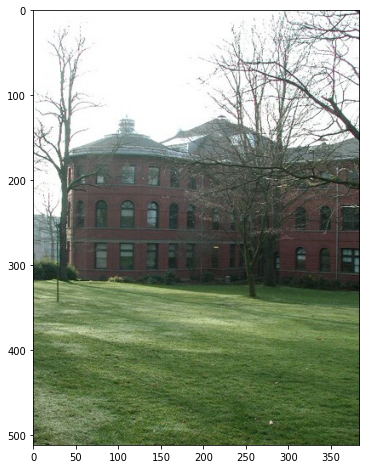

In [2]:
imgs = []
imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/parrington/prtn00.jpg')))
# imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/test/0test.jpg')))

utils.imshow_plt(imgs[0])

In [3]:
def to_gaussian_list(img, s = 5, sigma = 1.6, input_blur = 0.5, interval_count = 3, plt_img = False):
    height, width, _ = img.shape
    std_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    std_img = cv2.resize(std_img, (width * 2, height * 2), cv2.INTER_LINEAR)
    # σ² = σ₁² + σ₂²
    sigma_diff = math.sqrt(max(0.01, sigma ** 2 - ((input_blur * 2) ** 2)))
    # Anti alias
    std_img = cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma_diff)
    octave_count = int(math.log2(min(width, height)) - 1)
    # 2 extra LoGs because we cant scan top and bottom layers
    img_count_perOctave = s + 3
    print(octave_count)
    DoGOctaves = []
    GaussianOctaves = []
    k = 2 ** (1 / s)

    for i in range(octave_count):
        gaussian_imgs = []
        gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma))
        # octave
        for j in range(1, img_count_perOctave):
            gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=(sigma * (k ** j))))
            print("Sigma:", sigma * (k ** j))
        GaussianOctaves.append(gaussian_imgs)
        DoGs = []
        for j in range(img_count_perOctave - 1):
            # DoGs.append(cv2.subtract(gaussian_imgs[j], gaussian_imgs[j + 1]))
            DoGs.append(gaussian_imgs[j].astype('float32') - gaussian_imgs[j + 1].astype('float32'))
        DoGOctaves.append(DoGs)
        # scale down image to speed up process
        std_img = cv2.resize(gaussian_imgs[-3], (width // (2 ** i), height // (2 ** i)))
        # sigma *= 2
        if plt_img:
            utils.imshows_plt(gaussian_imgs)
            utils.imshows_plt(DoGs)

    return DoGOctaves, GaussianOctaves
    

In [4]:
# DoGOctaves
"""
Octaves
[
    DoG Collection
    [
        DoG
    ]
]
"""

# GaussianOctaves
"""
GaussianOctaves
[
    Gaussians
    [
        
    ]
]
"""

'\nGaussianOctaves\n[\n    Gaussians\n    [\n        \n    ]\n]\n'

In [5]:
# to_gaussian_list(imgs[0], plt_img=True)

In [6]:
# def findMaxAndMinIn3x3x3(DoGs, DoGId, row, col):
#     for i in ra
#     maxVal = max(DoGs[DoGId][row][col], DoGs[DoGId][row][col], DoGs[DoGId][row][col])


In [7]:
DoGOctaves, GaussianOctaves = to_gaussian_list(imgs[0])

7
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985


In [8]:
def findExtremaInDoG(Octaves, OctaveLayersCount = 5, contrastThreshold = 0.4):
    # DoGOctaves
    """
    Octaves
    [
        DoGOctave
        [
            DoG
        ]
    ]
    """
    candidates = []
    # height, width = DoGs[0].shape
    for OctaveIdx in range(len(Octaves)):
        DoGOctave = Octaves[OctaveIdx]
        maxConv = DoGOctave * (DoGOctave == maximum_filter(DoGOctave,footprint=np.ones((3,3,3))))
        minConv = DoGOctave * (DoGOctave == minimum_filter(DoGOctave,footprint=np.ones((3,3,3))))

        utils.imshow_plt(maxConv[0])
        threshold = int(0.5 * contrastThreshold / (OctaveLayersCount + 3) * 255)
        maxConvInds = np.argwhere(maxConv > threshold)
        minConvInds = np.argwhere(minConv < -threshold)

        print("Max len:", len(maxConvInds))
        print("min len:", len(minConvInds))

        print(np.array(maxConvInds))

        candidates.extend(maxConvInds)
        candidates.extend(minConvInds)

    print("Extrema length:", len(candidates), candidates[0])

    keypoints = []
    # keypoint_dict = {}
    for candidate in candidates:
        # keypoints.append(cv2.KeyPoint(float(candidate[2]), float(candidate[1]), 1))
        # keypoint [row, col, sigma_index]
        keypoints.append([int(candidate[1]), int(candidate[2]), int(candidate[0])])
        # keypoint_dict[(candidate[2], candidate[1])] = 1
            # keypoints.append([candidate[1], candidate[2]])
    # print(len(keypoint_dict))
    return keypoints

    

    
    

In [9]:
def get_parameters(D, row, col, sigma):
    """_summary_

    Args:
        D (list): octaves
        row (int): x of image
        col (int): y of image
        sigma (int): Index of image in a octave

    Returns:
        extremum: np.array(3)
        hessianXY: np.array((2, 2))
        gradient: np.array(3)
    """
    dx = (D[sigma][row, col + 1] - D[sigma][row, col - 1]) / 2.0
    dy = (D[sigma][row + 1, col] - D[sigma][row - 1, col]) / 2.0
    ds = (D[sigma + 1][row, col] - D[sigma - 1][row, col]) / 2.0

    dxx = D[sigma][row, col + 1] - 2 * D[sigma][row, col] + D[sigma][row, col - 1]
    dyy = D[sigma][row + 1, col] - 2 * D[sigma][row, col] + D[sigma][row - 1, col]
    dss = D[sigma + 1][row, col] - 2 * D[sigma][row, col] + D[sigma - 1][row, col]

    dxy = (D[sigma][row + 1, col + 1] - D[sigma][row + 1, col - 1] - D[sigma][row - 1, col + 1] + D[sigma][row - 1, col - 1]) / 4.0
    dxs = (D[sigma + 1][row, col + 1] - D[sigma + 1][row, col - 1] - D[sigma - 1][row, col + 1] + D[sigma - 1][row, col - 1]) / 4.0
    dys = (D[sigma + 1][row + 1, col] - D[sigma + 1][row - 1, col] - D[sigma - 1][row + 1, col] + D[sigma - 1][row - 1, col]) / 4.0

    gradient = np.array([dx, dy, ds])
    hessian = np.array([
                            [dxx, dxy, dxs],
                            [dxy, dyy, dys],
                            [dxs, dys, dss]
                        ])
    hessianXY = np.array([
                            [dxx, dxy],
                            [dxy, dyy]
                        ])

    extremum = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]

    if abs(extremum[0]) > 0.5 or abs(extremum[1]) > 0.5 or abs(extremum[2]) > 0.5:
        return None

    return extremum, hessianXY, gradient

    

In [10]:
def findScaleSpaceExtrema(DoGs, row, col, sigma_idx):
    height, width = DoGs[sigma_idx].shape
    sigma_size = len(DoGs)
    if row < 1 or row >= height - 1 or col < 1 or col >= width - 1 or sigma_idx < 1 or sigma_idx >= sigma_size - 1:
        return None
    var = get_parameters(DoGs, row, col, sigma_idx)
    if var is None:
        return None
    extremum, hessianXY, gradient = var
    iter_count = 0
    while abs(extremum[0]) > 0.5 or abs(extremum[1]) > 0.5 or abs(extremum[2]) > 0.5:
        # Offset larger than 0.5, its the point nearby
        row, col, sigma_idx = round(extremum[0]) + row, round(extremum[1]) + col, round(extremum[2]) + sigma_idx
        # Check boundry
        if row < 0 or row >= height or col < 0 or col >= width or sigma_idx < 0 or sigma_idx >= sigma_size:
            break
        var = get_parameters(DoGs, row, col, sigma_idx)
        if var is None:
            return None
        extremum, hessianXY, gradient = var
        iter_count += 1
        if iter_count > 3:
            print("WARNING!!! iteration count is", iter_count)
    contrast = abs(DoGs[sigma_idx][row, col]) + 0.5 * np.dot(gradient, extremum)
    if contrast < 0.03:
        # Contrast too low
        return None

    tr = np.trace(hessianXY)
    det = np.linalg.det(hessianXY)

    r = 10.0
    if (((r + 1) ** 2) * det) < ((tr ** 2) * r):
        # Discard edge response
        return None
        
    return row, col, sigma_idx, extremum


    

In [11]:
def get_gradients(octaves):
    magOctaves = []
    sitaOctaves = []
    for octave in octaves:
        magnitudes = []
        sitas = []
        for img in octave:
            dx = np.gradient(img, axis=0) * 2
            dy = np.gradient(img, axis=1) * 2
            magnitudes.append(np.sqrt(np.square(dx) + np.square(dy)))
            sitas.append(np.rad2deg(np.arctan2(dy, dx)))
        magOctaves.append(magnitudes)
        sitaOctaves.append(sitas)
    return magOctaves, sitaOctaves

In [12]:
def get_orientation(cv_keypoint, sigma_idx, magOctaves, sitaOctaves, scale_factor = 1.5, radius_factor=3, bin_count = 36):
    scale = scale_factor * cv_keypoint.size / (2 ** (sigma_idx + 1))
    radius = int(scale * radius_factor)
    histogram = [0] * bin_count
    col, row = int(cv_keypoint.pt[0]), int(cv_keypoint.pt[1])
    octave_idx = cv_keypoint.octave
    height, width = magOctaves[octave_idx][sigma_idx].shape
    for x in range(row - radius, row + radius + 1):
        for y in range(col - radius, col + radius + 1):
            # Check if point inside image
            if x < 0 or x >= height or y < 0 or y >= width:
                print("WARNING: outside boundry")
                continue
            histogram[int(sitaOctaves[octave_idx][sigma_idx][x, y] * bin_count / 360.0) % bin_count] += \
                (math.exp((-0.5 / (scale ** 2)) * ((x - row) ** 2 + (y - col) ** 2)) * magOctaves[octave_idx][sigma_idx][row, col])
    # utils.list_plt(histogram)
    top_val, top_idx = 0, 0
    sec_val, sec_idx = 0, 0
    for i in range(bin_count):
        if histogram[i] > sec_val:
            sec_val = histogram[i]
            sec_idx = i
        if histogram[i] > top_val:
            sec_val = top_val
            sec_idx = top_idx
            top_val = histogram[i]
            top_idx = i
    if top_val * 0.8 <= sec_val:
        return [[cv_keypoint, top_val, top_idx * 360 / float(bin_count)], [cv_keypoint, sec_val, sec_idx * 360 / float(bin_count)]]
    else:
        return [[cv_keypoint, top_val, top_idx * 360 / float(bin_count)]]

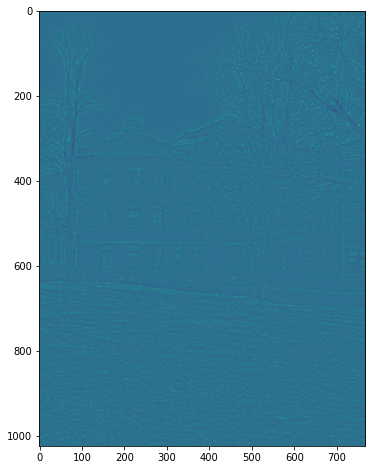

Max len: 437
min len: 857
[[  0 201 643]
 [  1   0 767]
 [  1 220 696]
 ...
 [  6 484  60]
 [  6 970 558]
 [  6 972 558]]


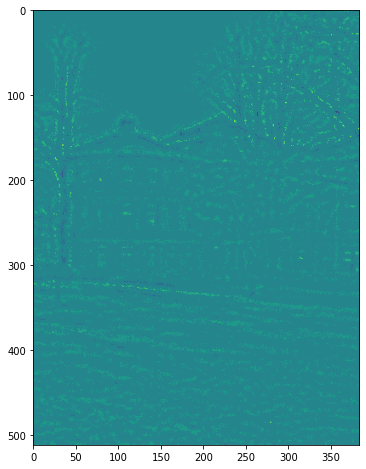

Max len: 44
min len: 98
[[  2 138 383]
 [  2 147 371]
 [  2 147 372]
 [  2 147 373]
 [  2 148 372]
 [  2 148 373]
 [  4 137 382]
 [  4 137 383]
 [  4 138 382]
 [  4 138 383]
 [  4 139 383]
 [  4 147 370]
 [  4 147 371]
 [  4 147 372]
 [  4 148 371]
 [  4 148 372]
 [  4 148 373]
 [  4 149 372]
 [  5 135 383]
 [  5 147 371]
 [  5 148 370]
 [  5 148 371]
 [  5 238  28]
 [  5 239  28]
 [  5 241  28]
 [  6 132 252]
 [  6 132 253]
 [  6 133 253]
 [  6 134 383]
 [  6 135 381]
 [  6 135 382]
 [  6 135 383]
 [  6 137 383]
 [  6 148 368]
 [  6 148 370]
 [  6 148 372]
 [  6 149 368]
 [  6 235  28]
 [  6 237  28]
 [  6 237  30]
 [  6 238  30]
 [  6 239  27]
 [  6 241  27]
 [  6 241  29]]


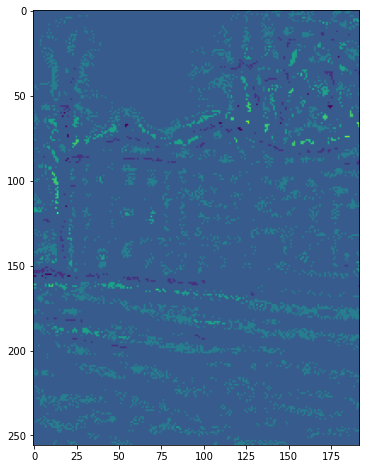

Max len: 0
min len: 5
[]


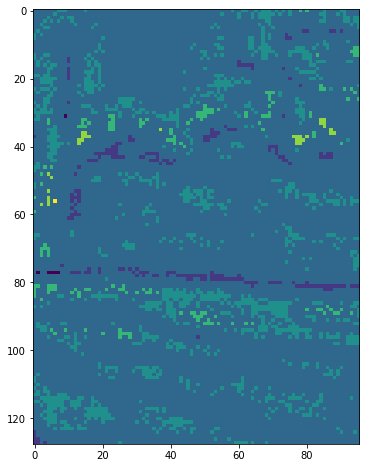

Max len: 24
min len: 0
[[ 6 50  0]
 [ 6 51  1]
 [ 6 51  2]
 [ 6 52  0]
 [ 6 52  1]
 [ 6 52  2]
 [ 6 52  3]
 [ 6 53  3]
 [ 6 53  4]
 [ 6 54  0]
 [ 6 54  1]
 [ 6 54  3]
 [ 6 54  4]
 [ 6 55  3]
 [ 6 55  4]
 [ 6 55  5]
 [ 6 56  0]
 [ 6 56  1]
 [ 6 56  2]
 [ 6 56  3]
 [ 6 56  4]
 [ 6 57  0]
 [ 6 57  1]
 [ 6 57  2]]


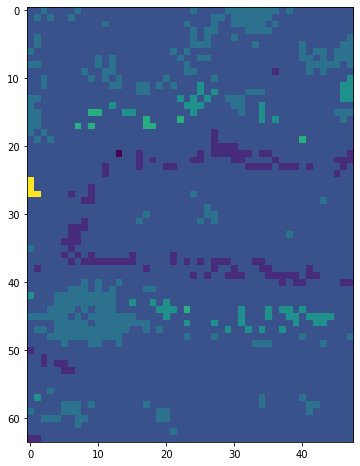

Max len: 18
min len: 0
[[ 3 26  0]
 [ 3 27  0]
 [ 4 25  0]
 [ 4 25  1]
 [ 4 26  0]
 [ 4 26  1]
 [ 4 27  0]
 [ 4 27  1]
 [ 4 28  0]
 [ 5 26  0]
 [ 5 26  1]
 [ 5 27  0]
 [ 5 27  1]
 [ 5 28  0]
 [ 5 28  1]
 [ 6 24  0]
 [ 6 26  0]
 [ 6 27  0]]


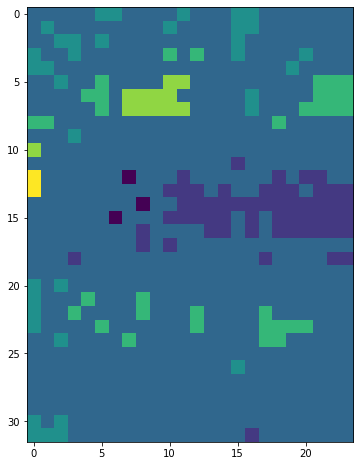

Max len: 0
min len: 0
[]


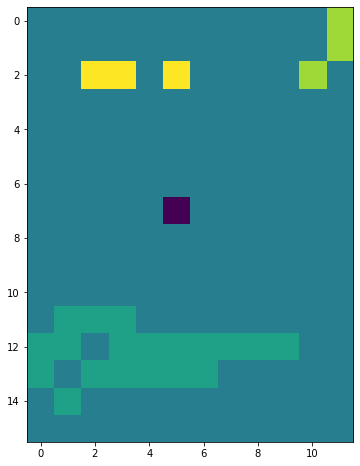

Max len: 12
min len: 0
[[ 5  0  3]
 [ 5  0  8]
 [ 6  0  0]
 [ 6  0  1]
 [ 6  0  3]
 [ 6  0  4]
 [ 6  0  5]
 [ 6  0  8]
 [ 6  0 10]
 [ 6  1  1]
 [ 6  1  3]
 [ 6  1  4]]
Extrema length: 1495 [  0 201 643]
Index: 33
value: 0.05021359517008192
x, y, scale, mag: 217 692 1.6635886430740356 16.278820596099706
Index: 34
value: 0.1778521711674039
x, y, scale, mag: 217 693 1.6635886430740356 16.278820596099706
Index: 34
value: 0.43890641090225124
x, y, scale, mag: 217 694 1.6635886430740356 16.278820596099706
Index: 33
value: 0.754674327309962
x, y, scale, mag: 217 695 1.6635886430740356 16.278820596099706
Index: 33
value: 0.9041117780777674
x, y, scale, mag: 217 696 1.6635886430740356 16.278820596099706
Index: 32
value: 0.754674327309962
x, y, scale, mag: 217 697 1.6635886430740356 16.278820596099706
Index: 32
value: 0.43890641090225124
x, y, scale, mag: 217 698 1.6635886430740356 16.278820596099706
Index: 31
value: 0.1778521711674039
x, y, scale, mag: 217 699 1.6635886430740356 16.278820596099

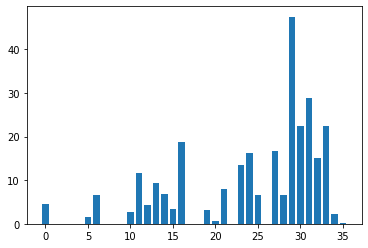

Histogram [4.466324937706894, 0, 0, 0, 0, 1.5545681971954841, 6.596448616709272, 0, 0, 0, 2.6729905951117314, 11.54384116793309, 4.331776700499461, 9.34459755211697, 6.865717483309518, 3.4276649224216933, 18.842774358388695, 0, 0, 3.202285001990044, 0.754674327309962, 7.9026497550407955, 0, 13.588151687262265, 16.261142282373996, 6.596448616709272, 0, 16.733170232166966, 6.596448616709272, 47.46188984815156, 22.448291451977795, 28.832951750814026, 14.971506090354783, 22.32065287598047, 2.171326779265139, 0.1778521711674039]
Index: 20
value: 0.00791724720700825
x, y, scale, mag: 225 697 1.520774781703949 8.0
Index: 29
value: 0.03595936654850411
x, y, scale, mag: 225 698 1.520774781703949 8.0
Index: 31
value: 0.10599066660434171
x, y, scale, mag: 225 699 1.520774781703949 8.0
Index: 31
value: 0.20274071700709698
x, y, scale, mag: 225 700 1.520774781703949 8.0
Index: 31
value: 0.2516703750068053
x, y, scale, mag: 225 701 1.520774781703949 8.0
Index: 31
value: 0.20274071700709698
x, y, sca

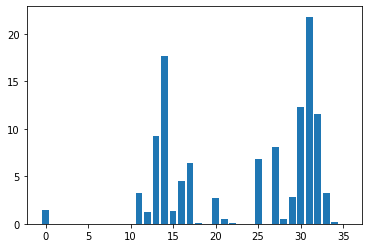

Histogram [1.4189302308621246, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.1955527360791516, 1.2295599956966268, 9.268871533136556, 17.6796473586799, 1.394732733380348, 4.492759416768698, 6.444643061436684, 0.10599066660434171, 0, 2.7220706873576392, 0.48139929592852054, 0.03595936654850411, 0, 0, 6.7818494461259435, 0, 8.035959366548504, 0.48139929592852054, 2.856103473303477, 12.332135211585731, 21.78820985074425, 11.545587693885832, 3.1955527360791516, 0.16332394439131073, 0]
Index: 0
value: 0.015100953380494438
x, y, scale, mag: 227 699 1.5119052529335022 16.55294535724685
Index: 33
value: 0.06981940274000696
x, y, scale, mag: 227 700 1.5119052529335022 16.55294535724685
Index: 32
value: 0.20842795132409056
x, y, scale, mag: 227 701 1.5119052529335022 16.55294535724685
Index: 31
value: 0.4017388740422229
x, y, scale, mag: 227 702 1.5119052529335022 16.55294535724685
Index: 31
value: 0.4999652549424375
x, y, scale, mag: 227 703 1.5119052529335022 16.55294535724685
Index: 31
value: 0.40173887404

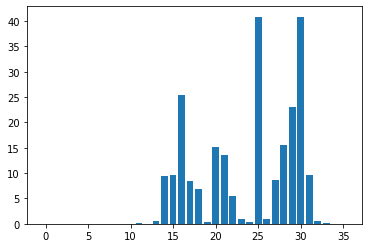

Histogram [0.015100953380494438, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06981940274000696, 0, 0.6101668253663135, 9.471681598726523, 9.66362408371238, 25.392454755066534, 8.356481528143402, 6.900672506908099, 0.4017388740422229, 15.158291073168238, 13.50927548855629, 5.544922123395479, 1.0334880340575592, 0.3379116313650971, 40.80508676175149, 1.0334880340575592, 8.63013604965482, 15.560029947210461, 23.01307944888822, 40.85399223741899, 9.62042919752415, 0.5312386293086933, 0.06981940274000696, 0, 0]
Index: 35
value: 0.1654196728380443
x, y, scale, mag: 137 583 0.952440619468689 13.601470508735444
Index: 32
value: 0.8643938584580864
x, y, scale, mag: 137 584 0.952440619468689 13.601470508735444
Index: 31
value: 1.49998360046746
x, y, scale, mag: 137 585 0.952440619468689 13.601470508735444
Index: 31
value: 0.8643938584580864
x, y, scale, mag: 137 586 0.952440619468689 13.601470508735444
Index: 30
value: 0.1654196728380443
x, y, scale, mag: 137 587 0.952440619468689 13.601470508735444
Index: 

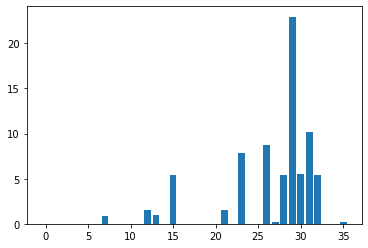

Histogram [0, 0, 0, 0, 0, 0, 0, 0.8643938584580864, 0, 0, 0, 0, 1.49998360046746, 1.0298135312961307, 0, 5.381249258550607, 0, 0, 0, 0, 0, 1.49998360046746, 0, 7.838104076661706, 0, 0, 8.702497935119792, 0.1654196728380443, 5.381249258550607, 22.93955818586461, 5.546668931388651, 10.202481535587253, 5.381249258550607, 0, 0, 0.1654196728380443]
Index: 33
value: 0.0031556607050347214
x, y, scale, mag: 217 692 1.0446606874465942 12.041594578792296
Index: 33
value: 0.031187275777530627
x, y, scale, mag: 217 693 1.0446606874465942 12.041594578792296
Index: 34
value: 0.1232848536035554
x, y, scale, mag: 217 694 1.0446606874465942 12.041594578792296
Index: 33
value: 0.19493380116915068
x, y, scale, mag: 217 695 1.0446606874465942 12.041594578792296
Index: 33
value: 0.1232848536035554
x, y, scale, mag: 217 696 1.0446606874465942 12.041594578792296
Index: 32
value: 0.031187275777530627
x, y, scale, mag: 217 697 1.0446606874465942 12.041594578792296
Index: 32
value: 0.0031556607050347214
x, y, s

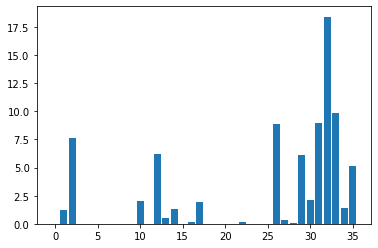

Histogram [0, 1.218419560249988, 7.615642930553553, 0, 0, 0, 0, 0, 0, 0, 2.049808261435429, 0, 6.229826534152975, 0.4938820758886902, 1.3448600745585781, 0, 0.19493380116915068, 1.9265234078318736, 0, 0, 0, 0, 0.1232848536035554, 0, 0, 0, 8.865249766581071, 0.30822267073007353, 0.034342936482565346, 6.15817758658738, 2.1214572090010244, 8.988534620184627, 18.41905291898876, 9.894727929640698, 1.372891689631074, 5.12469584346391]
Index: 34
value: 0.2901064779742939
x, y, scale, mag: 218 694 0.952440619468689 23.853720883753127
Index: 33
value: 1.5159397522530518
x, y, scale, mag: 218 695 0.952440619468689 23.853720883753127
Index: 32
value: 2.63061189691058
x, y, scale, mag: 218 696 0.952440619468689 23.853720883753127
Index: 32
value: 1.5159397522530518
x, y, scale, mag: 218 697 0.952440619468689 23.853720883753127
Index: 31
value: 0.2901064779742939
x, y, scale, mag: 218 698 0.952440619468689 23.853720883753127
Index: 35
value: 1.5159397522530518
x, y, scale, mag: 219 694 0.9524406194

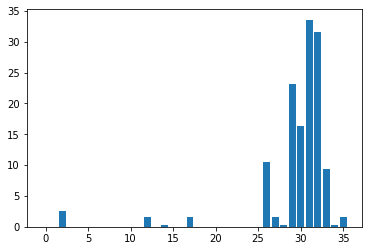

Histogram [0, 0, 2.63061189691058, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.5159397522530518, 0, 0.2901064779742939, 0, 0, 1.5159397522530518, 0, 0, 0, 0, 0, 0, 0, 0, 10.552094204053942, 1.5159397522530518, 0.2901064779742939, 23.183578901953773, 16.37676873946794, 33.581249421123836, 31.63886533427835, 9.437422059396413, 0.2901064779742939, 1.5159397522530518]
Index: 34
value: 0.001118523284219823
x, y, scale, mag: 218 692 1.046857237815857 4.123105625617661
Index: 35
value: 0.0109486743336674
x, y, scale, mag: 218 693 1.046857237815857 4.123105625617661
Index: 34
value: 0.043031991272973844
x, y, scale, mag: 218 694 1.046857237815857 4.123105625617661
Index: 33
value: 0.06791015863294014
x, y, scale, mag: 218 695 1.046857237815857 4.123105625617661
Index: 32
value: 0.043031991272973844
x, y, scale, mag: 218 696 1.046857237815857 4.123105625617661
Index: 32
value: 0.0109486743336674
x, y, scale, mag: 218 697 1.046857237815857 4.123105625617661
Index: 31
value: 0.001118523284219823
x, y, scale, ma

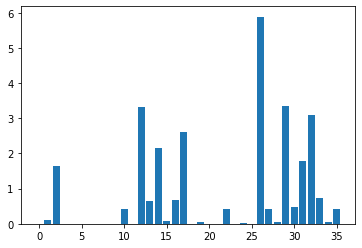

Histogram [0, 0.10717118843736886, 1.6555330577752851, 0, 0, 0, 0, 0, 0, 0, 0.4321676735480055, 0, 3.320420684183061, 0.6393323375576209, 2.142799920214152, 0.06791015863294014, 0.6647391442891308, 2.612649548620956, 0, 0.043031991272973844, 0, 0, 0.4212189992143381, 0, 0.0109486743336674, 0, 5.885809871830315, 0.4212189992143381, 0.055099188890861066, 3.345298851543027, 0.46425099048731194, 1.7747714438305413, 3.0878492134419355, 0.732649302922071, 0.04415051455719367, 0.4321676735480055]
Index: 1
value: 0.00236980644294859
x, y, scale, mag: 219 693 1.0286927819252014 11.704699910719626
Index: 35
value: 0.025160892643306957
x, y, scale, mag: 219 694 1.0286927819252014 11.704699910719626
Index: 33
value: 0.10383265187048012
x, y, scale, mag: 219 695 1.0286927819252014 11.704699910719626
Index: 32
value: 0.1665469100920313
x, y, scale, mag: 219 696 1.0286927819252014 11.704699910719626
Index: 31
value: 0.10383265187048012
x, y, scale, mag: 219 697 1.0286927819252014 11.704699910719626
I

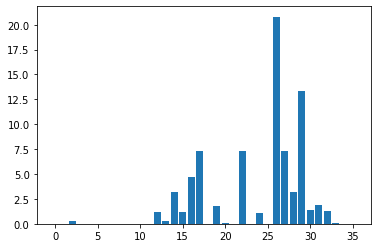

Histogram [0, 0.00236980644294859, 0.267140179524675, 0, 0, 0, 0, 0, 0, 0, 0.025160892643306957, 0, 1.2062527310953601, 0.2703795619625114, 3.190526612904937, 1.2062527310953601, 4.715956262292958, 7.297223529434548, 0, 1.7682747624258195, 0.10383265187048012, 0, 7.297223529434548, 0, 1.10242007922488, 0, 20.803518615121476, 7.297223529434548, 3.1629959138186816, 13.348426067336652, 1.3970909578358104, 1.8996381133825553, 1.2689669893169113, 0.10383265187048012, 0, 0.025160892643306957]
Index: 33
value: 0.33790823486225174
x, y, scale, mag: 223 669 0.9900610148906708 20.0
Index: 33
value: 1.5609373884025903
x, y, scale, mag: 223 670 0.9900610148906708 20.0
Index: 33
value: 2.599647033203745
x, y, scale, mag: 223 671 0.9900610148906708 20.0
Index: 32
value: 1.5609373884025903
x, y, scale, mag: 223 672 0.9900610148906708 20.0
Index: 32
value: 0.33790823486225174
x, y, scale, mag: 223 673 0.9900610148906708 20.0
Index: 32
value: 1.5609373884025903
x, y, scale, mag: 224 669 0.9900610148906

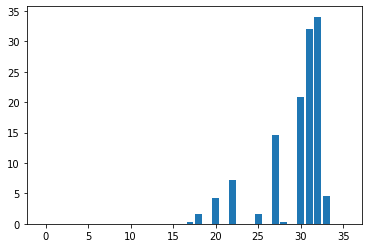

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.33790823486225174, 1.5609373884025903, 0, 4.160584421606336, 0, 7.21061305743658, 0, 0, 1.5609373884025903, 0, 14.608487990961974, 0.33790823486225174, 0, 20.7803914035974, 32.00884095775823, 34.05043450590516, 4.498492656468587, 0, 0]
Index: 1
value: 0.21596802892029945
x, y, scale, mag: 257 717 0.9849090278148651 13.341664064126334
Index: 35
value: 1.0137880456493364
x, y, scale, mag: 257 718 0.9849090278148651 13.341664064126334
Index: 34
value: 1.6974607183808867
x, y, scale, mag: 257 719 0.9849090278148651 13.341664064126334
Index: 33
value: 1.0137880456493364
x, y, scale, mag: 257 720 0.9849090278148651 13.341664064126334
Index: 32
value: 0.21596802892029945
x, y, scale, mag: 257 721 0.9849090278148651 13.341664064126334
Index: 5
value: 1.0137880456493364
x, y, scale, mag: 258 717 0.9849090278148651 13.341664064126334
Index: 0
value: 4.7588812410784485
x, y, scale, mag: 258 718 0.9849090278148651 13.341664064126334
I

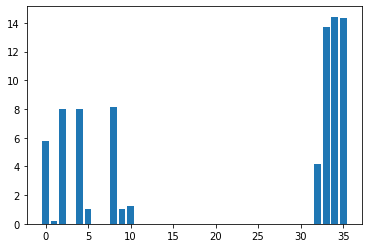

Histogram [5.772669286727785, 0.21596802892029945, 7.968148771172716, 0, 7.968148771172716, 1.0137880456493364, 0, 0, 8.153802677840222, 1.0137880456493364, 1.2297560745696359, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.1569728675201585, 13.740818057900501, 14.424490730632051, 14.35545210977567]
Index: 13
value: 0.4787217099439601
x, y, scale, mag: 281 764 0.9866167902946472 29.154759474226502
Index: 13
value: 2.235208295231368
x, y, scale, mag: 281 765 0.9866167902946472 29.154759474226502
Index: 15
value: 3.7359090337569225
x, y, scale, mag: 281 766 0.9866167902946472 29.154759474226502
Index: 16
value: 2.235208295231368
x, y, scale, mag: 281 767 0.9866167902946472 29.154759474226502
Index: 13
value: 2.235208295231368
x, y, scale, mag: 282 764 0.9866167902946472 29.154759474226502
Index: 14
value: 10.4364519496222
x, y, scale, mag: 282 765 0.9866167902946472 29.154759474226502
Index: 15
value: 17.443401226697663
x, y, scale, mag: 282 766 0.9866167902946472 29.15

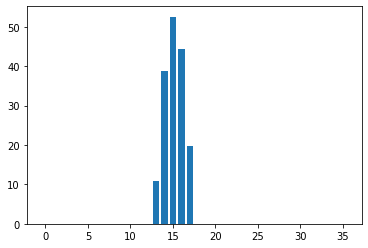

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.920255629394987, 38.79502683588603, 52.569278029912454, 44.28742245493035, 19.67860952192903, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 32
value: 0.006598586736713661
x, y, scale, mag: 294 747 1.0446606874465942 25.179356624028344
Index: 32
value: 0.06521358394820856
x, y, scale, mag: 294 748 1.0446606874465942 25.179356624028344
Index: 32
value: 0.2577925435799205
x, y, scale, mag: 294 749 1.0446606874465942 25.179356624028344
Index: 32
value: 0.4076127680265876
x, y, scale, mag: 294 750 1.0446606874465942 25.179356624028344
Index: 31
value: 0.2577925435799205
x, y, scale, mag: 294 751 1.0446606874465942 25.179356624028344
Index: 31
value: 0.06521358394820856
x, y, scale, mag: 294 752 1.0446606874465942 25.179356624028344
Index: 31
value: 0.006598586736713661
x, y, scale, mag: 294 753 1.0446606874465942 25.179356624028344
Index: 32
value: 0.06521358394820856
x, y, scale, mag: 295 747 1.0446606874465942 25.17935662

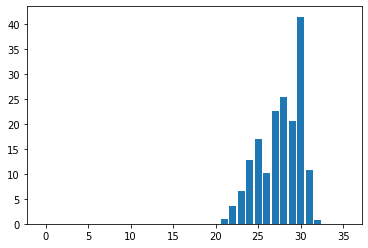

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0393216897814255, 3.470951844451127, 6.576175608422242, 12.684365916080369, 16.98326593553974, 10.071398342867461, 22.565940381578514, 25.437149167608265, 20.618378119972114, 41.420648397052304, 10.80775467903674, 0.8024310662396389, 0, 0, 0]
Index: 10
value: 0.22624930981149877
x, y, scale, mag: 340 67 0.9898326694965363 13.416407864998739
Index: 10
value: 1.0458770520673295
x, y, scale, mag: 340 68 0.9898326694965363 13.416407864998739
Index: 14
value: 1.7422551534162634
x, y, scale, mag: 340 69 0.9898326694965363 13.416407864998739
Index: 25
value: 1.0458770520673295
x, y, scale, mag: 340 70 0.9898326694965363 13.416407864998739
Index: 26
value: 0.22624930981149877
x, y, scale, mag: 340 71 0.9898326694965363 13.416407864998739
Index: 10
value: 1.0458770520673295
x, y, scale, mag: 341 67 0.9898326694965363 13.416407864998739
Index: 11
value: 4.834749811844305
x, y, scale, mag: 341 68 0.9898326694965363 13.416

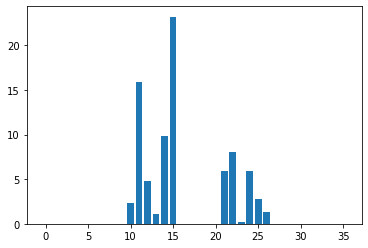

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.318003413946158, 15.903010851997532, 4.834749811844305, 1.0458770520673295, 9.796134678274399, 23.212542543273138, 0, 0, 0, 0, 0, 5.880626863911635, 8.053879524858136, 0.22624930981149877, 5.880626863911635, 2.788132205483593, 1.2721263618788283, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 14
value: 0.004730334555266065
x, y, scale, mag: 363 58 1.055443435907364 15.264337522473747
Index: 18
value: 0.044622578672446365
x, y, scale, mag: 363 59 1.055443435907364 15.264337522473747
Index: 24
value: 0.17153484235602345
x, y, scale, mag: 363 60 1.055443435907364 15.264337522473747
Index: 27
value: 0.2687106682768698
x, y, scale, mag: 363 61 1.055443435907364 15.264337522473747
Index: 27
value: 0.17153484235602345
x, y, scale, mag: 363 62 1.055443435907364 15.264337522473747
Index: 28
value: 0.044622578672446365
x, y, scale, mag: 363 63 1.055443435907364 15.264337522473747
Index: 28
value: 0.004730334555266065
x, y, scale, mag: 363 64 1.055443435907364 15.264

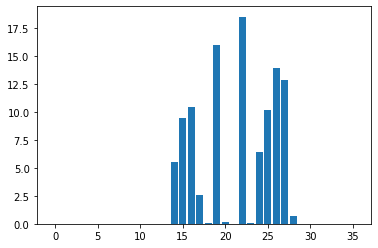

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.500540902662532, 9.456594584520756, 10.433830299424953, 2.5348234454076226, 0.044622578672446365, 15.964503859518821, 0.17153484235602345, 0, 18.500610521209587, 0.044622578672446365, 6.3918564281409385, 10.16984996570335, 13.941764797181898, 12.871909051194166, 0.6864476916703597, 0, 0, 0, 0, 0, 0, 0]
Index: 4
value: 0.24873594083024222
x, y, scale, mag: 425 86 0.993456244468689 14.317821063276353
Index: 3
value: 1.1370784743945515
x, y, scale, mag: 425 87 0.993456244468689 14.317821063276353
Index: 1
value: 1.8871557150413165
x, y, scale, mag: 425 88 0.993456244468689 14.317821063276353
Index: 0
value: 1.1370784743945515
x, y, scale, mag: 425 89 0.993456244468689 14.317821063276353
Index: 33
value: 0.24873594083024222
x, y, scale, mag: 425 90 0.993456244468689 14.317821063276353
Index: 4
value: 1.1370784743945515
x, y, scale, mag: 426 86 0.993456244468689 14.317821063276353
Index: 3
value: 5.198072512624358
x, y, scale, mag: 426 

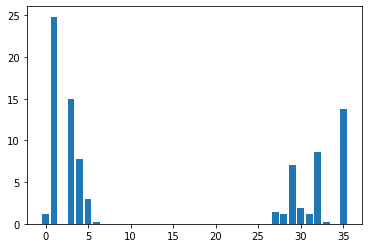

Histogram [1.1370784743945515, 24.83197348109268, 0, 14.96214768979392, 7.720965402243703, 3.0242341894358677, 0.24873594083024222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3858144152247938, 1.1370784743945515, 7.085228227665675, 1.8871557150413165, 1.1370784743945515, 8.62699670277501, 0.24873594083024222, 0, 13.825069215399367]
Index: 3
value: 0.001669579288845787
x, y, scale, mag: 967 556 1.0286927819252014 8.246211251235321
Index: 2
value: 0.017726386630069996
x, y, scale, mag: 967 557 1.0286927819252014 8.246211251235321
Index: 0
value: 0.07315232245431494
x, y, scale, mag: 967 558 1.0286927819252014 8.246211251235321
Index: 35
value: 0.11733585776099988
x, y, scale, mag: 967 559 1.0286927819252014 8.246211251235321
Index: 33
value: 0.07315232245431494
x, y, scale, mag: 967 560 1.0286927819252014 8.246211251235321
Index: 32
value: 0.017726386630069996
x, y, scale, mag: 967 561 1.0286927819252014 8.246211251235321
Index: 31
value: 0.001669579288845787
x, y, sca

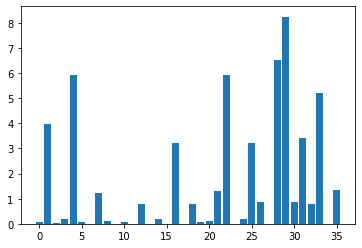

Histogram [0.07315232245431494, 3.981834630788154, 0.017726386630069996, 0.18987554534149967, 5.935454834213626, 0.07315232245431494, 0, 1.2457873634023615, 0.11733585776099988, 0, 0.07315232245431494, 0, 0.7944048944289959, 0, 0.18987554534149967, 0, 3.2228825096192977, 0, 0.7766785077989259, 0.07315232245431494, 0.11733585776099988, 1.3189396858566764, 5.935454834213626, 0.001669579288845787, 0.2059323526827239, 3.205156122989228, 0.8498308302532408, 0, 6.504173160947992, 8.246211251235321, 0.8498308302532408, 3.4127580549607974, 0.7944048944289959, 5.2142022622389455, 0, 1.3631232211633615]
Index: 27
value: 0.5977724811446123
x, y, scale, mag: 139 584 0.5937316417694092 10.198039027185569
Index: 29
value: 2.4690295850982236
x, y, scale, mag: 139 585 0.5937316417694092 10.198039027185569
Index: 29
value: 0.5977724811446123
x, y, scale, mag: 139 586 0.5937316417694092 10.198039027185569
Index: 18
value: 2.4690295850982236
x, y, scale, mag: 140 584 0.5937316417694092 10.198039027185569

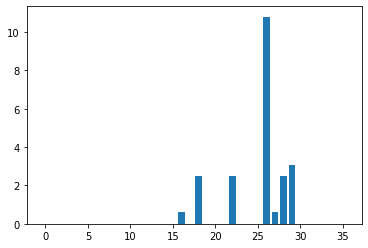

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5977724811446123, 0, 2.4690295850982236, 0, 0, 0, 2.4690295850982236, 0, 0, 0, 10.795811508330182, 0.5977724811446123, 2.4690295850982236, 3.066802066242836, 0, 0, 0, 0, 0, 0]
Index: 18
value: 0.0014791182304110776
x, y, scale, mag: 165 614 0.6734772473573685 10.0
Index: 31
value: 0.04038794964927309
x, y, scale, mag: 165 615 0.6734772473573685 10.0
Index: 31
value: 0.12161900469955662
x, y, scale, mag: 165 616 0.6734772473573685 10.0
Index: 31
value: 0.04038794964927309
x, y, scale, mag: 165 617 0.6734772473573685 10.0
Index: 31
value: 0.0014791182304110776
x, y, scale, mag: 165 618 0.6734772473573685 10.0
Index: 14
value: 0.04038794964927309
x, y, scale, mag: 166 614 0.6734772473573685 10.0
Index: 16
value: 1.1028100684141247
x, y, scale, mag: 166 615 0.6734772473573685 10.0
Index: 27
value: 3.3208584257901217
x, y, scale, mag: 166 616 0.6734772473573685 10.0
Index: 29
value: 1.1028100684141247
x, y, scale, mag: 166 617 0.6

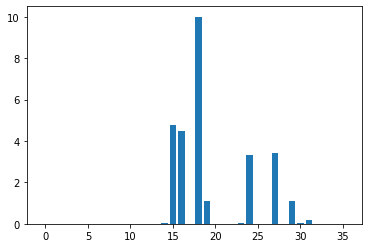

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04038794964927309, 4.749161521132316, 4.4640564438535195, 0, 10.001479118230412, 1.1042891866445357, 0, 0, 0, 0.04038794964927309, 3.3208584257901217, 0, 0, 3.4424774304896784, 0, 1.1028100684141247, 0.04038794964927309, 0.2038740222285139, 0, 0, 0, 0]
Index: 31
value: 0.001272385612640859
x, y, scale, mag: 165 615 0.6734772473573685 8.602325267042627
Index: 31
value: 0.03474302797519873
x, y, scale, mag: 165 616 0.6734772473573685 8.602325267042627
Index: 31
value: 0.10462062370795719
x, y, scale, mag: 165 617 0.6734772473573685 8.602325267042627
Index: 31
value: 0.03474302797519873
x, y, scale, mag: 165 618 0.6734772473573685 8.602325267042627
Index: 31
value: 0.001272385612640859
x, y, scale, mag: 165 619 0.6734772473573685 8.602325267042627
Index: 16
value: 0.03474302797519873
x, y, scale, mag: 166 615 0.6734772473573685 8.602325267042627
Index: 27
value: 0.9486730916267833
x, y, scale, mag: 166 616 0.6734772473573685 8.6023252

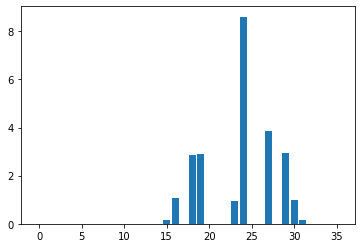

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.17537906527099553, 1.0880367433099392, 0, 2.856710434444577, 2.8914534624197756, 0, 0, 0, 0.9499454772394241, 8.602325267042627, 0, 0, 3.840126554046559, 0, 2.961331058152534, 0.9834161196019819, 0.17665145088363637, 0, 0, 0, 0]
Index: 3
value: 1.8721762941090079
x, y, scale, mag: 174 596 0.6276226937770844 23.706539182259394
Index: 1
value: 6.662043280585348
x, y, scale, mag: 174 597 0.6276226937770844 23.706539182259394
Index: 0
value: 1.8721762941090079
x, y, scale, mag: 174 598 0.6276226937770844 23.706539182259394
Index: 4
value: 6.662043280585348
x, y, scale, mag: 175 596 0.6276226937770844 23.706539182259394
Index: 2
value: 23.706539182259394
x, y, scale, mag: 175 597 0.6276226937770844 23.706539182259394
Index: 0
value: 6.662043280585348
x, y, scale, mag: 175 598 0.6276226937770844 23.706539182259394
Index: 5
value: 1.8721762941090079
x, y, scale, mag: 176 596 0.6276226937770844 23.706539182259394
Index: 4
value: 6.66204

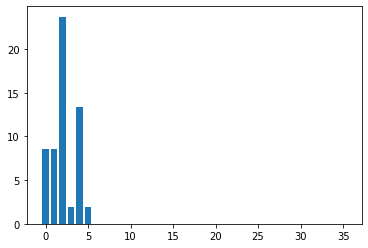

Histogram [8.534219574694355, 8.534219574694355, 23.706539182259394, 1.8721762941090079, 13.324086561170695, 1.8721762941090079, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 16
value: 1.8768854983628316
x, y, scale, mag: 343 69 0.6549565941095352 19.313207915827967
Index: 21
value: 6.020687657077366
x, y, scale, mag: 343 70 0.6549565941095352 19.313207915827967
Index: 24
value: 1.8768854983628316
x, y, scale, mag: 343 71 0.6549565941095352 19.313207915827967
Index: 16
value: 6.020687657077366
x, y, scale, mag: 344 69 0.6549565941095352 19.313207915827967
Index: 21
value: 19.313207915827967
x, y, scale, mag: 344 70 0.6549565941095352 19.313207915827967
Index: 23
value: 6.020687657077366
x, y, scale, mag: 344 71 0.6549565941095352 19.313207915827967
Index: 16
value: 1.8768854983628316
x, y, scale, mag: 345 69 0.6549565941095352 19.313207915827967
Index: 21
value: 6.020687657077366
x, y, scale, mag: 345 70 0.6549565941095352 19.313207915

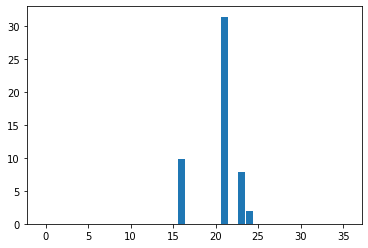

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.77445865380303, 0, 0, 0, 0, 31.3545832299827, 0, 7.897573155440198, 1.8768854983628316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 21
value: 1.9517924881399071
x, y, scale, mag: 366 61 0.6566132158041 19.849433241279208
Index: 25
value: 6.224305157538737
x, y, scale, mag: 366 62 0.6566132158041 19.849433241279208
Index: 27
value: 1.9517924881399071
x, y, scale, mag: 366 63 0.6566132158041 19.849433241279208
Index: 19
value: 6.224305157538737
x, y, scale, mag: 367 61 0.6566132158041 19.849433241279208
Index: 23
value: 19.849433241279208
x, y, scale, mag: 367 62 0.6566132158041 19.849433241279208
Index: 26
value: 6.224305157538737
x, y, scale, mag: 367 63 0.6566132158041 19.849433241279208
Index: 17
value: 1.9517924881399071
x, y, scale, mag: 368 61 0.6566132158041 19.849433241279208
Index: 22
value: 6.224305157538737
x, y, scale, mag: 368 62 0.6566132158041 19.849433241279208
Index: 24
value: 1.9517924881399071
x, y, scale, mag: 

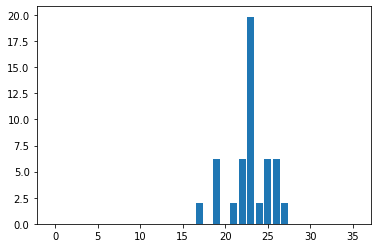

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.9517924881399071, 0, 6.224305157538737, 0, 1.9517924881399071, 6.224305157538737, 19.849433241279208, 1.9517924881399071, 6.224305157538737, 6.224305157538737, 1.9517924881399071, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 0.011189708899464988
x, y, scale, mag: 54 713 0.38917534053325653 8.246211251235321
Index: 0
value: 0.3037642234115403
x, y, scale, mag: 54 714 0.38917534053325653 8.246211251235321
Index: 35
value: 0.011189708899464988
x, y, scale, mag: 54 715 0.38917534053325653 8.246211251235321
Index: 0
value: 0.3037642234115403
x, y, scale, mag: 55 713 0.38917534053325653 8.246211251235321
Index: 35
value: 8.246211251235321
x, y, scale, mag: 55 714 0.38917534053325653 8.246211251235321
Index: 33
value: 0.3037642234115403
x, y, scale, mag: 55 715 0.38917534053325653 8.246211251235321
Index: 4
value: 0.011189708899464988
x, y, scale, mag: 56 713 0.38917534053325653 8.246211251235321
Index: 30
value: 0.3037642234115403
x,

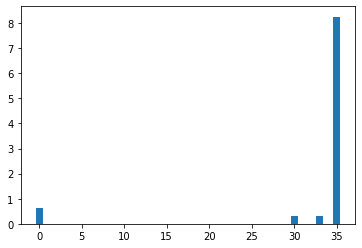

Histogram [0.6187181557225456, 0, 0, 0, 0.011189708899464988, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.011189708899464988, 0, 0, 0.3037642234115403, 0, 0, 0.3037642234115403, 0, 8.257400960134786]
Index: 4
value: 0.007703913914420754
x, y, scale, mag: 55 711 0.3929746448993683 5.0
Index: 3
value: 0.19626403025542857
x, y, scale, mag: 55 712 0.3929746448993683 5.0
Index: 0
value: 0.007703913914420754
x, y, scale, mag: 55 713 0.3929746448993683 5.0
Index: 9
value: 0.19626403025542857
x, y, scale, mag: 56 711 0.3929746448993683 5.0
Index: 9
value: 5.0
x, y, scale, mag: 56 712 0.3929746448993683 5.0
Index: 4
value: 0.19626403025542857
x, y, scale, mag: 56 713 0.3929746448993683 5.0
Index: 12
value: 0.007703913914420754
x, y, scale, mag: 57 711 0.3929746448993683 5.0
Index: 13
value: 0.19626403025542857
x, y, scale, mag: 57 712 0.3929746448993683 5.0
Index: 15
value: 0.007703913914420754
x, y, scale, mag: 57 713 0.3929746448993683 5.0


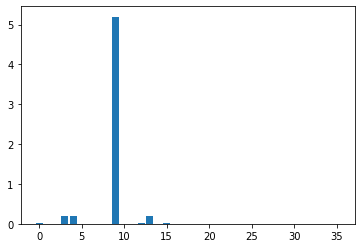

Histogram [0.007703913914420754, 0, 0, 0.19626403025542857, 0.2039679441698493, 0, 0, 0, 0, 5.196264030255429, 0, 0, 0.007703913914420754, 0.19626403025542857, 0, 0.007703913914420754, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 1
value: 0.00638024982942049
x, y, scale, mag: 131 515 0.3906603455543518 4.47213595499958
Index: 0
value: 0.16891815966328577
x, y, scale, mag: 131 516 0.3906603455543518 4.47213595499958
Index: 0
value: 0.00638024982942049
x, y, scale, mag: 131 517 0.3906603455543518 4.47213595499958
Index: 6
value: 0.16891815966328577
x, y, scale, mag: 132 515 0.3906603455543518 4.47213595499958
Index: 2
value: 4.47213595499958
x, y, scale, mag: 132 516 0.3906603455543518 4.47213595499958
Index: 0
value: 0.16891815966328577
x, y, scale, mag: 132 517 0.3906603455543518 4.47213595499958
Index: 12
value: 0.00638024982942049
x, y, scale, mag: 133 515 0.3906603455543518 4.47213595499958
Index: 13
value: 0.16891815966328577
x, y, scale, mag: 133 516 0.390660

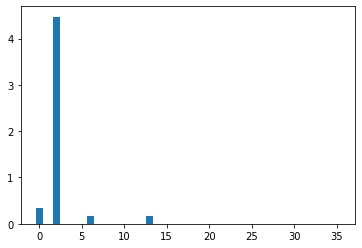

Histogram [0.344216569155992, 0.00638024982942049, 4.47213595499958, 0, 0, 0, 0.16891815966328577, 0, 0, 0, 0, 0, 0.00638024982942049, 0.16891815966328577, 0, 0, 0, 0, 0.00638024982942049, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 6
value: 0.009702226784747331
x, y, scale, mag: 132 515 0.3962683081626892 5.656854249492381
Index: 2
value: 0.23427352137370697
x, y, scale, mag: 132 516 0.3962683081626892 5.656854249492381
Index: 0
value: 0.009702226784747331
x, y, scale, mag: 132 517 0.3962683081626892 5.656854249492381
Index: 12
value: 0.23427352137370697
x, y, scale, mag: 133 515 0.3962683081626892 5.656854249492381
Index: 13
value: 5.656854249492381
x, y, scale, mag: 133 516 0.3962683081626892 5.656854249492381
Index: 18
value: 0.23427352137370697
x, y, scale, mag: 133 517 0.3962683081626892 5.656854249492381
Index: 14
value: 0.009702226784747331
x, y, scale, mag: 134 515 0.3962683081626892 5.656854249492381
Index: 16
value: 0.23427352137370697
x, y, scale, mag: 134 516

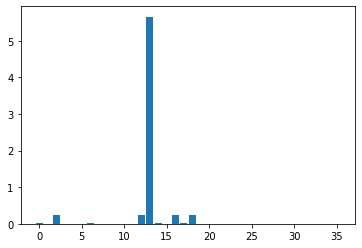

Histogram [0.009702226784747331, 0, 0.23427352137370697, 0, 0, 0, 0.009702226784747331, 0, 0, 0, 0, 0, 0.23427352137370697, 5.656854249492381, 0.009702226784747331, 0, 0.23427352137370697, 0.009702226784747331, 0.23427352137370697, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 2
value: 0.0046223483486524525
x, y, scale, mag: 132 516 0.3929746448993683 3.0
Index: 0
value: 0.11775841815325713
x, y, scale, mag: 132 517 0.3929746448993683 3.0
Index: 34
value: 0.0046223483486524525
x, y, scale, mag: 132 518 0.3929746448993683 3.0
Index: 13
value: 0.11775841815325713
x, y, scale, mag: 133 516 0.3929746448993683 3.0
Index: 18
value: 3.0
x, y, scale, mag: 133 517 0.3929746448993683 3.0
Index: 23
value: 0.11775841815325713
x, y, scale, mag: 133 518 0.3929746448993683 3.0
Index: 16
value: 0.0046223483486524525
x, y, scale, mag: 134 516 0.3929746448993683 3.0
Index: 17
value: 0.11775841815325713
x, y, scale, mag: 134 517 0.3929746448993683 3.0
Index: 18
value: 0.0046223483486524525
x,

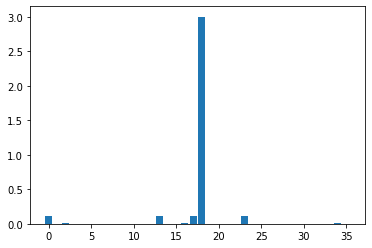

Histogram [0.11775841815325713, 0, 0.0046223483486524525, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11775841815325713, 0, 0, 0.0046223483486524525, 0.11775841815325713, 3.0046223483486525, 0, 0, 0, 0, 0.11775841815325713, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0046223483486524525, 0]
Index: 8
value: 0.03116806056581457
x, y, scale, mag: 161 606 0.4242640882730484 8.06225774829855
Index: 6
value: 0.5012832909604877
x, y, scale, mag: 161 607 0.4242640882730484 8.06225774829855
Index: 1
value: 0.03116806056581457
x, y, scale, mag: 161 608 0.4242640882730484 8.06225774829855
Index: 11
value: 0.5012832909604877
x, y, scale, mag: 162 606 0.4242640882730484 8.06225774829855
Index: 11
value: 8.06225774829855
x, y, scale, mag: 162 607 0.4242640882730484 8.06225774829855
Index: 14
value: 0.5012832909604877
x, y, scale, mag: 162 608 0.4242640882730484 8.06225774829855
Index: 13
value: 0.03116806056581457
x, y, scale, mag: 163 606 0.4242640882730484 8.06225774829855
Index: 14
value: 0.5012832909604877
x, y, scale,

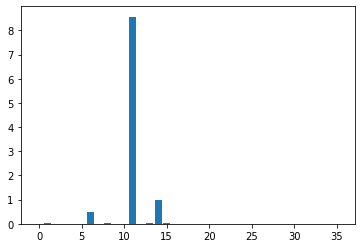

Histogram [0, 0.03116806056581457, 0, 0, 0, 0, 0.5012832909604877, 0, 0.03116806056581457, 0, 0, 8.563541039259038, 0, 0.03116806056581457, 1.0025665819209755, 0.03116806056581457, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 29
value: 0.006849429683117889
x, y, scale, mag: 165 615 0.38728174567222595 5.385164807134504
Index: 31
value: 0.19205548073009762
x, y, scale, mag: 165 616 0.38728174567222595 5.385164807134504
Index: 31
value: 0.006849429683117889
x, y, scale, mag: 165 617 0.38728174567222595 5.385164807134504
Index: 18
value: 0.19205548073009762
x, y, scale, mag: 166 615 0.38728174567222595 5.385164807134504
Index: 25
value: 5.385164807134504
x, y, scale, mag: 166 616 0.38728174567222595 5.385164807134504
Index: 28
value: 0.19205548073009762
x, y, scale, mag: 166 617 0.38728174567222595 5.385164807134504
Index: 16
value: 0.006849429683117889
x, y, scale, mag: 167 615 0.38728174567222595 5.385164807134504
Index: 19
value: 0.19205548073009762
x, y, scale, m

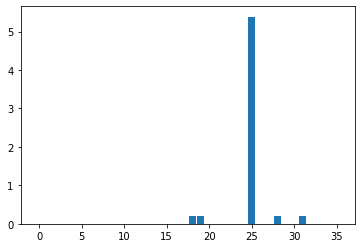

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006849429683117889, 0, 0.19205548073009762, 0.19205548073009762, 0, 0, 0, 0, 0.006849429683117889, 5.385164807134504, 0, 0, 0.19205548073009762, 0.006849429683117889, 0, 0.1989049104132155, 0, 0, 0, 0]
Index: 15
value: 0.013283025790304031
x, y, scale, mag: 166 614 0.37797631323337555 14.560219778561036
Index: 18
value: 0.43977696032320873
x, y, scale, mag: 166 615 0.37797631323337555 14.560219778561036
Index: 25
value: 0.013283025790304031
x, y, scale, mag: 166 616 0.37797631323337555 14.560219778561036
Index: 15
value: 0.43977696032320873
x, y, scale, mag: 167 614 0.37797631323337555 14.560219778561036
Index: 16
value: 14.560219778561036
x, y, scale, mag: 167 615 0.37797631323337555 14.560219778561036
Index: 19
value: 0.43977696032320873
x, y, scale, mag: 167 616 0.37797631323337555 14.560219778561036
Index: 15
value: 0.013283025790304031
x, y, scale, mag: 168 614 0.37797631323337555 14.560219778561036
Index: 15
value: 0.43

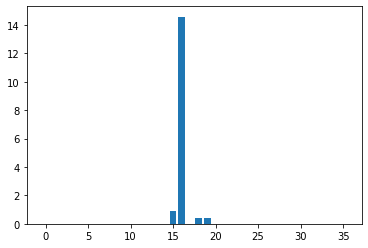

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9061199722270256, 14.57350280435134, 0, 0.43977696032320873, 0.43977696032320873, 0, 0, 0, 0, 0, 0.013283025790304031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 1
value: 0.015182247152130516
x, y, scale, mag: 174 597 0.36915649473667145 23.345235059857504
Index: 0
value: 0.5953428663411858
x, y, scale, mag: 174 598 0.36915649473667145 23.345235059857504
Index: 0
value: 0.015182247152130516
x, y, scale, mag: 174 599 0.36915649473667145 23.345235059857504
Index: 2
value: 0.5953428663411858
x, y, scale, mag: 175 597 0.36915649473667145 23.345235059857504
Index: 0
value: 23.345235059857504
x, y, scale, mag: 175 598 0.36915649473667145 23.345235059857504
Index: 0
value: 0.5953428663411858
x, y, scale, mag: 175 599 0.36915649473667145 23.345235059857504
Index: 3
value: 0.015182247152130516
x, y, scale, mag: 176 597 0.36915649473667145 23.345235059857504
Index: 2
value: 0.5953428663411858
x, y, scale, mag: 176 598 0.36915649473667145 23.345

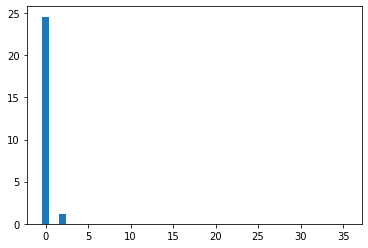

Histogram [24.566285286844135, 0.015182247152130516, 1.1906857326823717, 0.015182247152130516, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 2
value: 0.052709610338949206
x, y, scale, mag: 175 597 0.4158971607685089 17.08800749063506
Index: 0
value: 0.949053326373402
x, y, scale, mag: 175 598 0.4158971607685089 17.08800749063506
Index: 0
value: 0.052709610338949206
x, y, scale, mag: 175 599 0.4158971607685089 17.08800749063506
Index: 3
value: 0.949053326373402
x, y, scale, mag: 176 597 0.4158971607685089 17.08800749063506
Index: 2
value: 17.08800749063506
x, y, scale, mag: 176 598 0.4158971607685089 17.08800749063506
Index: 0
value: 0.949053326373402
x, y, scale, mag: 176 599 0.4158971607685089 17.08800749063506
Index: 5
value: 0.052709610338949206
x, y, scale, mag: 177 597 0.4158971607685089 17.08800749063506
Index: 3
value: 0.949053326373402
x, y, scale, mag: 177 598 0.4158971607685089 17.08800749063506
Index: 1
value: 0.052709

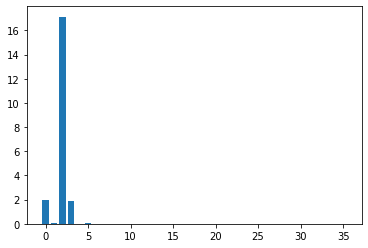

Histogram [1.9508162630857533, 0.052709610338949206, 17.14071710097401, 1.898106652746804, 0, 0.052709610338949206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 10
value: 0.00419136841006014
x, y, scale, mag: 211 527 0.36242683231830597 8.48528137423857
Index: 12
value: 0.18858669174269754
x, y, scale, mag: 211 528 0.36242683231830597 8.48528137423857
Index: 22
value: 0.00419136841006014
x, y, scale, mag: 211 529 0.36242683231830597 8.48528137423857
Index: 11
value: 0.18858669174269754
x, y, scale, mag: 212 527 0.36242683231830597 8.48528137423857
Index: 13
value: 8.48528137423857
x, y, scale, mag: 212 528 0.36242683231830597 8.48528137423857
Index: 21
value: 0.18858669174269754
x, y, scale, mag: 212 529 0.36242683231830597 8.48528137423857
Index: 11
value: 0.00419136841006014
x, y, scale, mag: 213 527 0.36242683231830597 8.48528137423857
Index: 15
value: 0.18858669174269754
x, y, scale, mag: 213 528 0.36242683231830597 8.485281374238

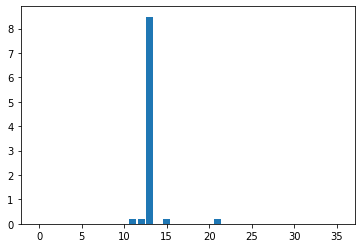

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00419136841006014, 0.1927780601527577, 0.18858669174269754, 8.48528137423857, 0, 0.18858669174269754, 0, 0, 0, 0, 0.00419136841006014, 0.18858669174269754, 0.00419136841006014, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 35
value: 0.008877596100495001
x, y, scale, mag: 213 653 0.38135017454624176 8.602325267042627
Index: 34
value: 0.2763475515467565
x, y, scale, mag: 213 654 0.38135017454624176 8.602325267042627
Index: 32
value: 0.008877596100495001
x, y, scale, mag: 213 655 0.38135017454624176 8.602325267042627
Index: 0
value: 0.2763475515467565
x, y, scale, mag: 214 653 0.38135017454624176 8.602325267042627
Index: 33
value: 8.602325267042627
x, y, scale, mag: 214 654 0.38135017454624176 8.602325267042627
Index: 32
value: 0.2763475515467565
x, y, scale, mag: 214 655 0.38135017454624176 8.602325267042627
Index: 11
value: 0.008877596100495001
x, y, scale, mag: 215 653 0.38135017454624176 8.602325267042627
Index: 27
value: 0.2763475515467565
x

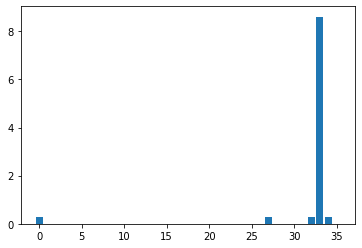

Histogram [0.2763475515467565, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008877596100495001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2763475515467565, 0, 0, 0.008877596100495001, 0, 0.2852251476472515, 8.602325267042627, 0.2763475515467565, 0.008877596100495001]
Index: 32
value: 0.018245639135011427
x, y, scale, mag: 213 655 0.37797631323337555 20.0
Index: 32
value: 0.6040801128163619
x, y, scale, mag: 213 656 0.37797631323337555 20.0
Index: 31
value: 0.018245639135011427
x, y, scale, mag: 213 657 0.37797631323337555 20.0
Index: 32
value: 0.6040801128163619
x, y, scale, mag: 214 655 0.37797631323337555 20.0
Index: 31
value: 20.0
x, y, scale, mag: 214 656 0.37797631323337555 20.0
Index: 31
value: 0.6040801128163619
x, y, scale, mag: 214 657 0.37797631323337555 20.0
Index: 30
value: 0.018245639135011427
x, y, scale, mag: 215 655 0.37797631323337555 20.0
Index: 30
value: 0.6040801128163619
x, y, scale, mag: 215 656 0.37797631323337555 20.0
Index: 30
value: 0.018245639135011427
x, y, scale, m

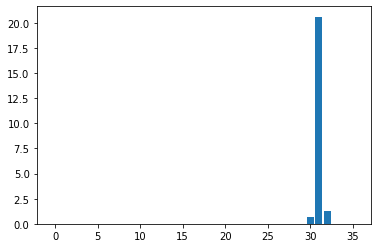

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6405713910863847, 20.622325751951372, 1.2264058647677352, 0, 0, 0]
Index: 33
value: 0.003606372326735244
x, y, scale, mag: 215 685 0.3943684995174408 2.23606797749979
Index: 33
value: 0.08980029885670808
x, y, scale, mag: 215 686 0.3943684995174408 2.23606797749979
Index: 33
value: 0.003606372326735244
x, y, scale, mag: 215 687 0.3943684995174408 2.23606797749979
Index: 16
value: 0.08980029885670808
x, y, scale, mag: 216 685 0.3943684995174408 2.23606797749979
Index: 30
value: 2.23606797749979
x, y, scale, mag: 216 686 0.3943684995174408 2.23606797749979
Index: 31
value: 0.08980029885670808
x, y, scale, mag: 216 687 0.3943684995174408 2.23606797749979
Index: 15
value: 0.003606372326735244
x, y, scale, mag: 217 685 0.3943684995174408 2.23606797749979
Index: 17
value: 0.08980029885670808
x, y, scale, mag: 217 686 0.3943684995174408 2.23606797749979
Index: 20
value: 0.003606372326735244


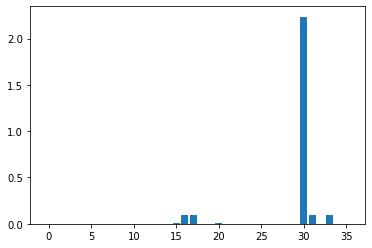

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003606372326735244, 0.08980029885670808, 0.08980029885670808, 0, 0, 0.003606372326735244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.23606797749979, 0.08980029885670808, 0, 0.09701304351017857, 0, 0]
Index: 15
value: 0.017928867384754445
x, y, scale, mag: 216 684 0.3941929489374161 11.180339887498949
Index: 16
value: 0.4477173563303628
x, y, scale, mag: 216 685 0.3941929489374161 11.180339887498949
Index: 30
value: 0.017928867384754445
x, y, scale, mag: 216 686 0.3941929489374161 11.180339887498949
Index: 14
value: 0.4477173563303628
x, y, scale, mag: 217 684 0.3941929489374161 11.180339887498949
Index: 15
value: 11.180339887498949
x, y, scale, mag: 217 685 0.3941929489374161 11.180339887498949
Index: 17
value: 0.4477173563303628
x, y, scale, mag: 217 686 0.3941929489374161 11.180339887498949
Index: 14
value: 0.017928867384754445
x, y, scale, mag: 218 684 0.3941929489374161 11.180339887498949
Index: 15
value: 0.4477173563303628
x, y, scale, m

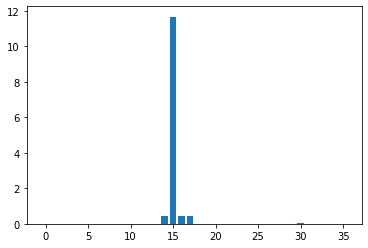

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.46564622371511727, 11.66391497859882, 0.4477173563303628, 0.4477173563303628, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.017928867384754445, 0, 0, 0, 0, 0]
Index: 34
value: 0.011666546277825493
x, y, scale, mag: 222 667 0.3645349144935608 21.633307652783937
Index: 34
value: 0.5023803189553112
x, y, scale, mag: 222 668 0.3645349144935608 21.633307652783937
Index: 33
value: 0.011666546277825493
x, y, scale, mag: 222 669 0.3645349144935608 21.633307652783937
Index: 34
value: 0.5023803189553112
x, y, scale, mag: 223 667 0.3645349144935608 21.633307652783937
Index: 33
value: 21.633307652783937
x, y, scale, mag: 223 668 0.3645349144935608 21.633307652783937
Index: 33
value: 0.5023803189553112
x, y, scale, mag: 223 669 0.3645349144935608 21.633307652783937
Index: 33
value: 0.011666546277825493
x, y, scale, mag: 224 667 0.3645349144935608 21.633307652783937
Index: 32
value: 0.5023803189553112
x, y, scale, mag: 224 668 0.3645349144935608 21.6333

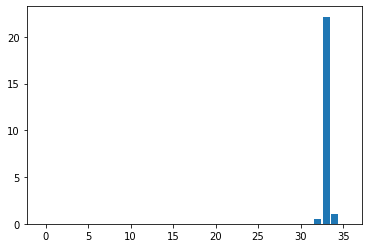

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5140468652331367, 22.1590210642949, 1.0164271841884478, 0]
Index: 34
value: 0.007487403825851409
x, y, scale, mag: 223 667 0.3680327832698822 12.041594578792296
Index: 33
value: 0.3002670167011372
x, y, scale, mag: 223 668 0.3680327832698822 12.041594578792296
Index: 33
value: 0.007487403825851409
x, y, scale, mag: 223 669 0.3680327832698822 12.041594578792296
Index: 33
value: 0.3002670167011372
x, y, scale, mag: 224 667 0.3680327832698822 12.041594578792296
Index: 32
value: 12.041594578792296
x, y, scale, mag: 224 668 0.3680327832698822 12.041594578792296
Index: 32
value: 0.3002670167011372
x, y, scale, mag: 224 669 0.3680327832698822 12.041594578792296
Index: 26
value: 0.007487403825851409
x, y, scale, mag: 225 667 0.3680327832698822 12.041594578792296
Index: 29
value: 0.3002670167011372
x, y, scale, mag: 225 668 0.3680327832698822 12.041594578792296
Index: 30
value: 0.0074874

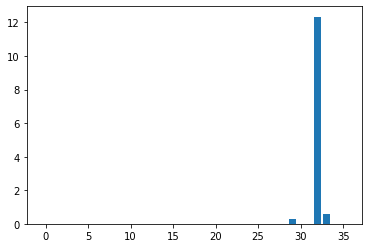

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.007487403825851409, 0, 0, 0.3002670167011372, 0.007487403825851409, 0, 12.341861595493434, 0.6080214372281258, 0.007487403825851409, 0]
Index: 13
value: 0.0066415128951520155
x, y, scale, mag: 226 78 0.37797631323337555 7.280109889280518
Index: 22
value: 0.21988848016160437
x, y, scale, mag: 226 79 0.37797631323337555 7.280109889280518
Index: 25
value: 0.0066415128951520155
x, y, scale, mag: 226 80 0.37797631323337555 7.280109889280518
Index: 13
value: 0.21988848016160437
x, y, scale, mag: 227 78 0.37797631323337555 7.280109889280518
Index: 20
value: 7.280109889280518
x, y, scale, mag: 227 79 0.37797631323337555 7.280109889280518
Index: 25
value: 0.21988848016160437
x, y, scale, mag: 227 80 0.37797631323337555 7.280109889280518
Index: 13
value: 0.0066415128951520155
x, y, scale, mag: 228 78 0.37797631323337555 7.280109889280518
Index: 19
value: 0.21988848016160437
x, y, scale, mag: 228 79 0.37797

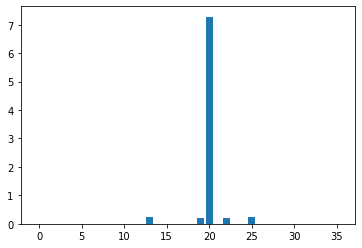

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.23317150595190841, 0, 0, 0, 0, 0, 0.21988848016160437, 7.280109889280518, 0, 0.21988848016160437, 0, 0.0066415128951520155, 0.2265299930567564, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 0.025084232852342115
x, y, scale, mag: 226 718 0.39297719299793243 16.278820596099706
Index: 12
value: 0.6390162176299344
x, y, scale, mag: 226 719 0.39297719299793243 16.278820596099706
Index: 14
value: 0.025084232852342115
x, y, scale, mag: 226 720 0.39297719299793243 16.278820596099706
Index: 12
value: 0.6390162176299344
x, y, scale, mag: 227 718 0.39297719299793243 16.278820596099706
Index: 13
value: 16.278820596099706
x, y, scale, mag: 227 719 0.39297719299793243 16.278820596099706
Index: 15
value: 0.6390162176299344
x, y, scale, mag: 227 720 0.39297719299793243 16.278820596099706
Index: 12
value: 0.025084232852342115
x, y, scale, mag: 228 718 0.39297719299793243 16.278820596099706
Index: 13
value: 0.6390162176299344
x, y, scale, mag: 228 719

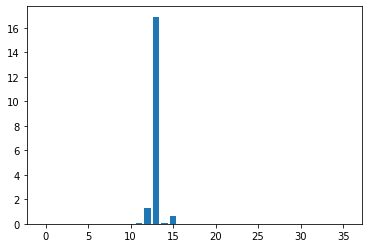

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.025084232852342115, 1.303116668112211, 16.91783681372964, 0.025084232852342115, 0.6641004504822765, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 15
value: 0.0056327002371298965
x, y, scale, mag: 228 699 0.3746323138475418 7.0
Index: 27
value: 0.19856712129632456
x, y, scale, mag: 228 700 0.3746323138475418 7.0
Index: 29
value: 0.0056327002371298965
x, y, scale, mag: 228 701 0.3746323138475418 7.0
Index: 14
value: 0.19856712129632456
x, y, scale, mag: 229 699 0.3746323138475418 7.0
Index: 18
value: 7.0
x, y, scale, mag: 229 700 0.3746323138475418 7.0
Index: 27
value: 0.19856712129632456
x, y, scale, mag: 229 701 0.3746323138475418 7.0
Index: 14
value: 0.0056327002371298965
x, y, scale, mag: 230 699 0.3746323138475418 7.0
Index: 15
value: 0.19856712129632456
x, y, scale, mag: 230 700 0.3746323138475418 7.0
Index: 20
value: 0.0056327002371298965
x, y, scale, mag: 230 701 0.3746323138475418 7.0


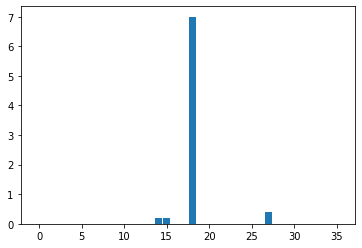

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20419982153345445, 0.20419982153345445, 0, 0, 7.0, 0, 0.0056327002371298965, 0, 0, 0, 0, 0, 0, 0.3971342425926491, 0, 0.0056327002371298965, 0, 0, 0, 0, 0, 0]
Index: 29
value: 0.005803926030098541
x, y, scale, mag: 228 701 0.35781151056289673 14.317821063276353
Index: 30
value: 0.2882699678486172
x, y, scale, mag: 228 702 0.35781151056289673 14.317821063276353
Index: 30
value: 0.005803926030098541
x, y, scale, mag: 228 703 0.35781151056289673 14.317821063276353
Index: 27
value: 0.2882699678486172
x, y, scale, mag: 229 701 0.35781151056289673 14.317821063276353
Index: 29
value: 14.317821063276353
x, y, scale, mag: 229 702 0.35781151056289673 14.317821063276353
Index: 29
value: 0.2882699678486172
x, y, scale, mag: 229 703 0.35781151056289673 14.317821063276353
Index: 20
value: 0.005803926030098541
x, y, scale, mag: 230 701 0.35781151056289673 14.317821063276353
Index: 25
value: 0.2882699678486172
x, y, scale, mag: 230 702 0.357811510

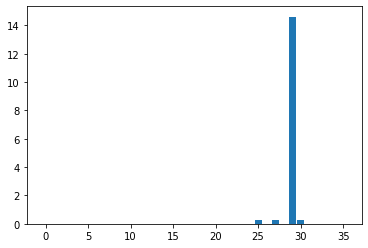

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.005803926030098541, 0, 0, 0, 0, 0.2882699678486172, 0, 0.29407389387871574, 0, 14.61189495715507, 0.29407389387871574, 0, 0, 0, 0, 0]
Index: 18
value: 0.0063511208547620285
x, y, scale, mag: 229 700 0.37348607182502747 8.246211251235321
Index: 27
value: 0.22885079036458214
x, y, scale, mag: 229 701 0.37348607182502747 8.246211251235321
Index: 29
value: 0.0063511208547620285
x, y, scale, mag: 229 702 0.37348607182502747 8.246211251235321
Index: 15
value: 0.22885079036458214
x, y, scale, mag: 230 700 0.37348607182502747 8.246211251235321
Index: 20
value: 8.246211251235321
x, y, scale, mag: 230 701 0.37348607182502747 8.246211251235321
Index: 25
value: 0.22885079036458214
x, y, scale, mag: 230 702 0.37348607182502747 8.246211251235321
Index: 15
value: 0.0063511208547620285
x, y, scale, mag: 231 700 0.37348607182502747 8.246211251235321
Index: 17
value: 0.22885079036458214
x, y, scale, mag: 231 701 0.37348607182502747

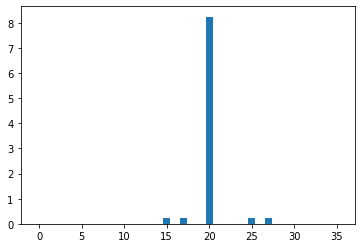

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.23520191121934417, 0, 0.22885079036458214, 0.0063511208547620285, 0, 8.246211251235321, 0.0063511208547620285, 0, 0, 0, 0.22885079036458214, 0, 0.22885079036458214, 0, 0.0063511208547620285, 0, 0, 0, 0, 0, 0]
Index: 35
value: 0.02250924723601057
x, y, scale, mag: 259 719 0.3935869038105011 14.317821063276353
Index: 33
value: 0.5677000741538151
x, y, scale, mag: 259 720 0.3935869038105011 14.317821063276353
Index: 33
value: 0.02250924723601057
x, y, scale, mag: 259 721 0.3935869038105011 14.317821063276353
Index: 0
value: 0.5677000741538151
x, y, scale, mag: 260 719 0.3935869038105011 14.317821063276353
Index: 34
value: 14.317821063276353
x, y, scale, mag: 260 720 0.3935869038105011 14.317821063276353
Index: 33
value: 0.5677000741538151
x, y, scale, mag: 260 721 0.3935869038105011 14.317821063276353
Index: 5
value: 0.02250924723601057
x, y, scale, mag: 261 719 0.3935869038105011 14.317821063276353
Index: 35
value: 0.5677000741538

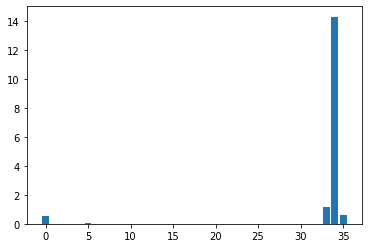

Histogram [0.5677000741538151, 0, 0, 0, 0, 0.02250924723601057, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.1804186427796513, 14.317821063276353, 0.5902093213898256]
Index: 4
value: 0.005968053431903054
x, y, scale, mag: 273 70 0.37889188528060913 6.324555320336759
Index: 35
value: 0.194281455843826
x, y, scale, mag: 273 71 0.37889188528060913 6.324555320336759
Index: 31
value: 0.005968053431903054
x, y, scale, mag: 273 72 0.37889188528060913 6.324555320336759
Index: 6
value: 0.194281455843826
x, y, scale, mag: 274 70 0.37889188528060913 6.324555320336759
Index: 35
value: 6.324555320336759
x, y, scale, mag: 274 71 0.37889188528060913 6.324555320336759
Index: 30
value: 0.194281455843826
x, y, scale, mag: 274 72 0.37889188528060913 6.324555320336759
Index: 6
value: 0.005968053431903054
x, y, scale, mag: 275 70 0.37889188528060913 6.324555320336759
Index: 33
value: 0.194281455843826
x, y, scale, mag: 275 71 0.37889188528060913 6.324555320336759
Index

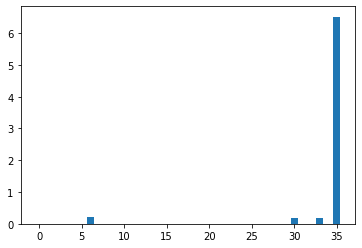

Histogram [0, 0, 0, 0, 0.005968053431903054, 0, 0.20024950927572904, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.005968053431903054, 0.194281455843826, 0.005968053431903054, 0, 0.194281455843826, 0, 6.518836776180585]
Index: 27
value: 0.03492605372851282
x, y, scale, mag: 274 730 0.3980535417795181 19.235384061671343
Index: 28
value: 0.8196438599943956
x, y, scale, mag: 274 731 0.3980535417795181 19.235384061671343
Index: 28
value: 0.03492605372851282
x, y, scale, mag: 274 732 0.3980535417795181 19.235384061671343
Index: 25
value: 0.8196438599943956
x, y, scale, mag: 275 730 0.3980535417795181 19.235384061671343
Index: 27
value: 19.235384061671343
x, y, scale, mag: 275 731 0.3980535417795181 19.235384061671343
Index: 27
value: 0.8196438599943956
x, y, scale, mag: 275 732 0.3980535417795181 19.235384061671343
Index: 23
value: 0.03492605372851282
x, y, scale, mag: 276 730 0.3980535417795181 19.235384061671343
Index: 25
value: 0.8196438599943956
x, y, scale, mag: 2

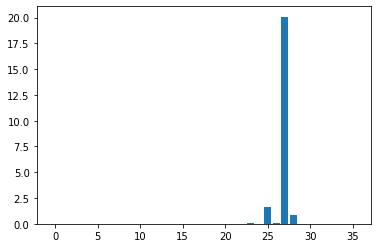

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03492605372851282, 0, 1.6392877199887912, 0.03492605372851282, 20.089953975394252, 0.8545699137229084, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.018533836455884863
x, y, scale, mag: 275 729 0.39294250309467316 12.041594578792296
Index: 25
value: 0.47241607147874026
x, y, scale, mag: 275 730 0.39294250309467316 12.041594578792296
Index: 27
value: 0.018533836455884863
x, y, scale, mag: 275 731 0.39294250309467316 12.041594578792296
Index: 18
value: 0.47241607147874026
x, y, scale, mag: 276 729 0.39294250309467316 12.041594578792296
Index: 23
value: 12.041594578792296
x, y, scale, mag: 276 730 0.39294250309467316 12.041594578792296
Index: 25
value: 0.47241607147874026
x, y, scale, mag: 276 731 0.39294250309467316 12.041594578792296
Index: 17
value: 0.018533836455884863
x, y, scale, mag: 277 729 0.39294250309467316 12.041594578792296
Index: 21
value: 0.47241607147874026
x, y, scale, mag: 277 730 0.3929425030946

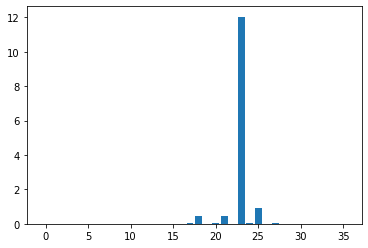

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.018533836455884863, 0.47241607147874026, 0, 0.018533836455884863, 0.47241607147874026, 0, 12.041594578792296, 0.018533836455884863, 0.9448321429574805, 0, 0.018533836455884863, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 6
value: 0.013938780430398388
x, y, scale, mag: 276 70 0.4242640882730484 3.605551275463989
Index: 32
value: 0.22418070291449127
x, y, scale, mag: 276 71 0.4242640882730484 3.605551275463989
Index: 28
value: 0.013938780430398388
x, y, scale, mag: 276 72 0.4242640882730484 3.605551275463989
Index: 7
value: 0.22418070291449127
x, y, scale, mag: 277 70 0.4242640882730484 3.605551275463989
Index: 31
value: 3.605551275463989
x, y, scale, mag: 277 71 0.4242640882730484 3.605551275463989
Index: 28
value: 0.22418070291449127
x, y, scale, mag: 277 72 0.4242640882730484 3.605551275463989
Index: 7
value: 0.013938780430398388
x, y, scale, mag: 278 70 0.4242640882730484 3.605551275463989
Index: 29
value: 0.22418070291449127
x, y, s

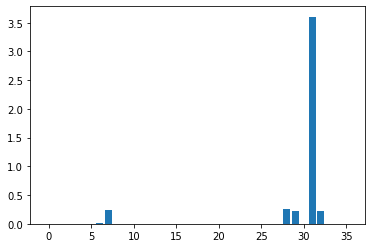

Histogram [0, 0, 0, 0, 0, 0, 0.013938780430398388, 0.23811948334488967, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25205826377528806, 0.22418070291449127, 0, 3.605551275463989, 0.22418070291449127, 0, 0, 0]
Index: 22
value: 0.015553533875177631
x, y, scale, mag: 276 518 0.3908948600292206 10.816653826391969
Index: 26
value: 0.4101672728349463
x, y, scale, mag: 276 519 0.3908948600292206 10.816653826391969
Index: 27
value: 0.015553533875177631
x, y, scale, mag: 276 520 0.3908948600292206 10.816653826391969
Index: 19
value: 0.4101672728349463
x, y, scale, mag: 277 518 0.3908948600292206 10.816653826391969
Index: 24
value: 10.816653826391969
x, y, scale, mag: 277 519 0.3908948600292206 10.816653826391969
Index: 26
value: 0.4101672728349463
x, y, scale, mag: 277 520 0.3908948600292206 10.816653826391969
Index: 17
value: 0.015553533875177631
x, y, scale, mag: 278 518 0.3908948600292206 10.816653826391969
Index: 22
value: 0.4101672728349463
x, y, scale, mag: 278 519 0.3908

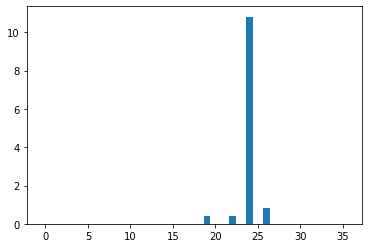

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.015553533875177631, 0, 0.4101672728349463, 0, 0, 0.4257208067101239, 0, 10.816653826391969, 0.015553533875177631, 0.8203345456698926, 0.015553533875177631, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 7
value: 0.004872382973486617
x, y, scale, mag: 278 70 0.3929746448993683 3.1622776601683795
Index: 29
value: 0.12412827167427054
x, y, scale, mag: 278 71 0.3929746448993683 3.1622776601683795
Index: 28
value: 0.004872382973486617
x, y, scale, mag: 278 72 0.3929746448993683 3.1622776601683795
Index: 8
value: 0.12412827167427054
x, y, scale, mag: 279 70 0.3929746448993683 3.1622776601683795
Index: 29
value: 3.1622776601683795
x, y, scale, mag: 279 71 0.3929746448993683 3.1622776601683795
Index: 28
value: 0.12412827167427054
x, y, scale, mag: 279 72 0.3929746448993683 3.1622776601683795
Index: 9
value: 0.004872382973486617
x, y, scale, mag: 280 70 0.3929746448993683 3.1622776601683795
Index: 29
value: 0.12412827167427054
x, y, scale, mag: 28

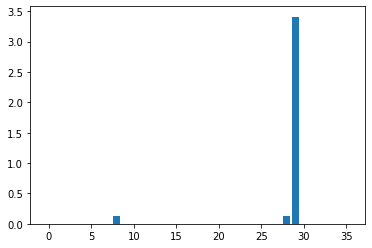

Histogram [0, 0, 0, 0, 0, 0, 0, 0.004872382973486617, 0.12412827167427054, 0.004872382973486617, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004872382973486617, 0.12900065464775715, 3.4105342035169204, 0, 0, 0, 0, 0, 0]
Index: 8
value: 0.020028488272561037
x, y, scale, mag: 292 587 0.39007468521595 14.317821063276353
Index: 8
value: 0.535503792007543
x, y, scale, mag: 292 588 0.39007468521595 14.317821063276353
Index: 9
value: 0.020028488272561037
x, y, scale, mag: 292 589 0.39007468521595 14.317821063276353
Index: 9
value: 0.535503792007543
x, y, scale, mag: 293 587 0.39007468521595 14.317821063276353
Index: 10
value: 14.317821063276353
x, y, scale, mag: 293 588 0.39007468521595 14.317821063276353
Index: 12
value: 0.535503792007543
x, y, scale, mag: 293 589 0.39007468521595 14.317821063276353
Index: 10
value: 0.020028488272561037
x, y, scale, mag: 294 587 0.39007468521595 14.317821063276353
Index: 12
value: 0.535503792007543
x, y, scale, mag: 294 588 0.39007468521595 14.31782

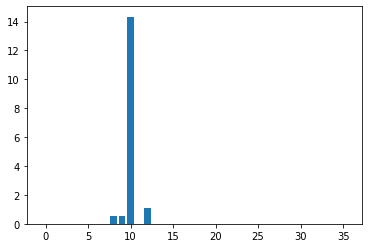

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0.5555322802801039, 0.5555322802801039, 14.337849551548915, 0, 1.071007584015086, 0, 0, 0.020028488272561037, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 8
value: 0.01227265558783162
x, y, scale, mag: 292 588 0.3906603455543518 8.602325267042627
Index: 9
value: 0.32492056761140226
x, y, scale, mag: 292 589 0.3906603455543518 8.602325267042627
Index: 12
value: 0.01227265558783162
x, y, scale, mag: 292 590 0.3906603455543518 8.602325267042627
Index: 10
value: 0.32492056761140226
x, y, scale, mag: 293 588 0.3906603455543518 8.602325267042627
Index: 12
value: 8.602325267042627
x, y, scale, mag: 293 589 0.3906603455543518 8.602325267042627
Index: 18
value: 0.32492056761140226
x, y, scale, mag: 293 590 0.3906603455543518 8.602325267042627
Index: 12
value: 0.01227265558783162
x, y, scale, mag: 294 588 0.3906603455543518 8.602325267042627
Index: 15
value: 0.32492056761140226
x, y, scale, mag: 294 589 0.3906603455543518 8.602325267042627

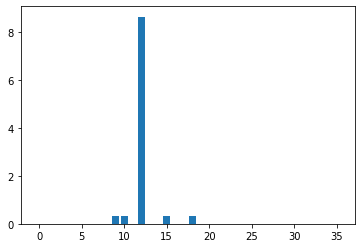

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0.01227265558783162, 0.32492056761140226, 0.32492056761140226, 0, 8.626870578218291, 0, 0, 0.32492056761140226, 0, 0, 0.32492056761140226, 0.01227265558783162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 7
value: 0.009122819567505713
x, y, scale, mag: 295 504 0.37797631323337555 10.0
Index: 4
value: 0.30204005640818093
x, y, scale, mag: 295 505 0.37797631323337555 10.0
Index: 1
value: 0.009122819567505713
x, y, scale, mag: 295 506 0.37797631323337555 10.0
Index: 9
value: 0.30204005640818093
x, y, scale, mag: 296 504 0.37797631323337555 10.0
Index: 9
value: 10.0
x, y, scale, mag: 296 505 0.37797631323337555 10.0
Index: 4
value: 0.30204005640818093
x, y, scale, mag: 296 506 0.37797631323337555 10.0
Index: 10
value: 0.009122819567505713
x, y, scale, mag: 297 504 0.37797631323337555 10.0
Index: 11
value: 0.30204005640818093
x, y, scale, mag: 297 505 0.37797631323337555 10.0
Index: 11
value: 0.009122819567505713
x, y, scale, mag: 297 506 0.37797

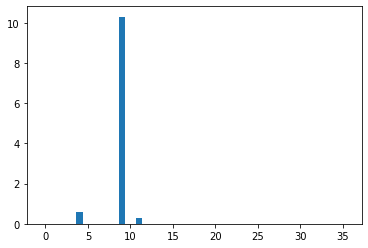

Histogram [0, 0.009122819567505713, 0, 0, 0.6040801128163619, 0, 0, 0.009122819567505713, 0, 10.302040056408181, 0.009122819567505713, 0.31116287597568665, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 32
value: 0.04841638292904301
x, y, scale, mag: 295 746 0.42114709317684174 13.601470508735444
Index: 31
value: 0.8115010810522809
x, y, scale, mag: 295 747 0.42114709317684174 13.601470508735444
Index: 31
value: 0.04841638292904301
x, y, scale, mag: 295 748 0.42114709317684174 13.601470508735444
Index: 30
value: 0.8115010810522809
x, y, scale, mag: 296 746 0.42114709317684174 13.601470508735444
Index: 29
value: 13.601470508735444
x, y, scale, mag: 296 747 0.42114709317684174 13.601470508735444
Index: 29
value: 0.8115010810522809
x, y, scale, mag: 296 748 0.42114709317684174 13.601470508735444
Index: 25
value: 0.04841638292904301
x, y, scale, mag: 297 746 0.42114709317684174 13.601470508735444
Index: 26
value: 0.8115010810522809
x, y, scale, mag: 297 747 

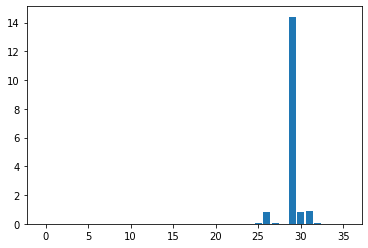

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04841638292904301, 0.8115010810522809, 0.04841638292904301, 0, 14.412971589787725, 0.8115010810522809, 0.859917463981324, 0.04841638292904301, 0, 0, 0]
Index: 9
value: 0.010378956049925992
x, y, scale, mag: 296 505 0.39310088753700256 6.708203932499369
Index: 4
value: 0.26386389254566767
x, y, scale, mag: 296 506 0.39310088753700256 6.708203932499369
Index: 35
value: 0.010378956049925992
x, y, scale, mag: 296 507 0.39310088753700256 6.708203932499369
Index: 11
value: 0.26386389254566767
x, y, scale, mag: 297 505 0.39310088753700256 6.708203932499369
Index: 11
value: 6.708203932499369
x, y, scale, mag: 297 506 0.39310088753700256 6.708203932499369
Index: 23
value: 0.26386389254566767
x, y, scale, mag: 297 507 0.39310088753700256 6.708203932499369
Index: 12
value: 0.010378956049925992
x, y, scale, mag: 298 505 0.39310088753700256 6.708203932499369
Index: 13
value: 0.26386389254566767
x, y, scale, mag:

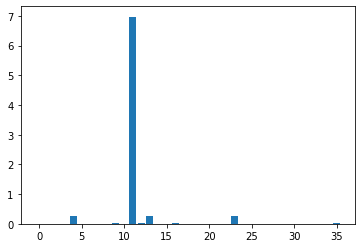

Histogram [0, 0, 0, 0, 0.26386389254566767, 0, 0, 0, 0, 0.010378956049925992, 0, 6.972067825045037, 0.010378956049925992, 0.26386389254566767, 0, 0, 0.010378956049925992, 0, 0, 0, 0, 0, 0, 0.26386389254566767, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010378956049925992]
Index: 28
value: 0.03349735355858573
x, y, scale, mag: 297 749 0.39058712124824524 23.53720459187964
Index: 28
value: 0.8879380969386096
x, y, scale, mag: 297 750 0.39058712124824524 23.53720459187964
Index: 29
value: 0.03349735355858573
x, y, scale, mag: 297 751 0.39058712124824524 23.53720459187964
Index: 25
value: 0.8879380969386096
x, y, scale, mag: 298 749 0.39058712124824524 23.53720459187964
Index: 26
value: 23.53720459187964
x, y, scale, mag: 298 750 0.39058712124824524 23.53720459187964
Index: 27
value: 0.8879380969386096
x, y, scale, mag: 298 751 0.39058712124824524 23.53720459187964
Index: 23
value: 0.03349735355858573
x, y, scale, mag: 299 749 0.39058712124824524 23.53720459187964
Index: 24
value: 0.88793809693860

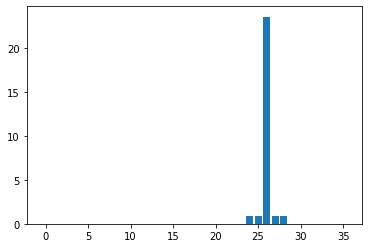

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03349735355858573, 0.8879380969386096, 0.9214354504971953, 23.53720459187964, 0.8879380969386096, 0.9214354504971953, 0.03349735355858573, 0, 0, 0, 0, 0, 0]
Index: 11
value: 0.027374981734655465
x, y, scale, mag: 311 689 0.3897293508052826 19.79898987322333
Index: 11
value: 0.7362044458872259
x, y, scale, mag: 311 690 0.3897293508052826 19.79898987322333
Index: 11
value: 0.027374981734655465
x, y, scale, mag: 311 691 0.3897293508052826 19.79898987322333
Index: 12
value: 0.7362044458872259
x, y, scale, mag: 312 689 0.3897293508052826 19.79898987322333
Index: 13
value: 19.79898987322333
x, y, scale, mag: 312 690 0.3897293508052826 19.79898987322333
Index: 14
value: 0.7362044458872259
x, y, scale, mag: 312 691 0.3897293508052826 19.79898987322333
Index: 13
value: 0.027374981734655465
x, y, scale, mag: 313 689 0.3897293508052826 19.79898987322333
Index: 14
value: 0.7362044458872259
x, y, scale, mag: 313 690 0

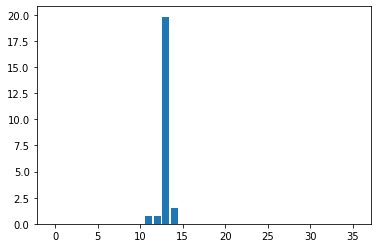

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7909544093565368, 0.7362044458872259, 19.826364854957987, 1.4724088917744518, 0.027374981734655465, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 0.018720732716032435
x, y, scale, mag: 335 68 0.4202655851840973 5.385164807134504
Index: 16
value: 0.3175125682333684
x, y, scale, mag: 335 69 0.4202655851840973 5.385164807134504
Index: 25
value: 0.018720732716032435
x, y, scale, mag: 335 70 0.4202655851840973 5.385164807134504
Index: 11
value: 0.3175125682333684
x, y, scale, mag: 336 68 0.4202655851840973 5.385164807134504
Index: 15
value: 5.385164807134504
x, y, scale, mag: 336 69 0.4202655851840973 5.385164807134504
Index: 25
value: 0.3175125682333684
x, y, scale, mag: 336 70 0.4202655851840973 5.385164807134504
Index: 11
value: 0.018720732716032435
x, y, scale, mag: 337 68 0.4202655851840973 5.385164807134504
Index: 15
value: 0.3175125682333684
x, y, scale, mag: 337 69 0.4202655851840973 5.385164807134504
Index

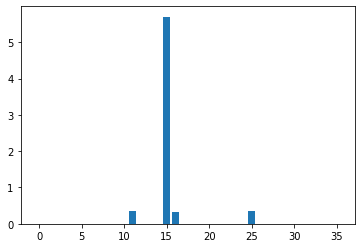

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3549540336654332, 0, 0, 0, 5.702677375367872, 0.3175125682333684, 0, 0, 0, 0, 0, 0, 0, 0, 0.3549540336654332, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 9
value: 0.005549194503589516
x, y, scale, mag: 337 88 0.37797631323337555 6.082762530298219
Index: 0
value: 0.18372379377688436
x, y, scale, mag: 337 89 0.37797631323337555 6.082762530298219
Index: 27
value: 0.005549194503589516
x, y, scale, mag: 337 90 0.37797631323337555 6.082762530298219
Index: 13
value: 0.18372379377688436
x, y, scale, mag: 338 88 0.37797631323337555 6.082762530298219
Index: 17
value: 6.082762530298219
x, y, scale, mag: 338 89 0.37797631323337555 6.082762530298219
Index: 22
value: 0.18372379377688436
x, y, scale, mag: 338 90 0.37797631323337555 6.082762530298219
Index: 15
value: 0.005549194503589516
x, y, scale, mag: 339 88 0.37797631323337555 6.082762530298219
Index: 18
value: 0.18372379377688436
x, y, scale, mag: 339 89 0.37797631323337555 6.082762530298219
Index: 20
value

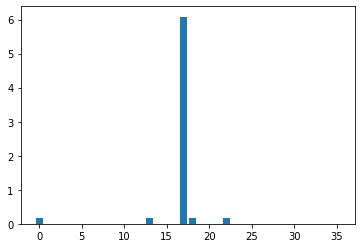

Histogram [0.18372379377688436, 0, 0, 0, 0, 0, 0, 0, 0, 0.005549194503589516, 0, 0, 0, 0.18372379377688436, 0, 0.005549194503589516, 0, 6.082762530298219, 0.18372379377688436, 0, 0.005549194503589516, 0, 0.18372379377688436, 0, 0, 0, 0, 0.005549194503589516, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 0.011859665437757426
x, y, scale, mag: 338 87 0.37797631323337555 13.0
Index: 13
value: 0.39265207333063523
x, y, scale, mag: 338 88 0.37797631323337555 13.0
Index: 17
value: 0.011859665437757426
x, y, scale, mag: 338 89 0.37797631323337555 13.0
Index: 13
value: 0.39265207333063523
x, y, scale, mag: 339 87 0.37797631323337555 13.0
Index: 15
value: 13.0
x, y, scale, mag: 339 88 0.37797631323337555 13.0
Index: 18
value: 0.39265207333063523
x, y, scale, mag: 339 89 0.37797631323337555 13.0
Index: 15
value: 0.011859665437757426
x, y, scale, mag: 340 87 0.37797631323337555 13.0
Index: 16
value: 0.39265207333063523
x, y, scale, mag: 340 88 0.37797631323337555 13.0
Index: 18
value: 0.01185966543775

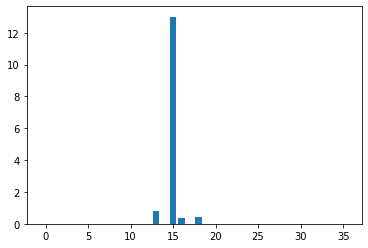

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.011859665437757426, 0, 0.7853041466612705, 0, 13.011859665437758, 0.39265207333063523, 0.011859665437757426, 0.40451173876839264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 19
value: 0.01935275606517231
x, y, scale, mag: 363 59 0.39304813742637634 12.529964086141668
Index: 24
value: 0.492432064821605
x, y, scale, mag: 363 60 0.39304813742637634 12.529964086141668
Index: 26
value: 0.01935275606517231
x, y, scale, mag: 363 61 0.39304813742637634 12.529964086141668
Index: 16
value: 0.492432064821605
x, y, scale, mag: 364 59 0.39304813742637634 12.529964086141668
Index: 21
value: 12.529964086141668
x, y, scale, mag: 364 60 0.39304813742637634 12.529964086141668
Index: 25
value: 0.492432064821605
x, y, scale, mag: 364 61 0.39304813742637634 12.529964086141668
Index: 16
value: 0.01935275606517231
x, y, scale, mag: 365 59 0.39304813742637634 12.529964086141668
Index: 19
value: 0.492432064821605
x, y, scale, mag: 365 60 0.39304813742

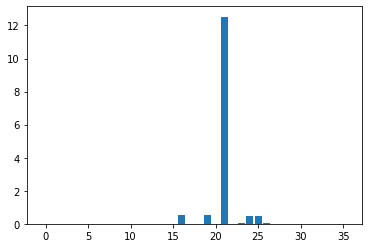

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5117848208867773, 0, 0, 0.5117848208867773, 0, 12.529964086141668, 0, 0.01935275606517231, 0.492432064821605, 0.492432064821605, 0.01935275606517231, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 21
value: 0.02536413737641624
x, y, scale, mag: 364 60 0.39331434667110443 16.278820596099706
Index: 25
value: 0.6425715850592112
x, y, scale, mag: 364 61 0.39331434667110443 16.278820596099706
Index: 27
value: 0.02536413737641624
x, y, scale, mag: 364 62 0.39331434667110443 16.278820596099706
Index: 19
value: 0.6425715850592112
x, y, scale, mag: 365 60 0.39331434667110443 16.278820596099706
Index: 23
value: 16.278820596099706
x, y, scale, mag: 365 61 0.39331434667110443 16.278820596099706
Index: 26
value: 0.6425715850592112
x, y, scale, mag: 365 62 0.39331434667110443 16.278820596099706
Index: 17
value: 0.02536413737641624
x, y, scale, mag: 366 60 0.39331434667110443 16.278820596099706
Index: 21
value: 0.6425715850592112
x, y, scale, mag: 366 6

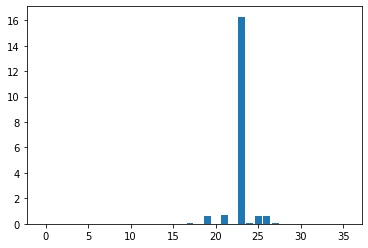

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02536413737641624, 0, 0.6425715850592112, 0, 0.6679357224356275, 0, 16.278820596099706, 0.02536413737641624, 0.6425715850592112, 0.6425715850592112, 0.02536413737641624, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 0.01381430049724672
x, y, scale, mag: 427 88 0.38587845861911774 11.40175425099138
Index: 33
value: 0.3968718425625017
x, y, scale, mag: 427 89 0.38587845861911774 11.40175425099138
Index: 31
value: 0.01381430049724672
x, y, scale, mag: 427 90 0.38587845861911774 11.40175425099138
Index: 0
value: 0.3968718425625017
x, y, scale, mag: 428 88 0.38587845861911774 11.40175425099138
Index: 31
value: 11.40175425099138
x, y, scale, mag: 428 89 0.38587845861911774 11.40175425099138
Index: 29
value: 0.3968718425625017
x, y, scale, mag: 428 90 0.38587845861911774 11.40175425099138
Index: 34
value: 0.01381430049724672
x, y, scale, mag: 429 88 0.38587845861911774 11.40175425099138
Index: 28
value: 0.3968718425625017
x, y, scale, 

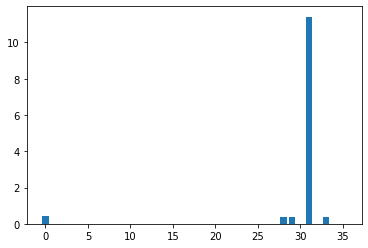

Histogram [0.41068614305974843, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01381430049724672, 0.3968718425625017, 0.3968718425625017, 0, 11.415568551488626, 0, 0.3968718425625017, 0.01381430049724672, 0]
Index: 5
value: 0.005555371328040904
x, y, scale, mag: 429 86 0.3929746448993683 3.605551275463989
Index: 3
value: 0.1415280049230327
x, y, scale, mag: 429 87 0.3929746448993683 3.605551275463989
Index: 34
value: 0.005555371328040904
x, y, scale, mag: 429 88 0.3929746448993683 3.605551275463989
Index: 7
value: 0.1415280049230327
x, y, scale, mag: 430 86 0.3929746448993683 3.605551275463989
Index: 5
value: 3.605551275463989
x, y, scale, mag: 430 87 0.3929746448993683 3.605551275463989
Index: 27
value: 0.1415280049230327
x, y, scale, mag: 430 88 0.3929746448993683 3.605551275463989
Index: 8
value: 0.005555371328040904
x, y, scale, mag: 431 86 0.3929746448993683 3.605551275463989
Index: 15
value: 0.1415280049230327
x, y, scale, mag: 431 87 0.3929746448

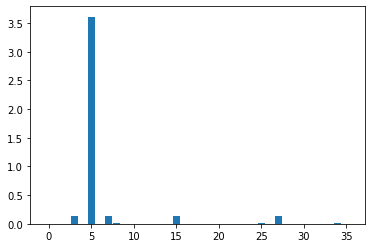

Histogram [0, 0, 0, 0.1415280049230327, 0, 3.61110664679203, 0, 0.1415280049230327, 0.005555371328040904, 0, 0, 0, 0, 0, 0, 0.1415280049230327, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.005555371328040904, 0, 0.1415280049230327, 0, 0, 0, 0, 0, 0, 0.005555371328040904, 0]
Index: 4
value: 0.0025803230318898465
x, y, scale, mag: 969 557 0.37797631323337555 2.8284271247461903
Index: 1
value: 0.08542982883047684
x, y, scale, mag: 969 558 0.37797631323337555 2.8284271247461903
Index: 33
value: 0.0025803230318898465
x, y, scale, mag: 969 559 0.37797631323337555 2.8284271247461903
Index: 7
value: 0.08542982883047684
x, y, scale, mag: 970 557 0.37797631323337555 2.8284271247461903
Index: 4
value: 2.8284271247461903
x, y, scale, mag: 970 558 0.37797631323337555 2.8284271247461903
Index: 28
value: 0.08542982883047684
x, y, scale, mag: 970 559 0.37797631323337555 2.8284271247461903
Index: 12
value: 0.0025803230318898465
x, y, scale, mag: 971 557 0.37797631323337555 2.8284271247461903
Index: 17
value: 0.0854298

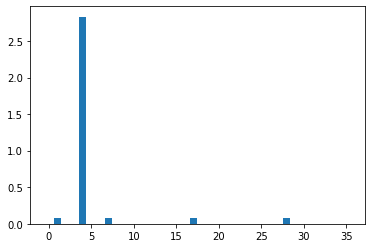

Histogram [0, 0.08542982883047684, 0, 0, 2.83100744777808, 0, 0, 0.08542982883047684, 0, 0, 0, 0, 0.0025803230318898465, 0, 0, 0, 0, 0.08542982883047684, 0, 0, 0, 0, 0, 0.0025803230318898465, 0, 0, 0, 0, 0.08542982883047684, 0, 0, 0, 0, 0.0025803230318898465, 0, 0]
Index: 0
value: 4.0
x, y, scale, mag: 132 517 0.23811015486717224 4.0


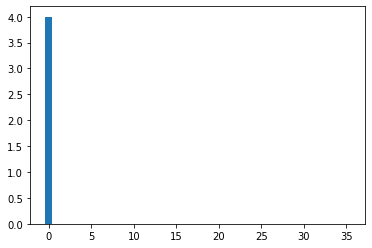

Histogram [4.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 2.0
x, y, scale, mag: 133 519 0.2375347763299942 2.0


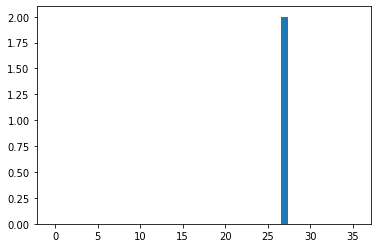

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 18
value: 1.0
x, y, scale, mag: 162 609 0.2644773870706558 1.0


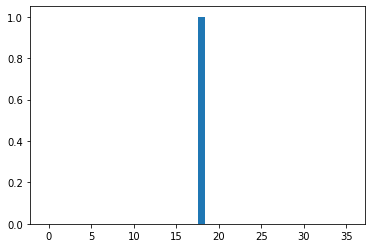

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 15
value: 17.08800749063506
x, y, scale, mag: 164 608 0.23811015486717224 17.08800749063506


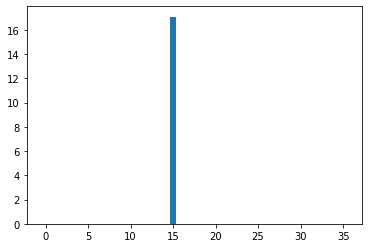

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.08800749063506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 1
value: 13.601470508735444
x, y, scale, mag: 177 599 0.24755850434303284 13.601470508735444


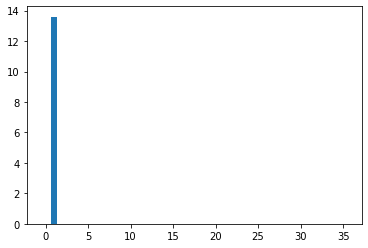

Histogram [0, 13.601470508735444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 32
value: 17.029386365926403
x, y, scale, mag: 213 655 0.22911527752876282 17.029386365926403


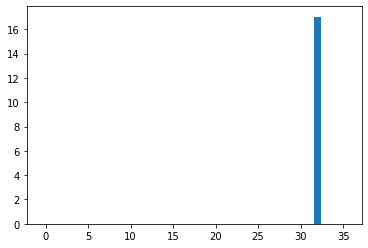

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.029386365926403, 0, 0, 0]
Index: 30
value: 4.47213595499958
x, y, scale, mag: 215 654 0.23811015486717224 4.47213595499958


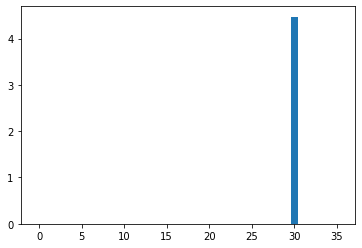

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.47213595499958, 0, 0, 0, 0, 0]
Index: 6
value: 10.770329614269007
x, y, scale, mag: 216 593 0.24202542006969452 10.770329614269007


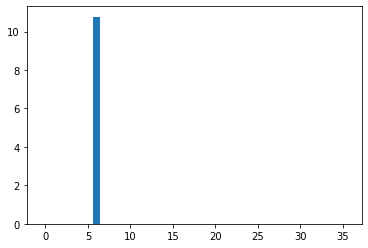

Histogram [0, 0, 0, 0, 0, 0, 10.770329614269007, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 9
value: 8.0
x, y, scale, mag: 217 593 0.24745816737413406 8.0


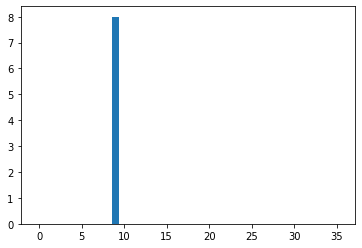

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 8.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 16
value: 6.324555320336759
x, y, scale, mag: 217 686 0.23811015486717224 6.324555320336759


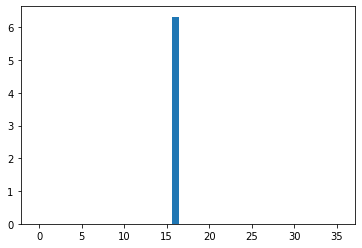

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.324555320336759, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 33
value: 19.72308292331602
x, y, scale, mag: 259 720 0.23549745976924896 19.72308292331602


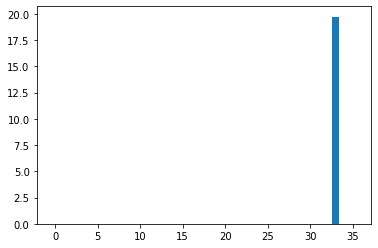

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19.72308292331602, 0, 0]
Index: 33
value: 20.808652046684813
x, y, scale, mag: 260 721 0.23416981101036072 20.808652046684813


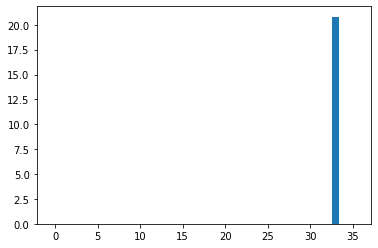

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20.808652046684813, 0, 0]
Index: 34
value: 9.848857801796104
x, y, scale, mag: 262 721 0.2644773870706558 9.848857801796104


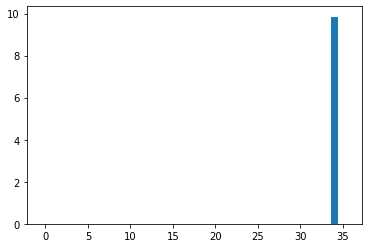

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.848857801796104, 0]
Index: 34
value: 5.385164807134504
x, y, scale, mag: 264 722 0.24487922340631485 5.385164807134504


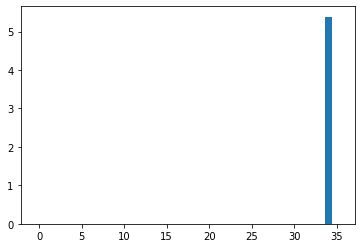

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.385164807134504, 0]
Index: 35
value: 9.219544457292887
x, y, scale, mag: 271 71 0.22911527752876282 9.219544457292887


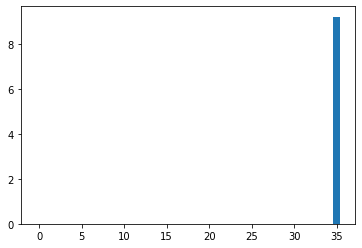

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.219544457292887]
Index: 29
value: 3.1622776601683795
x, y, scale, mag: 278 71 0.23811015486717224 3.1622776601683795


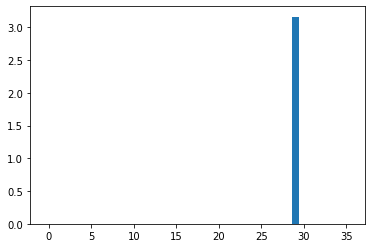

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.1622776601683795, 0, 0, 0, 0, 0, 0]
Index: 27
value: 8.06225774829855
x, y, scale, mag: 298 71 0.24832597374916077 8.06225774829855


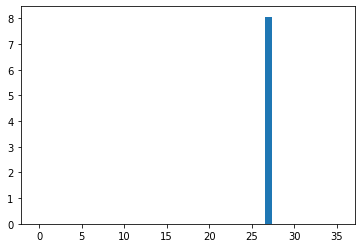

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.06225774829855, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 8.06225774829855
x, y, scale, mag: 300 71 0.2476380318403244 8.06225774829855


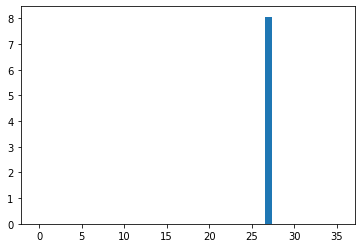

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.06225774829855, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 13
value: 2.8284271247461903
x, y, scale, mag: 301 566 0.2561328560113907 2.8284271247461903


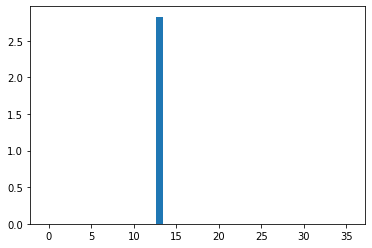

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.8284271247461903, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 33
value: 11.661903789690601
x, y, scale, mag: 311 672 0.23811015486717224 11.661903789690601


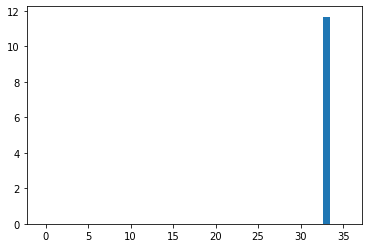

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.661903789690601, 0, 0]
Index: 14
value: 16.401219466856727
x, y, scale, mag: 312 691 0.2204601690173149 16.401219466856727


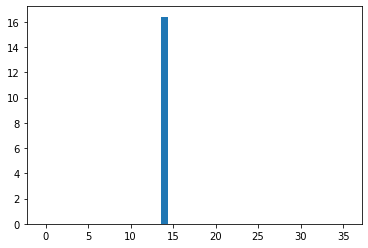

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16.401219466856727, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 25
value: 6.708203932499369
x, y, scale, mag: 313 671 0.23582886904478073 6.708203932499369


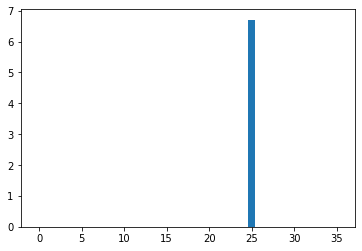

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.708203932499369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 24
value: 9.433981132056603
x, y, scale, mag: 336 70 0.2560751885175705 9.433981132056603


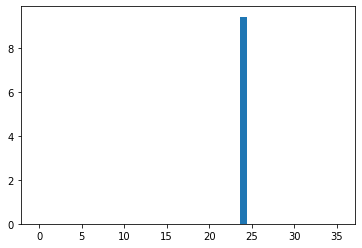

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.433981132056603, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 14
value: 8.602325267042627
x, y, scale, mag: 338 88 0.22911527752876282 8.602325267042627


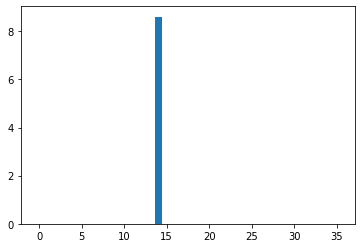

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.602325267042627, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 17
value: 11.045361017187261
x, y, scale, mag: 339 89 0.23811015486717224 11.045361017187261


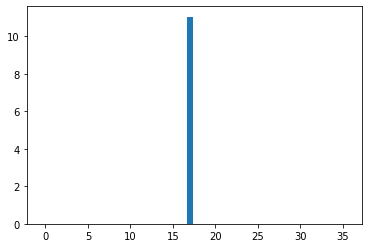

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.045361017187261, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 25
value: 13.416407864998739
x, y, scale, mag: 362 60 0.24516183882951736 13.416407864998739


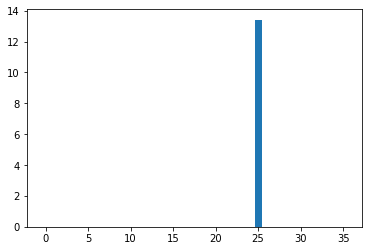

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.416407864998739, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 19
value: 12.165525060596439
x, y, scale, mag: 363 59 0.23811015486717224 12.165525060596439


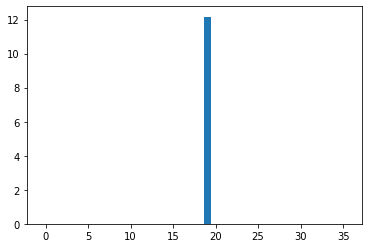

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.165525060596439, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 34
value: 5.385164807134504
x, y, scale, mag: 429 88 0.23811015486717224 5.385164807134504


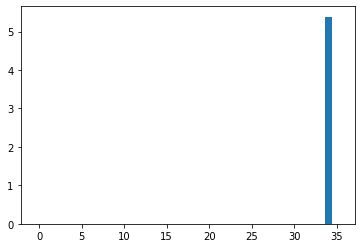

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.385164807134504, 0]
Index: 19
value: 0.025733238805017947
x, y, scale, mag: 7 728 1.5600210428237915 18.439088914585774
Index: 20
value: 0.10841248413303853
x, y, scale, mag: 7 729 1.5600210428237915 18.439088914585774
Index: 20
value: 0.30283866873189824
x, y, scale, mag: 7 730 1.5600210428237915 18.439088914585774
Index: 20
value: 0.560906596975433
x, y, scale, mag: 7 731 1.5600210428237915 18.439088914585774
Index: 20
value: 0.6888377736346889
x, y, scale, mag: 7 732 1.5600210428237915 18.439088914585774
Index: 19
value: 0.560906596975433
x, y, scale, mag: 7 733 1.5600210428237915 18.439088914585774
Index: 19
value: 0.30283866873189824
x, y, scale, mag: 7 734 1.5600210428237915 18.439088914585774
Index: 17
value: 0.10841248413303853
x, y, scale, mag: 7 735 1.5600210428237915 18.439088914585774
Index: 17
value: 0.025733238805017947
x, y, scale, mag: 7 736 1.5600210428237

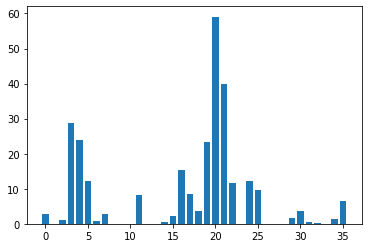

Histogram [2.66590217602963, 0, 0.9978909886453877, 28.766804964138252, 23.97860373537353, 12.2260634549123, 0.6888377736346889, 2.90202934695675, 0, 0, 0, 8.10650831480629, 0, 0, 0.560906596975433, 2.3630635072977317, 15.317413958113066, 8.57609786838361, 3.5639221309921094, 23.355410287739375, 59.06779818997802, 39.768589321277936, 11.697375435397728, 0, 12.2260634549123, 9.524935042967794, 0, 0, 0, 1.5786785510542645, 3.5639221309921094, 0.5908805632335762, 0.10841248413303853, 0, 1.2758398823223662, 6.600964938694629]
Index: 21
value: 0.018208951465011336
x, y, scale, mag: 41 751 1.5551117062568665 13.601470508735444
Index: 21
value: 0.07741400137643817
x, y, scale, mag: 41 752 1.5551117062568665 13.601470508735444
Index: 20
value: 0.2176570734708825
x, y, scale, mag: 41 753 1.5551117062568665 13.601470508735444
Index: 19
value: 0.40471075650000843
x, y, scale, mag: 41 754 1.5551117062568665 13.601470508735444
Index: 17
value: 0.49766305503457525
x, y, scale, mag: 41 755 1.55511170

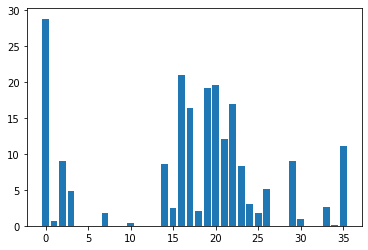

Histogram [28.823314266073865, 0.6223678299708909, 8.995070185207243, 4.837629395148919, 0, 0, 0, 1.7205976478630534, 0, 0, 0.40471075650000843, 0, 0, 0, 8.562156655504616, 2.4385884306753938, 20.975267311421007, 16.4556710397538, 2.1157774241683978, 19.135045412762516, 19.582109819205762, 12.02153346367461, 16.901417070473688, 8.291681654135587, 3.0181512357029816, 1.7205976478630534, 5.055286468619801, 0, 0, 8.995070185207243, 0.9253528418505187, 0, 0, 2.6017204627592028, 0.07741400137643817, 11.061020832097812]
Index: 17
value: 0.016561519447842225
x, y, scale, mag: 45 687 1.5620947480201721 11.661903789690601
Index: 17
value: 0.06950688614441686
x, y, scale, mag: 45 688 1.5620947480201721 11.661903789690601
Index: 19
value: 0.1936315656900778
x, y, scale, mag: 45 689 1.5620947480201721 11.661903789690601
Index: 19
value: 0.35805121492857434
x, y, scale, mag: 45 690 1.5620947480201721 11.661903789690601
Index: 19
value: 0.43947564939576095
x, y, scale, mag: 45 691 1.5620947480201721

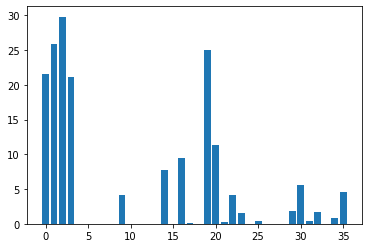

Histogram [21.618061979247837, 25.92656961221097, 29.79904446469669, 21.163132870345876, 0, 0, 0, 0, 0, 4.186211148210036, 0, 0, 0, 0, 7.740876247229311, 0, 9.501229080655275, 0.15557529173667595, 0, 24.98372317474987, 11.371430209555012, 0.1936315656900778, 4.186211148210036, 1.5027017966731933, 0, 0.35805121492857434, 0, 0, 0, 1.8444312444879376, 5.577673164615417, 0.35805121492857434, 1.696333362363271, 0, 0.8821573940142691, 4.5442623631386105]
Index: 17
value: 0.020545988947338178
x, y, scale, mag: 62 760 1.576830267906189 12.806248474865697
Index: 17
value: 0.08395886401039199
x, y, scale, mag: 62 761 1.576830267906189 12.806248474865697
Index: 18
value: 0.22947618851363533
x, y, scale, mag: 62 762 1.576830267906189 12.806248474865697
Index: 18
value: 0.419508024204268
x, y, scale, mag: 62 763 1.576830267906189 12.806248474865697
Index: 19
value: 0.5129493538561649
x, y, scale, mag: 62 764 1.576830267906189 12.806248474865697
Index: 19
value: 0.419508024204268
x, y, scale, mag: 6

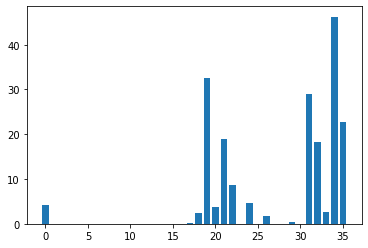

Histogram [4.24625271433325, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.10450485295773017, 2.4472152514924823, 32.618324006821055, 3.730202358674611, 19.038915738125255, 8.565515284897913, 0, 4.6854450614193075, 0, 1.7142721747641871, 0, 0, 0.419508024204268, 0, 29.008731277214743, 18.298592420387543, 2.60905897189466, 46.25233273631537, 22.825317302708203]
Index: 14
value: 0.003761434868027768
x, y, scale, mag: 152 555 1.5119052529335022 4.123105625617661
Index: 15
value: 0.0173910301763038
x, y, scale, mag: 152 556 1.5119052529335022 4.123105625617661
Index: 15
value: 0.05191646804199054
x, y, scale, mag: 152 557 1.5119052529335022 4.123105625617661
Index: 15
value: 0.10006749710362693
x, y, scale, mag: 152 558 1.5119052529335022 4.123105625617661
Index: 15
value: 0.12453430557384464
x, y, scale, mag: 152 559 1.5119052529335022 4.123105625617661
Index: 15
value: 0.10006749710362693
x, y, scale, mag: 152 560 1.5119052529335022 4.123105625617661
Index: 16
value: 0.05191646804199

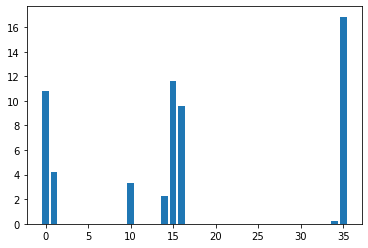

Histogram [10.769172271192817, 4.223173122721287, 0, 0, 0.0173910301763038, 0, 0, 0, 0, 0, 3.313053847678878, 0.003761434868027768, 0, 0, 2.2984073517867842, 11.640842186069696, 9.588151502547031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22836323754549934, 16.84716047597981]
Index: 21
value: 0.009285417123372833
x, y, scale, mag: 200 675 1.4974198937416077 11.661903789690601
Index: 21
value: 0.04422834371223647
x, y, scale, mag: 200 676 1.4974198937416077 11.661903789690601
Index: 21
value: 0.13486971246539073
x, y, scale, mag: 200 677 1.4974198937416077 11.661903789690601
Index: 20
value: 0.2632950443258482
x, y, scale, mag: 200 678 1.4974198937416077 11.661903789690601
Index: 19
value: 0.32906783668404854
x, y, scale, mag: 200 679 1.4974198937416077 11.661903789690601
Index: 17
value: 0.2632950443258482
x, y, scale, mag: 200 680 1.4974198937416077 11.661903789690601
Index: 16
value: 0.13486971246539073
x, y, scale, mag: 200 681 1.4974198937416077 11.661903789690601
Index:

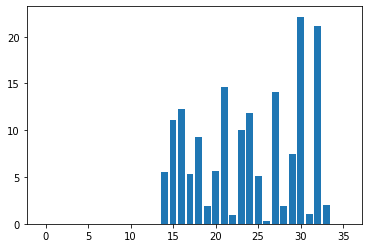

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.489546968116954, 11.046226473881932, 12.246643470279425, 5.341756250044176, 9.330968064735226, 1.8964853465414364, 5.68538301792329, 14.597812743754552, 0.8973090703581748, 10.067311189611047, 11.796773502155991, 5.078461205718328, 0.30752338803808466, 14.110643972182746, 1.8964853465414364, 7.465930657229218, 22.138654972008617, 0.9972358562347018, 21.165717325043616, 2.0190960274842364, 0, 0]
Index: 19
value: 0.013997123986908975
x, y, scale, mag: 288 694 1.5722873210906982 9.055385138137417
Index: 19
value: 0.05766551966443248
x, y, scale, mag: 288 695 1.5722873210906982 9.055385138137417
Index: 19
value: 0.15853105628946046
x, y, scale, mag: 288 696 1.5722873210906982 9.055385138137417
Index: 19
value: 0.29082600614547455
x, y, scale, mag: 288 697 1.5722873210906982 9.055385138137417
Index: 19
value: 0.35601874743856154
x, y, scale, mag: 288 698 1.5722873210906982 9.055385138137417
Index: 19
value: 0.29082600614547455
x, y, sca

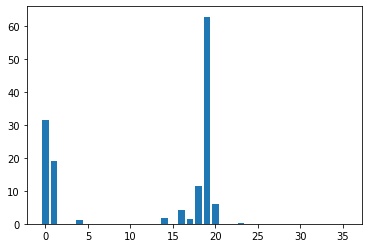

Histogram [31.44518534222935, 19.106234480223275, 0, 0, 1.1981484762152004, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.8227490629323726, 0, 4.032258922838164, 1.488974482360675, 11.344204729024966, 62.76617206419108, 6.14583399191601, 0, 0, 0.29082600614547455, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.002407903983821116
x, y, scale, mag: 289 690 1.5044910907745361 2.8284271247461903
Index: 20
value: 0.01130267045123653
x, y, scale, mag: 289 691 1.5044910907745361 2.8284271247461903
Index: 20
value: 0.034107811240640544
x, y, scale, mag: 289 692 1.5044910907745361 2.8284271247461903
Index: 20
value: 0.06616944960965296
x, y, scale, mag: 289 693 1.5044910907745361 2.8284271247461903
Index: 19
value: 0.08252624395684113
x, y, scale, mag: 289 694 1.5044910907745361 2.8284271247461903
Index: 19
value: 0.06616944960965296
x, y, scale, mag: 289 695 1.5044910907745361 2.8284271247461903
Index: 19
value: 0.034107811240640544
x, y, scale, mag: 289 696 1.5044910907745361 2.8284271247461903
Index:

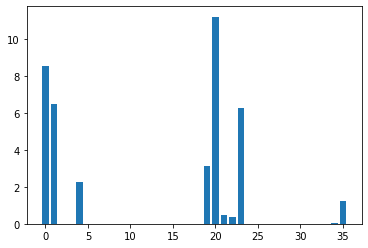

Histogram [8.562013506990464, 6.461673829601944, 0, 0, 2.267829688254631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.1103472958850373, 11.211743683019145, 0.45929424230545834, 0.38737713184988065, 6.265235962581439, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06616944960965296, 1.2478847164380764]
Index: 11
value: 0.002534565325863377
x, y, scale, mag: 307 31 1.50997656583786 2.8284271247461903
Index: 13
value: 0.011764543185075938
x, y, scale, mag: 307 32 1.50997656583786 2.8284271247461903
Index: 14
value: 0.035218353904922534
x, y, scale, mag: 307 33 1.50997656583786 2.8284271247461903
Index: 15
value: 0.06799632552165664
x, y, scale, mag: 307 34 1.50997656583786 2.8284271247461903
Index: 15
value: 0.08466896312766055
x, y, scale, mag: 307 35 1.50997656583786 2.8284271247461903
Index: 15
value: 0.06799632552165664
x, y, scale, mag: 307 36 1.50997656583786 2.8284271247461903
Index: 14
value: 0.035218353904922534
x, y, scale, mag: 307 37 1.50997656583786 2.8284271247461903
Index: 14
value: 0.011

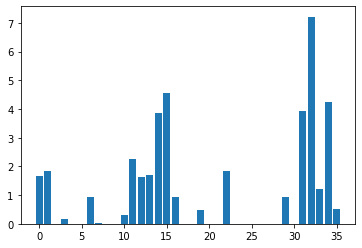

Histogram [1.6640334301892516, 1.8359433233757745, 0, 0.16347096726757748, 0, 0, 0.9448242000392241, 0.035218353904922534, 0, 0, 0.31561455523089205, 2.27400033488476, 1.6374935251997447, 1.689929241407959, 3.876798038746551, 4.540710105906428, 0.9448242000392241, 0, 0, 0.4893669297515006, 0, 0, 1.8241787801906986, 0, 0, 0, 0, 0, 0, 0.9448242000392241, 0, 3.9270455326139904, 7.2156750573586, 1.2232743899184566, 4.259792203894456, 0.517797306296071]
Index: 20
value: 0.003970620650559682
x, y, scale, mag: 8 730 1.0690784454345703 10.44030650891055
Index: 20
value: 0.03538490859323405
x, y, scale, mag: 8 731 1.0690784454345703 10.44030650891055
Index: 20
value: 0.13146007833610232
x, y, scale, mag: 8 732 1.0690784454345703 10.44030650891055
Index: 19
value: 0.2036037735958076
x, y, scale, mag: 8 733 1.0690784454345703 10.44030650891055
Index: 19
value: 0.13146007833610232
x, y, scale, mag: 8 734 1.0690784454345703 10.44030650891055
Index: 17
value: 0.03538490859323405
x, y, scale, mag: 8 

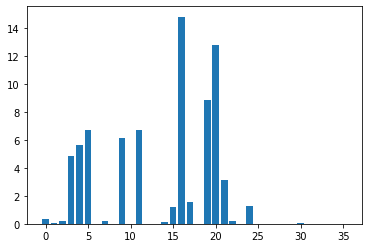

Histogram [0.3153390530961551, 0.03538490859323405, 0.17081560757989603, 4.843300727065455, 5.655396254063413, 6.7409532115988275, 0, 0.2036037735958076, 0, 6.166857846419516, 0, 6.7409532115988275, 0, 0, 0.13146007833610232, 1.1715304142506502, 14.828097178980444, 1.526224996590599, 0, 8.890469148473594, 12.786428956595422, 3.1174425775296086, 0.2036037735958076, 0, 1.3029904925867526, 0, 0, 0, 0, 0, 0.03538490859323405, 0, 0, 0, 0.003970620650559682, 0]
Index: 20
value: 0.11978078652269203
x, y, scale, mag: 9 732 0.952440619468689 9.848857801796104
Index: 19
value: 0.625909690517063
x, y, scale, mag: 9 733 0.952440619468689 9.848857801796104
Index: 17
value: 1.0861417650791672
x, y, scale, mag: 9 734 0.952440619468689 9.848857801796104
Index: 17
value: 0.625909690517063
x, y, scale, mag: 9 735 0.952440619468689 9.848857801796104
Index: 16
value: 0.11978078652269203
x, y, scale, mag: 9 736 0.952440619468689 9.848857801796104
Index: 20
value: 0.625909690517063
x, y, scale, mag: 10 732 

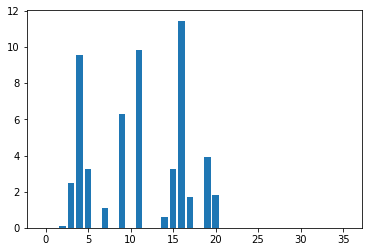

Histogram [0, 0, 0.11978078652269203, 2.4577419326359853, 9.57216582917178, 3.270665956171089, 0, 1.0861417650791672, 0, 6.301499873000692, 0, 9.848857801796104, 0, 0, 0.625909690517063, 3.270665956171089, 11.470961151489949, 1.7120514555962303, 0, 3.8965756466881523, 1.8318322421189221, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 21
value: 0.1360084452170825
x, y, scale, mag: 10 731 0.9431222677230835 12.206555615733702
Index: 20
value: 0.734431165510672
x, y, scale, mag: 10 732 0.9431222677230835 12.206555615733702
Index: 19
value: 1.2884854095998868
x, y, scale, mag: 10 733 0.9431222677230835 12.206555615733702
Index: 16
value: 0.734431165510672
x, y, scale, mag: 10 734 0.9431222677230835 12.206555615733702
Index: 15
value: 0.1360084452170825
x, y, scale, mag: 10 735 0.9431222677230835 12.206555615733702
Index: 21
value: 0.734431165510672
x, y, scale, mag: 11 731 0.9431222677230835 12.206555615733702
Index: 20
value: 3.965850326517938
x, y, scale, mag: 11 732 0.9431222677230

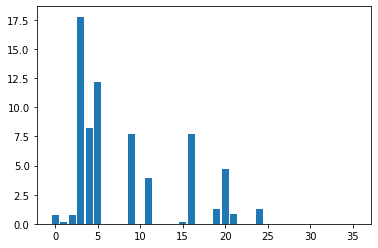

Histogram [0.734431165510672, 0.1360084452170825, 0.734431165510672, 17.782741265054845, 8.246169835780544, 12.206555615733702, 0, 0, 0, 7.692115591691329, 0, 3.965850326517938, 0, 0, 0, 0.1360084452170825, 7.692115591691329, 0, 0, 1.2884854095998868, 4.70028149202861, 0.8704396107277546, 0, 0, 1.2884854095998868, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.1484386779943442
x, y, scale, mag: 43 754 0.9620566964149475 11.180339887498949
Index: 19
value: 0.7505636906116228
x, y, scale, mag: 43 755 0.9620566964149475 11.180339887498949
Index: 17
value: 1.2882526430897703
x, y, scale, mag: 43 756 0.9620566964149475 11.180339887498949
Index: 16
value: 0.7505636906116228
x, y, scale, mag: 43 757 0.9620566964149475 11.180339887498949
Index: 15
value: 0.1484386779943442
x, y, scale, mag: 43 758 0.9620566964149475 11.180339887498949
Index: 21
value: 0.7505636906116228
x, y, scale, mag: 44 754 0.9620566964149475 11.180339887498949
Index: 19
value: 3.7951419486907874
x, y, scale, mag: 44 

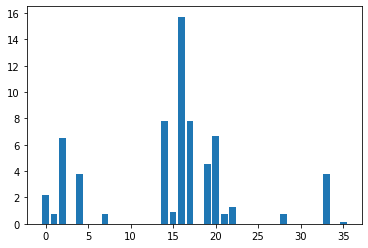

Histogram [2.187255011695737, 0.7505636906116228, 6.513906424540354, 0, 3.7951419486907874, 0, 0, 0.7505636906116228, 0, 0, 0, 0, 0, 0, 7.802159067630125, 0.8990023686059669, 15.726045526801359, 7.802159067630125, 0, 4.54570563930241, 6.662345102534698, 0.7505636906116228, 1.2882526430897703, 0, 0, 0, 0, 0, 0.7505636906116228, 0, 0, 0, 0, 3.7951419486907874, 0, 0.1484386779943442]
Index: 21
value: 0.11109987528373948
x, y, scale, mag: 45 699 0.9933038949966431 6.4031242374328485
Index: 21
value: 0.5081219490372586
x, y, scale, mag: 45 700 0.9933038949966431 6.4031242374328485
Index: 21
value: 0.8434371963608666
x, y, scale, mag: 45 701 0.9933038949966431 6.4031242374328485
Index: 20
value: 0.5081219490372586
x, y, scale, mag: 45 702 0.9933038949966431 6.4031242374328485
Index: 17
value: 0.11109987528373948
x, y, scale, mag: 45 703 0.9933038949966431 6.4031242374328485
Index: 22
value: 0.5081219490372586
x, y, scale, mag: 46 699 0.9933038949966431 6.4031242374328485
Index: 22
value: 2.3

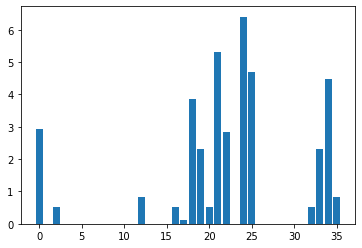

Histogram [2.9431480612680043, 0, 0.5081219490372586, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8434371963608666, 0, 0, 0, 0.5081219490372586, 0.11109987528373948, 3.857510649862355, 2.323926236947006, 0.5081219490372586, 5.320169670544219, 2.8320481859842648, 0, 6.4031242374328485, 4.7009478462232215, 0, 0, 0, 0, 0, 0, 0.5081219490372586, 2.323926236947006, 4.476732474183353, 0.8434371963608666]
Index: 19
value: 0.001310316787525999
x, y, scale, mag: 63 763 1.0446606874465942 5.0
Index: 19
value: 0.01294981141137976
x, y, scale, mag: 63 764 1.0446606874465942 5.0
Index: 19
value: 0.05119124913102671
x, y, scale, mag: 63 765 1.0446606874465942 5.0
Index: 19
value: 0.08094185528902828
x, y, scale, mag: 63 766 1.0446606874465942 5.0
Index: 18
value: 0.05119124913102671
x, y, scale, mag: 63 767 1.0446606874465942 5.0
Index: 20
value: 0.01294981141137976
x, y, scale, mag: 64 763 1.0446606874465942 5.0
Index: 20
value: 0.12798249796290123
x, y, scale, mag: 64 764 1.0446606874465942 5.0
Index: 19
value: 

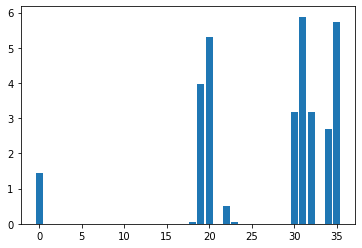

Histogram [1.437999593905072, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05119124913102671, 3.9581125364864276, 5.303087546348826, 0, 0.5059211852207155, 0.05119124913102671, 0, 0, 0, 0, 0, 0, 3.162223607812811, 5.88088715955333, 3.162223607812811, 0, 2.699286689675284, 5.732217482737668]
Index: 20
value: 0.09729516980200323
x, y, scale, mag: 65 687 0.952440619468689 8.0
Index: 20
value: 0.5084120031891762
x, y, scale, mag: 65 688 0.952440619468689 8.0
Index: 19
value: 0.8822479007716741
x, y, scale, mag: 65 689 0.952440619468689 8.0
Index: 17
value: 0.5084120031891762
x, y, scale, mag: 65 690 0.952440619468689 8.0
Index: 17
value: 0.09729516980200323
x, y, scale, mag: 65 691 0.952440619468689 8.0
Index: 24
value: 0.5084120031891762
x, y, scale, mag: 66 687 0.952440619468689 8.0
Index: 22
value: 2.6566865088251177
x, y, scale, mag: 66 688 0.952440619468689 8.0
Index: 20
value: 4.610150981323816
x, y, scale, mag: 66 689 0.952440619468689 8.0
Index: 19
value: 2.6566865088251177

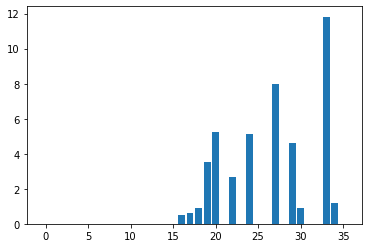

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5084120031891762, 0.6057071729911795, 0.8822479007716741, 3.538934409596792, 5.215858154314995, 0, 2.6566865088251177, 0, 5.118562984512992, 0, 0, 8.0, 0, 4.610150981323816, 0.8822479007716741, 0, 0, 11.822595906124079, 1.211414345982359, 0]
Index: 22
value: 0.001371250579548648
x, y, scale, mag: 121 525 1.0690784454345703 3.605551275463989
Index: 22
value: 0.01222014911167823
x, y, scale, mag: 121 526 1.0690784454345703 3.605551275463989
Index: 22
value: 0.045399630050400715
x, y, scale, mag: 121 527 1.0690784454345703 3.605551275463989
Index: 20
value: 0.07031439593761979
x, y, scale, mag: 121 528 1.0690784454345703 3.605551275463989
Index: 19
value: 0.045399630050400715
x, y, scale, mag: 121 529 1.0690784454345703 3.605551275463989
Index: 17
value: 0.01222014911167823
x, y, scale, mag: 121 530 1.0690784454345703 3.605551275463989
Index: 16
value: 0.001371250579548648
x, y, scale, mag: 121 531 1.0690784454345703 3.605551275

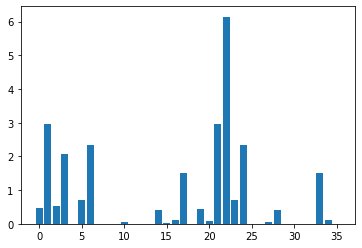

Histogram [0.4622068452353971, 2.954602190340878, 0.5338924917525656, 2.0742086820933103, 0, 0.6969339327826812, 2.3279826534958166, 0, 0, 0, 0.045399630050400715, 0, 0, 0, 0.4045870660733182, 0.01222014911167823, 0.11027333349484153, 1.5153199030542985, 0, 0.4499866961237189, 0.07031439593761979, 2.954602190340878, 6.143338053372245, 0.6969339327826812, 2.3279826534958166, 0, 0, 0.045399630050400715, 0.4045870660733182, 0, 0, 0, 0, 1.5153199030542985, 0.10890208291529288, 0.001371250579548648]
Index: 15
value: 0.04769754253636114
x, y, scale, mag: 169 604 0.9898326694965363 2.8284271247461903
Index: 15
value: 0.2204902424690185
x, y, scale, mag: 169 605 0.9898326694965363 2.8284271247461903
Index: 16
value: 0.3672996366640988
x, y, scale, mag: 169 606 0.9898326694965363 2.8284271247461903
Index: 16
value: 0.2204902424690185
x, y, scale, mag: 169 607 0.9898326694965363 2.8284271247461903
Index: 16
value: 0.04769754253636114
x, y, scale, mag: 169 608 0.9898326694965363 2.828427124746190

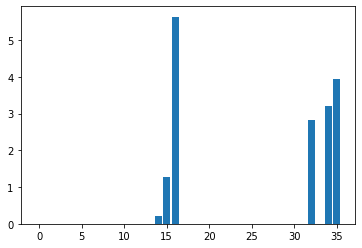

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2204902424690185, 1.2874425398386147, 5.638345828855352, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.8284271247461903, 0, 3.205839668917393, 3.9404389422455908]
Index: 15
value: 0.003401654033792297
x, y, scale, mag: 169 605 1.0690784454345703 8.94427190999916
Index: 16
value: 0.03031445903415122
x, y, scale, mag: 169 606 1.0690784454345703 8.94427190999916
Index: 16
value: 0.11262262127499412
x, y, scale, mag: 169 607 1.0690784454345703 8.94427190999916
Index: 16
value: 0.17442854875846378
x, y, scale, mag: 169 608 1.0690784454345703 8.94427190999916
Index: 16
value: 0.11262262127499412
x, y, scale, mag: 169 609 1.0690784454345703 8.94427190999916
Index: 15
value: 0.03031445903415122
x, y, scale, mag: 169 610 1.0690784454345703 8.94427190999916
Index: 15
value: 0.003401654033792297
x, y, scale, mag: 169 611 1.0690784454345703 8.94427190999916
Index: 15
value: 0.03031445903415122
x, y, scale, mag: 170 605 1.0690784454345703 8.94

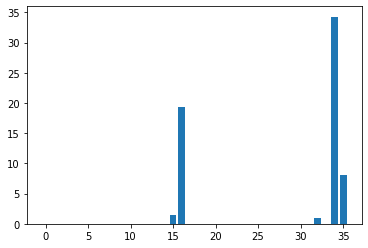

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3884548423761078, 19.31898875309963, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0036569871726115, 0, 34.293669039692574, 8.136977117690318]
Index: 16
value: 0.004595381545883662
x, y, scale, mag: 169 608 1.0690784454345703 12.083045973594572
Index: 16
value: 0.04095257902041273
x, y, scale, mag: 169 609 1.0690784454345703 12.083045973594572
Index: 15
value: 0.15214478318924585
x, y, scale, mag: 169 610 1.0690784454345703 12.083045973594572
Index: 15
value: 0.23563999339059655
x, y, scale, mag: 169 611 1.0690784454345703 12.083045973594572
Index: 15
value: 0.15214478318924585
x, y, scale, mag: 169 612 1.0690784454345703 12.083045973594572
Index: 15
value: 0.04095257902041273
x, y, scale, mag: 169 613 1.0690784454345703 12.083045973594572
Index: 15
value: 0.004595381545883662
x, y, scale, mag: 169 614 1.0690784454345703 12.083045973594572
Index: 16
value: 0.04095257902041273
x, y, scale, mag: 170 608 1.0690784454345703 12.0830

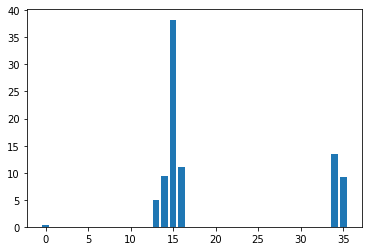

Histogram [0.3649563614419423, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04095257902041273, 0, 0, 5.037238980175132, 9.309625297277154, 38.2499389883218, 11.116948124538276, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.368992025717072, 9.16207589563379]
Index: 16
value: 0.003837356569549218
x, y, scale, mag: 170 610 1.0608764290809631 11.40175425099138
Index: 15
value: 0.03537835033687365
x, y, scale, mag: 170 611 1.0608764290809631 11.40175425099138
Index: 15
value: 0.13414078132013038
x, y, scale, mag: 170 612 1.0608764290809631 11.40175425099138
Index: 15
value: 0.20917121355346074
x, y, scale, mag: 170 613 1.0608764290809631 11.40175425099138
Index: 15
value: 0.13414078132013038
x, y, scale, mag: 170 614 1.0608764290809631 11.40175425099138
Index: 15
value: 0.03537835033687365
x, y, scale, mag: 170 615 1.0608764290809631 11.40175425099138
Index: 15
value: 0.003837356569549218
x, y, scale, mag: 170 616 1.0608764290809631 11.40175425099138
Index: 15
value: 0.03537835033687365
x, y, scale

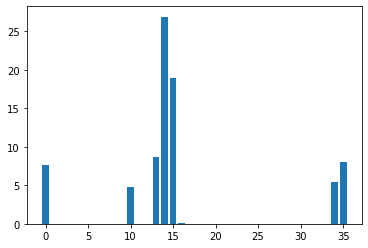

Histogram [7.638075106411797, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.724478486603027, 0, 0, 8.68275203940819, 26.911223000810903, 18.914709548927334, 0.1379781378896796, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.4892434283233085, 8.027607375890218]
Index: 16
value: 0.004783543835897195
x, y, scale, mag: 171 609 1.0579095482826233 14.866068747318506
Index: 15
value: 0.04465537617833091
x, y, scale, mag: 171 610 1.0579095482826233 14.866068747318506
Index: 15
value: 0.17058787084351207
x, y, scale, mag: 171 611 1.0579095482826233 14.866068747318506
Index: 15
value: 0.2666692549212589
x, y, scale, mag: 171 612 1.0579095482826233 14.866068747318506
Index: 15
value: 0.17058787084351207
x, y, scale, mag: 171 613 1.0579095482826233 14.866068747318506
Index: 15
value: 0.04465537617833091
x, y, scale, mag: 171 614 1.0579095482826233 14.866068747318506
Index: 15
value: 0.004783543835897195
x, y, scale, mag: 171 615 1.0579095482826233 14.866068747318506
Index: 34
value: 0.04465537617833091
x, y,

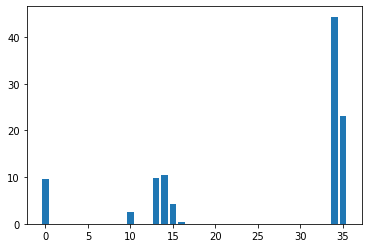

Histogram [9.680386876983734, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.4894129336374227, 0, 0, 9.776468261061481, 10.38053174123382, 4.303752990061933, 0.4216507640469638, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44.355867283567186, 23.003466904282458]
Index: 15
value: 0.0013267163522120797
x, y, scale, mag: 171 611 1.0579095482826233 4.123105625617661
Index: 15
value: 0.012385172964315789
x, y, scale, mag: 171 612 1.0579095482826233 4.123105625617661
Index: 15
value: 0.047312562715270096
x, y, scale, mag: 171 613 1.0579095482826233 4.123105625617661
Index: 15
value: 0.07396074401602899
x, y, scale, mag: 171 614 1.0579095482826233 4.123105625617661
Index: 15
value: 0.047312562715270096
x, y, scale, mag: 171 615 1.0579095482826233 4.123105625617661
Index: 15
value: 0.012385172964315789
x, y, scale, mag: 171 616 1.0579095482826233 4.123105625617661
Index: 15
value: 0.0013267163522120797
x, y, scale, mag: 171 617 1.0579095482826233 4.123105625617661
Index: 15
value: 0.012385172964315789
x, 

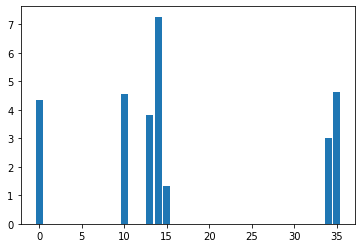

Histogram [4.3371610912274985, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.564778234564286, 0, 0, 3.816967780433281, 7.260248175581939, 1.3405063513777167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.01586374097291, 4.6230248662459035]
Index: 14
value: 0.08598796766423739
x, y, scale, mag: 173 614 0.9898326694965363 5.0990195135927845
Index: 14
value: 0.3974944374807669
x, y, scale, mag: 173 615 0.9898326694965363 5.0990195135927845
Index: 14
value: 0.6621588367258506
x, y, scale, mag: 173 616 0.9898326694965363 5.0990195135927845
Index: 14
value: 0.3974944374807669
x, y, scale, mag: 173 617 0.9898326694965363 5.0990195135927845
Index: 14
value: 0.08598796766423739
x, y, scale, mag: 173 618 0.9898326694965363 5.0990195135927845
Index: 10
value: 0.3974944374807669
x, y, scale, mag: 174 614 0.9898326694965363 5.0990195135927845
Index: 13
value: 1.8374876406558525
x, y, scale, mag: 174 615 0.9898326694965363 5.0990195135927845
Index: 13
value: 3.0609451703174555
x, y, scale, mag: 174 616 0.9

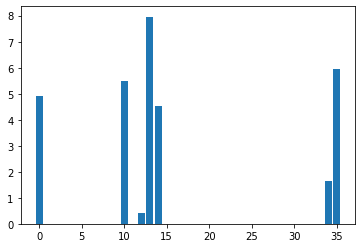

Histogram [4.898432810973308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.496513951073552, 0, 0.3974944374807669, 7.959377981290763, 4.526264561878329, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.6291236470158592, 5.958086085179925]
Index: 27
value: 0.0019015824138739856
x, y, scale, mag: 187 702 1.0690784454345703 5.0
Index: 27
value: 0.016946297775373684
x, y, scale, mag: 187 703 1.0690784454345703 5.0
Index: 26
value: 0.06295795924377522
x, y, scale, mag: 187 704 1.0690784454345703 5.0
Index: 19
value: 0.09750852306014038
x, y, scale, mag: 187 705 1.0690784454345703 5.0
Index: 11
value: 0.06295795924377522
x, y, scale, mag: 187 706 1.0690784454345703 5.0
Index: 10
value: 0.016946297775373684
x, y, scale, mag: 187 707 1.0690784454345703 5.0
Index: 10
value: 0.0019015824138739856
x, y, scale, mag: 187 708 1.0690784454345703 5.0
Index: 27
value: 0.016946297775373684
x, y, scale, mag: 188 702 1.0690784454345703 5.0
Index: 27
value: 0.15102001690612282
x, y, scale, mag: 188 703 1.0690784

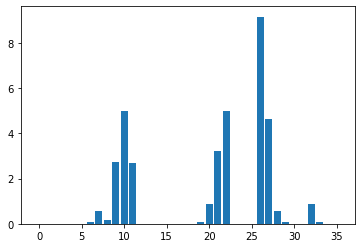

Histogram [0, 0, 0, 0, 0, 0, 0.06295795924377522, 0.5610613123526484, 0.16986789709537048, 2.72538989051696, 5.00563802640125, 2.7084435927415864, 0, 0, 0, 0, 0, 0, 0, 0.09750852306014038, 0.8689649501162945, 3.2283310867576476, 5.0, 0, 0, 0, 9.16510576625688, 4.653716847066686, 0.5799091925418961, 0.06295795924377522, 0, 0, 0.8689649501162945, 0.09750852306014038, 0, 0]
Index: 19
value: 0.06201374617484223
x, y, scale, mag: 290 698 0.952440619468689 5.0990195135927845
Index: 19
value: 0.32405034065080085
x, y, scale, mag: 290 699 0.952440619468689 5.0990195135927845
Index: 19
value: 0.5623249077326297
x, y, scale, mag: 290 700 0.952440619468689 5.0990195135927845
Index: 19
value: 0.32405034065080085
x, y, scale, mag: 290 701 0.952440619468689 5.0990195135927845
Index: 19
value: 0.06201374617484223
x, y, scale, mag: 290 702 0.952440619468689 5.0990195135927845
Index: 19
value: 0.32405034065080085
x, y, scale, mag: 291 698 0.952440619468689 5.0990195135927845
Index: 19
value: 1.69331204

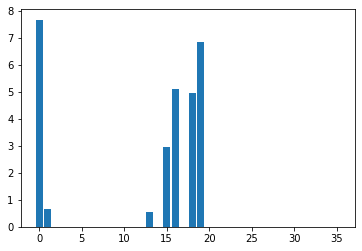

Histogram [7.659483395680789, 0.6481006813016017, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5623249077326297, 0, 2.9384062267973827, 5.0990195135927845, 0, 4.955768611197929, 6.852546600314475, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.0020640238892975773
x, y, scale, mag: 290 690 1.066275179386139 5.656854249492381
Index: 20
value: 0.018606980631702963
x, y, scale, mag: 290 691 1.066275179386139 5.656854249492381
Index: 20
value: 0.06960695203065104
x, y, scale, mag: 290 692 1.066275179386139 5.656854249492381
Index: 20
value: 0.1080549966879218
x, y, scale, mag: 290 693 1.066275179386139 5.656854249492381
Index: 20
value: 0.06960695203065104
x, y, scale, mag: 290 694 1.066275179386139 5.656854249492381
Index: 19
value: 0.018606980631702963
x, y, scale, mag: 290 695 1.066275179386139 5.656854249492381
Index: 19
value: 0.0020640238892975773
x, y, scale, mag: 290 696 1.066275179386139 5.656854249492381
Index: 20
value: 0.018606980631702963
x, y, scale, mag: 291 690 1.0

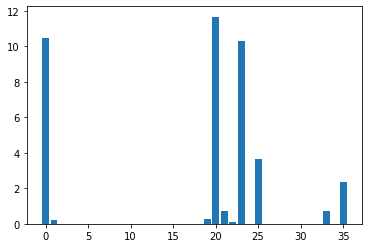

Histogram [10.46486499574697, 0.1962689293502758, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25801813147103864, 11.668373652067645, 0.6971070575197263, 0.1080549966879218, 10.274996631993151, 0, 3.644036781806815, 0, 0, 0, 0, 0, 0, 0, 0.6971070575197263, 0, 2.3474184558233167]
Index: 20
value: 0.012161896225250404
x, y, scale, mag: 291 693 0.952440619468689 1.0
Index: 20
value: 0.06355150039864703
x, y, scale, mag: 291 694 0.952440619468689 1.0
Index: 19
value: 0.11028098759645927
x, y, scale, mag: 291 695 0.952440619468689 1.0
Index: 20
value: 0.06355150039864703
x, y, scale, mag: 291 696 0.952440619468689 1.0
Index: 19
value: 0.012161896225250404
x, y, scale, mag: 291 697 0.952440619468689 1.0
Index: 20
value: 0.06355150039864703
x, y, scale, mag: 292 693 0.952440619468689 1.0
Index: 20
value: 0.3320858136031397
x, y, scale, mag: 292 694 0.952440619468689 1.0
Index: 20
value: 0.576268872665477
x, y, scale, mag: 292 695 0.952440619468689 1.0
Index: 19
value: 0.33208581360313

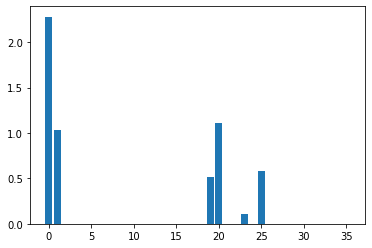

Histogram [2.2803434547093295, 1.0354576870659107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5180801978234963, 1.111171083689808, 0, 0, 0.11028098759645927, 0, 0.576268872665477, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.14594275470300483
x, y, scale, mag: 296 675 0.952440619468689 12.0
Index: 20
value: 0.7626180047837643
x, y, scale, mag: 296 676 0.952440619468689 12.0
Index: 19
value: 1.3233718511575112
x, y, scale, mag: 296 677 0.952440619468689 12.0
Index: 19
value: 0.7626180047837643
x, y, scale, mag: 296 678 0.952440619468689 12.0
Index: 17
value: 0.14594275470300483
x, y, scale, mag: 296 679 0.952440619468689 12.0
Index: 21
value: 0.7626180047837643
x, y, scale, mag: 297 675 0.952440619468689 12.0
Index: 20
value: 3.9850297632376765
x, y, scale, mag: 297 676 0.952440619468689 12.0
Index: 19
value: 6.915226471985724
x, y, scale, mag: 297 677 0.952440619468689 12.0
Index: 17
value: 3.9850297632376765
x, y, scale, mag: 297 678 0.952440619468689 12.0
Index: 14
valu

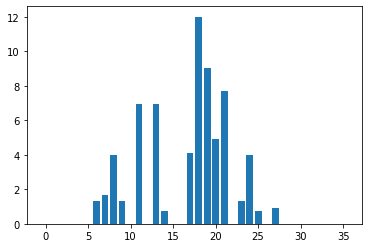

Histogram [0, 0, 0, 0, 0, 0, 1.3233718511575112, 1.6711787642705334, 3.9850297632376765, 1.3233718511575112, 0, 6.915226471985724, 0, 6.915226471985724, 0.7626180047837643, 0, 0, 4.130972517940681, 12.0, 9.001216327927, 4.893590522724446, 7.677844476769488, 0, 1.3233718511575112, 3.9850297632376765, 0.7626180047837643, 0, 0.9085607594867691, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 16
value: 0.08948348938449417
x, y, scale, mag: 309 34 0.9487389922142029 7.615773105863909
Index: 15
value: 0.47367674982849445
x, y, scale, mag: 309 35 0.9487389922142029 7.615773105863909
Index: 14
value: 0.8255216241100468
x, y, scale, mag: 309 36 0.9487389922142029 7.615773105863909
Index: 14
value: 0.47367674982849445
x, y, scale, mag: 309 37 0.9487389922142029 7.615773105863909
Index: 14
value: 0.08948348938449417
x, y, scale, mag: 309 38 0.9487389922142029 7.615773105863909
Index: 21
value: 0.47367674982849445
x, y, scale, mag: 310 34 0.9487389922142029 7.615773105863909
Index: 15
value: 2.507386165552963
x, y

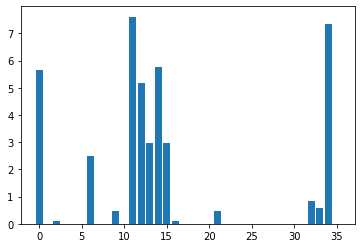

Histogram [5.669059255663894, 0, 0.08948348938449417, 0, 0, 0, 2.507386165552963, 0, 0, 0.47367674982849445, 0, 7.615773105863909, 5.1953825058354, 2.9810629153814574, 5.758542745048389, 2.9810629153814574, 0.08948348938449417, 0, 0, 0, 0, 0.47367674982849445, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8255216241100468, 0.5631602392129886, 7.350923797106811, 0]
Index: 20
value: 0.9035019166088176
x, y, scale, mag: 47 689 0.6561359614133835 9.219544457292887
Index: 19
value: 2.8861524712711084
x, y, scale, mag: 47 690 0.6561359614133835 9.219544457292887
Index: 19
value: 0.9035019166088176
x, y, scale, mag: 47 691 0.6561359614133835 9.219544457292887
Index: 21
value: 2.8861524712711084
x, y, scale, mag: 48 689 0.6561359614133835 9.219544457292887
Index: 20
value: 9.219544457292887
x, y, scale, mag: 48 690 0.6561359614133835 9.219544457292887
Index: 17
value: 2.8861524712711084
x, y, scale, mag: 48 691 0.6561359614133835 9.219544457292887
Index: 31
value: 0.9035019166088176
x, y, scale, mag: 49 689

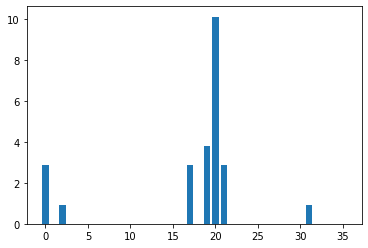

Histogram [2.8861524712711084, 0, 0.9035019166088176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.8861524712711084, 0, 3.789654387879926, 10.123046373901705, 2.8861524712711084, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9035019166088176, 0, 0, 0, 0]
Index: 28
value: 0.9026643287030153
x, y, scale, mag: 59 732 0.6140243411064148 12.806248474865697
Index: 27
value: 3.3999623060805626
x, y, scale, mag: 59 733 0.6140243411064148 12.806248474865697
Index: 27
value: 0.9026643287030153
x, y, scale, mag: 59 734 0.6140243411064148 12.806248474865697
Index: 30
value: 3.3999623060805626
x, y, scale, mag: 60 732 0.6140243411064148 12.806248474865697
Index: 33
value: 12.806248474865697
x, y, scale, mag: 60 733 0.6140243411064148 12.806248474865697
Index: 35
value: 3.3999623060805626
x, y, scale, mag: 60 734 0.6140243411064148 12.806248474865697
Index: 33
value: 0.9026643287030153
x, y, scale, mag: 61 732 0.6140243411064148 12.806248474865697
Index: 35
value: 3.3999623060805626
x, y, scale, mag: 61 733 0.6140243

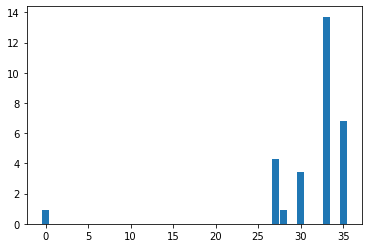

Histogram [0.9026643287030153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.302626634783578, 0.9026643287030153, 0, 3.3999623060805626, 0, 0, 13.708912803568712, 0, 6.799924612161125]
Index: 14
value: 0.86782204395113
x, y, scale, mag: 61 744 0.6664412319660187 8.246211251235321
Index: 14
value: 2.675115680283722
x, y, scale, mag: 61 745 0.6664412319660187 8.246211251235321
Index: 14
value: 0.86782204395113
x, y, scale, mag: 61 746 0.6664412319660187 8.246211251235321
Index: 7
value: 2.675115680283722
x, y, scale, mag: 62 744 0.6664412319660187 8.246211251235321
Index: 10
value: 8.246211251235321
x, y, scale, mag: 62 745 0.6664412319660187 8.246211251235321
Index: 11
value: 2.675115680283722
x, y, scale, mag: 62 746 0.6664412319660187 8.246211251235321
Index: 0
value: 0.86782204395113
x, y, scale, mag: 63 744 0.6664412319660187 8.246211251235321
Index: 2
value: 2.675115680283722
x, y, scale, mag: 63 745 0.6664412319660187 8.246211251235321
Index: 3
va

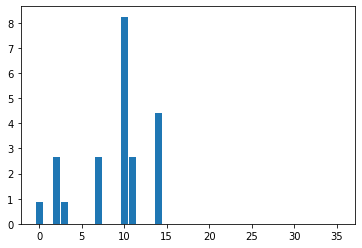

Histogram [0.86782204395113, 0, 2.675115680283722, 0.86782204395113, 0, 0, 0, 2.675115680283722, 0, 0, 8.246211251235321, 2.675115680283722, 0, 0, 4.410759768185982, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 26
value: 0.22720077532187982
x, y, scale, mag: 165 704 0.6613039076328278 2.23606797749979
Index: 16
value: 0.7127667066862621
x, y, scale, mag: 165 705 0.6613039076328278 2.23606797749979
Index: 12
value: 0.22720077532187982
x, y, scale, mag: 165 706 0.6613039076328278 2.23606797749979
Index: 28
value: 0.7127667066862621
x, y, scale, mag: 166 704 0.6613039076328278 2.23606797749979
Index: 25
value: 2.23606797749979
x, y, scale, mag: 166 705 0.6613039076328278 2.23606797749979
Index: 10
value: 0.7127667066862621
x, y, scale, mag: 166 706 0.6613039076328278 2.23606797749979
Index: 30
value: 0.22720077532187982
x, y, scale, mag: 167 704 0.6613039076328278 2.23606797749979
Index: 32
value: 0.7127667066862621
x, y, scale, mag: 167 705 0.6613039076328278 2.2

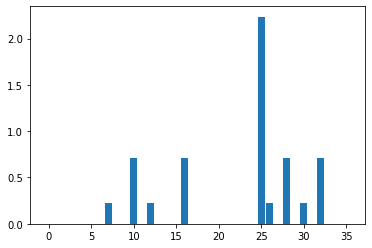

Histogram [0, 0, 0, 0, 0, 0, 0, 0.22720077532187982, 0, 0, 0.7127667066862621, 0, 0.22720077532187982, 0, 0, 0, 0.7127667066862621, 0, 0, 0, 0, 0, 0, 0, 0, 2.23606797749979, 0.22720077532187982, 0, 0.7127667066862621, 0, 0.22720077532187982, 0, 0.7127667066862621, 0, 0, 0]
Index: 26
value: 0.8510657130352249
x, y, scale, mag: 191 705 0.624600425362587 11.045361017187261
Index: 9
value: 3.0659954419118036
x, y, scale, mag: 191 706 0.624600425362587 11.045361017187261
Index: 9
value: 0.8510657130352249
x, y, scale, mag: 191 707 0.624600425362587 11.045361017187261
Index: 29
value: 3.0659954419118036
x, y, scale, mag: 192 705 0.624600425362587 11.045361017187261
Index: 8
value: 11.045361017187261
x, y, scale, mag: 192 706 0.624600425362587 11.045361017187261
Index: 8
value: 3.0659954419118036
x, y, scale, mag: 192 707 0.624600425362587 11.045361017187261
Index: 32
value: 0.8510657130352249
x, y, scale, mag: 193 705 0.624600425362587 11.045361017187261
Index: 7
value: 3.0659954419118036
x,

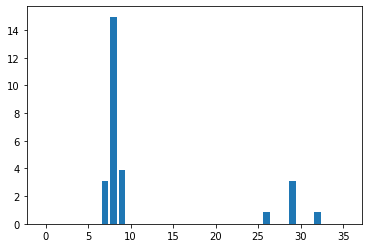

Histogram [0, 0, 0, 0, 0, 0, 0, 3.0659954419118036, 14.962422172134291, 3.9170611549470284, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8510657130352249, 0, 0, 3.0659954419118036, 0, 0, 0.8510657130352249, 0, 0, 0]
Index: 27
value: 0.0008367156247202555
x, y, scale, mag: 203 519 0.6734772473573685 5.656854249492381
Index: 27
value: 0.02284687446017748
x, y, scale, mag: 203 520 0.6734772473573685 5.656854249492381
Index: 22
value: 0.06879809835537207
x, y, scale, mag: 203 521 0.6734772473573685 5.656854249492381
Index: 10
value: 0.02284687446017748
x, y, scale, mag: 203 522 0.6734772473573685 5.656854249492381
Index: 9
value: 0.0008367156247202555
x, y, scale, mag: 203 523 0.6734772473573685 5.656854249492381
Index: 28
value: 0.02284687446017748
x, y, scale, mag: 204 519 0.6734772473573685 5.656854249492381
Index: 28
value: 0.6238435821891424
x, y, scale, mag: 204 520 0.6734772473573685 5.656854249492381
Index: 27
value: 1.878561209789343
x, y, scale, mag: 204 521 0.67347724735736

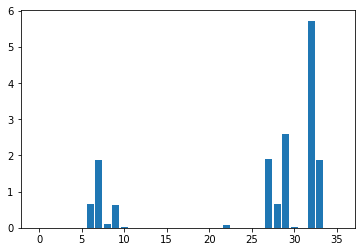

Histogram [0, 0, 0, 0, 0, 0, 0.6466904566493199, 1.8793979254140631, 0.11449184727572703, 0.6246802978138626, 0.02284687446017748, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06879809835537207, 0, 0, 0, 0, 1.9022447998742407, 0.6466904566493199, 2.5948864804187552, 0.02284687446017748, 0, 5.725652347847753, 1.878561209789343, 0, 0]
Index: 9
value: 0.08010461424724512
x, y, scale, mag: 207 658 0.629388839006424 1.0
Index: 13
value: 0.28302758566479896
x, y, scale, mag: 207 659 0.629388839006424 1.0
Index: 13
value: 0.08010461424724512
x, y, scale, mag: 207 660 0.629388839006424 1.0
Index: 33
value: 0.28302758566479896
x, y, scale, mag: 208 658 0.629388839006424 1.0
Index: 18
value: 1.0
x, y, scale, mag: 208 659 0.629388839006424 1.0
Index: 13
value: 0.28302758566479896
x, y, scale, mag: 208 660 0.629388839006424 1.0
Index: 32
value: 0.08010461424724512
x, y, scale, mag: 209 658 0.629388839006424 1.0
Index: 32
value: 0.28302758566479896
x, y, scale, mag: 209 659 0.629388839006424 1.0
Index: 27
va

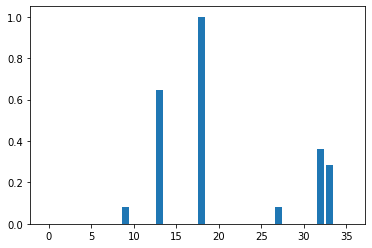

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08010461424724512, 0, 0, 0, 0.6461597855768431, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08010461424724512, 0, 0, 0, 0, 0.3631321999120441, 0.28302758566479896, 0, 0]
Index: 27
value: 0.0006614817819916732
x, y, scale, mag: 209 660 0.6734772473573685 4.47213595499958
Index: 15
value: 0.018062040177522685
x, y, scale, mag: 209 661 0.6734772473573685 4.47213595499958
Index: 14
value: 0.054389672372815
x, y, scale, mag: 209 662 0.6734772473573685 4.47213595499958
Index: 14
value: 0.018062040177522685
x, y, scale, mag: 209 663 0.6734772473573685 4.47213595499958
Index: 14
value: 0.0006614817819916732
x, y, scale, mag: 209 664 0.6734772473573685 4.47213595499958
Index: 31
value: 0.018062040177522685
x, y, scale, mag: 210 660 0.6734772473573685 4.47213595499958
Index: 25
value: 0.49319165584903535
x, y, scale, mag: 210 661 0.6734772473573685 4.47213595499958
Index: 15
value: 1.4851330367439308
x, y, scale, mag: 210 662 0.6734772473573685 4.4721359549

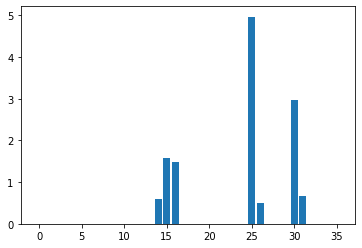

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5843668903588873, 1.5756467894717912, 1.4851330367439308, 0, 0, 0, 0, 0, 0, 0, 0, 4.965327610848615, 0.49319165584903535, 0.0013229635639833465, 0, 0, 2.9702660734878616, 0.6748806430867478, 0, 0, 0, 0]
Index: 27
value: 0.24949251323937238
x, y, scale, mag: 283 63 0.597088560461998 4.123105625617661
Index: 26
value: 1.014240595168003
x, y, scale, mag: 283 64 0.597088560461998 4.123105625617661
Index: 9
value: 0.24949251323937238
x, y, scale, mag: 283 65 0.597088560461998 4.123105625617661
Index: 27
value: 1.014240595168003
x, y, scale, mag: 284 63 0.597088560461998 4.123105625617661
Index: 26
value: 4.123105625617661
x, y, scale, mag: 284 64 0.597088560461998 4.123105625617661
Index: 9
value: 1.014240595168003
x, y, scale, mag: 284 65 0.597088560461998 4.123105625617661
Index: 27
value: 0.24949251323937238
x, y, scale, mag: 285 63 0.597088560461998 4.123105625617661
Index: 29
value: 1.014240595168003
x, y, scale, mag: 285 64 0.5970

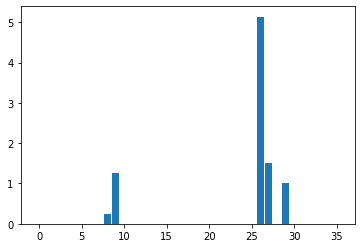

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0.24949251323937238, 1.2637331084073753, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.1373462207856635, 1.5132256216467477, 0, 1.014240595168003, 0, 0, 0, 0, 0, 0]
Index: 28
value: 0.3482157481007843
x, y, scale, mag: 287 63 0.6258808672428131 4.47213595499958
Index: 31
value: 1.2479055121196452
x, y, scale, mag: 287 64 0.6258808672428131 4.47213595499958
Index: 7
value: 0.3482157481007843
x, y, scale, mag: 287 65 0.6258808672428131 4.47213595499958
Index: 28
value: 1.2479055121196452
x, y, scale, mag: 288 63 0.6258808672428131 4.47213595499958
Index: 34
value: 4.47213595499958
x, y, scale, mag: 288 64 0.6258808672428131 4.47213595499958
Index: 7
value: 1.2479055121196452
x, y, scale, mag: 288 65 0.6258808672428131 4.47213595499958
Index: 29
value: 0.3482157481007843
x, y, scale, mag: 289 63 0.6258808672428131 4.47213595499958
Index: 35
value: 1.2479055121196452
x, y, scale, mag: 289 64 0.6258808672428131 4.47213595499958
Index: 6
value: 0.348215

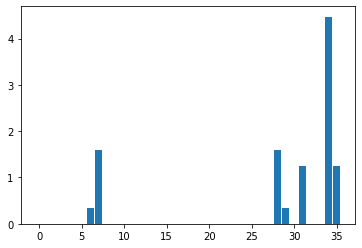

Histogram [0, 0, 0, 0, 0, 0, 0.3482157481007843, 1.5961212602204295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.5961212602204295, 0.3482157481007843, 0, 1.2479055121196452, 0, 0, 4.47213595499958, 1.2479055121196452]
Index: 21
value: 0.8722647542716587
x, y, scale, mag: 292 690 0.6324104815721512 10.63014581273465
Index: 21
value: 3.045045406101014
x, y, scale, mag: 292 691 0.6324104815721512 10.63014581273465
Index: 21
value: 0.8722647542716587
x, y, scale, mag: 292 692 0.6324104815721512 10.63014581273465
Index: 22
value: 3.045045406101014
x, y, scale, mag: 293 690 0.6324104815721512 10.63014581273465
Index: 23
value: 10.63014581273465
x, y, scale, mag: 293 691 0.6324104815721512 10.63014581273465
Index: 22
value: 3.045045406101014
x, y, scale, mag: 293 692 0.6324104815721512 10.63014581273465
Index: 32
value: 0.8722647542716587
x, y, scale, mag: 294 690 0.6324104815721512 10.63014581273465
Index: 34
value: 3.045045406101014
x, y, scale, mag: 294 691 0.632410481572

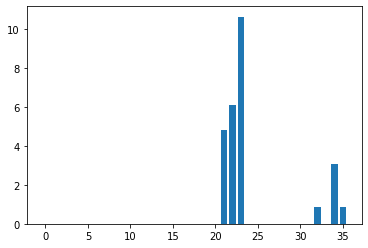

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.789574914644332, 6.090090812202028, 10.63014581273465, 0, 0, 0, 0, 0, 0, 0, 0, 0.8722647542716587, 0, 3.045045406101014, 0.8722647542716587]
Index: 21
value: 0.002030874216338964
x, y, scale, mag: 296 674 0.6685293316841125 15.652475842498529
Index: 20
value: 0.05824659361898048
x, y, scale, mag: 296 675 0.6685293316841125 15.652475842498529
Index: 20
value: 0.1782924833255703
x, y, scale, mag: 296 676 0.6685293316841125 15.652475842498529
Index: 20
value: 0.05824659361898048
x, y, scale, mag: 296 677 0.6685293316841125 15.652475842498529
Index: 19
value: 0.002030874216338964
x, y, scale, mag: 296 678 0.6685293316841125 15.652475842498529
Index: 22
value: 0.05824659361898048
x, y, scale, mag: 297 674 0.6685293316841125 15.652475842498529
Index: 21
value: 1.6705444585980227
x, y, scale, mag: 297 675 0.6685293316841125 15.652475842498529
Index: 20
value: 5.113526843776743
x, y, scale, mag: 297 676 0.6685293316841

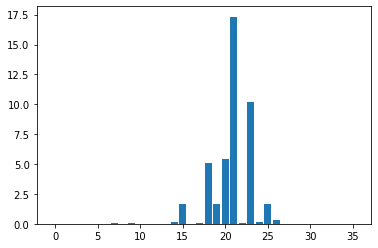

Histogram [0, 0, 0, 0, 0, 0, 0, 0.06027746783531944, 0, 0.05824659361898048, 0, 0, 0, 0, 0.1782924833255703, 1.6705444585980227, 0, 0.05824659361898048, 5.113526843776743, 1.6725753328143618, 5.408312514340274, 17.32505117531289, 0.05824659361898048, 10.227053687553486, 0.1782924833255703, 1.6705444585980227, 0.2968165447798702, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 25
value: 0.4113847528699804
x, y, scale, mag: 311 59 0.623555526137352 5.385164807134504
Index: 25
value: 1.4884134819824575
x, y, scale, mag: 311 60 0.623555526137352 5.385164807134504
Index: 9
value: 0.4113847528699804
x, y, scale, mag: 311 61 0.623555526137352 5.385164807134504
Index: 26
value: 1.4884134819824575
x, y, scale, mag: 312 59 0.623555526137352 5.385164807134504
Index: 25
value: 5.385164807134504
x, y, scale, mag: 312 60 0.623555526137352 5.385164807134504
Index: 7
value: 1.4884134819824575
x, y, scale, mag: 312 61 0.623555526137352 5.385164807134504
Index: 27
value: 0.4113847528699804
x, y, scale, mag: 313 59 0.

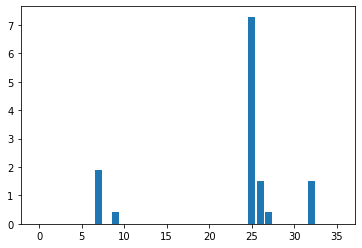

Histogram [0, 0, 0, 0, 0, 0, 0, 1.8997982348524378, 0, 0.4113847528699804, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.284963041986941, 1.4884134819824575, 0.4113847528699804, 0, 0, 0, 0, 1.4884134819824575, 0, 0, 0]
Index: 5
value: 0.36254835057493723
x, y, scale, mag: 357 45 0.6000000089406967 5.830951894845301
Index: 10
value: 1.4539607944363453
x, y, scale, mag: 357 46 0.6000000089406967 5.830951894845301
Index: 11
value: 0.36254835057493723
x, y, scale, mag: 357 47 0.6000000089406967 5.830951894845301
Index: 35
value: 1.4539607944363453
x, y, scale, mag: 358 45 0.6000000089406967 5.830951894845301
Index: 5
value: 5.830951894845301
x, y, scale, mag: 358 46 0.6000000089406967 5.830951894845301
Index: 10
value: 1.4539607944363453
x, y, scale, mag: 358 47 0.6000000089406967 5.830951894845301
Index: 34
value: 0.36254835057493723
x, y, scale, mag: 359 45 0.6000000089406967 5.830951894845301
Index: 35
value: 1.4539607944363453
x, y, scale, mag: 359 46 0.6000000089406967 5.830951894845

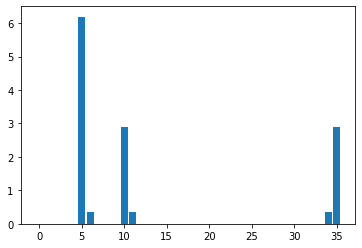

Histogram [0, 0, 0, 0, 0, 6.193500245420238, 0.36254835057493723, 0, 0, 0, 2.9079215888726906, 0.36254835057493723, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.36254835057493723, 2.9079215888726906]
Index: 21
value: 0.007008778868257774
x, y, scale, mag: 11 729 0.37532173097133636 8.48528137423857
Index: 21
value: 0.24386771165323334
x, y, scale, mag: 11 730 0.37532173097133636 8.48528137423857
Index: 21
value: 0.007008778868257774
x, y, scale, mag: 11 731 0.37532173097133636 8.48528137423857
Index: 24
value: 0.24386771165323334
x, y, scale, mag: 12 729 0.37532173097133636 8.48528137423857
Index: 23
value: 8.48528137423857
x, y, scale, mag: 12 730 0.37532173097133636 8.48528137423857
Index: 22
value: 0.24386771165323334
x, y, scale, mag: 12 731 0.37532173097133636 8.48528137423857
Index: 29
value: 0.007008778868257774
x, y, scale, mag: 13 729 0.37532173097133636 8.48528137423857
Index: 32
value: 0.24386771165323334
x, y, scale, mag: 13 730 0.37532173097133636 8.

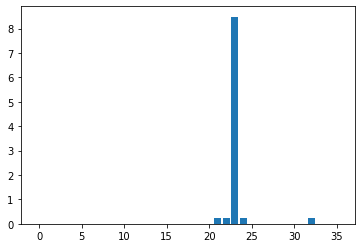

Histogram [0.007008778868257774, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25788526938974893, 0.24386771165323334, 8.48528137423857, 0.24386771165323334, 0, 0, 0, 0, 0.007008778868257774, 0, 0, 0.24386771165323334, 0, 0, 0]
Index: 22
value: 0.0013971228033533803
x, y, scale, mag: 45 754 0.36242683231830597 2.8284271247461903
Index: 21
value: 0.0628622305808992
x, y, scale, mag: 45 755 0.36242683231830597 2.8284271247461903
Index: 17
value: 0.0013971228033533803
x, y, scale, mag: 45 756 0.36242683231830597 2.8284271247461903
Index: 29
value: 0.0628622305808992
x, y, scale, mag: 46 754 0.36242683231830597 2.8284271247461903
Index: 32
value: 2.8284271247461903
x, y, scale, mag: 46 755 0.36242683231830597 2.8284271247461903
Index: 1
value: 0.0628622305808992
x, y, scale, mag: 46 756 0.36242683231830597 2.8284271247461903
Index: 35
value: 0.0013971228033533803
x, y, scale, mag: 47 754 0.36242683231830597 2.8284271247461903
Index: 0
value: 0.0628622305808992
x, y, scale, 

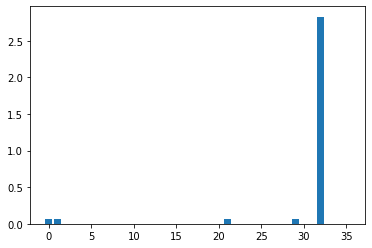

Histogram [0.06425935338425258, 0.0628622305808992, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0013971228033533803, 0, 0, 0, 0.0628622305808992, 0.0013971228033533803, 0, 0, 0, 0, 0, 0, 0.0628622305808992, 0, 0, 2.8284271247461903, 0, 0, 0.0013971228033533803]
Index: 31
value: 0.020049370455083048
x, y, scale, mag: 49 689 0.39264920353889465 13.152946437965905
Index: 0
value: 0.5135253603383609
x, y, scale, mag: 49 690 0.39264920353889465 13.152946437965905
Index: 2
value: 0.020049370455083048
x, y, scale, mag: 49 691 0.39264920353889465 13.152946437965905
Index: 35
value: 0.5135253603383609
x, y, scale, mag: 50 689 0.39264920353889465 13.152946437965905
Index: 0
value: 13.152946437965905
x, y, scale, mag: 50 690 0.39264920353889465 13.152946437965905
Index: 1
value: 0.5135253603383609
x, y, scale, mag: 50 691 0.39264920353889465 13.152946437965905
Index: 0
value: 0.020049370455083048
x, y, scale, mag: 51 689 0.39264920353889465 13.152946437965905
Index: 0
value: 0.5135253603383609

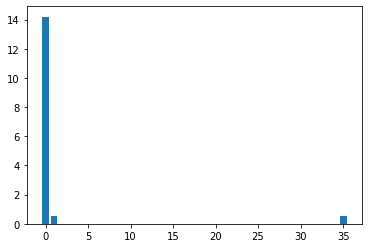

Histogram [14.200046529097712, 0.533574730793444, 0.020049370455083048, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.020049370455083048, 0, 0, 0, 0.5135253603383609]
Index: 20
value: 0.001272385612640859
x, y, scale, mag: 49 723 0.33673862367868423 8.602325267042627
Index: 20
value: 0.10462062370795719
x, y, scale, mag: 49 724 0.33673862367868423 8.602325267042627
Index: 19
value: 0.001272385612640859
x, y, scale, mag: 49 725 0.33673862367868423 8.602325267042627
Index: 24
value: 0.10462062370795719
x, y, scale, mag: 50 723 0.33673862367868423 8.602325267042627
Index: 22
value: 8.602325267042627
x, y, scale, mag: 50 724 0.33673862367868423 8.602325267042627
Index: 21
value: 0.10462062370795719
x, y, scale, mag: 50 725 0.33673862367868423 8.602325267042627
Index: 31
value: 0.001272385612640859
x, y, scale, mag: 51 723 0.33673862367868423 8.602325267042627
Index: 30
value: 0.10462062370795719
x, y, scale, mag: 51 724 0.33673862367868423 8.60232526

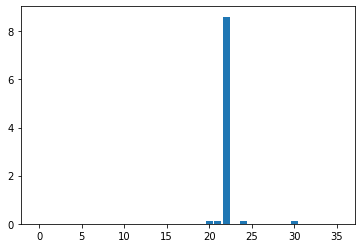

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001272385612640859, 0.10589300932059804, 0.10462062370795719, 8.602325267042627, 0, 0.10462062370795719, 0, 0, 0, 0, 0, 0.10589300932059804, 0.001272385612640859, 0, 0, 0, 0]
Index: 21
value: 0.004357991816451452
x, y, scale, mag: 50 725 0.3929746448993683 2.8284271247461903
Index: 20
value: 0.11102370135729223
x, y, scale, mag: 50 726 0.3929746448993683 2.8284271247461903
Index: 17
value: 0.004357991816451452
x, y, scale, mag: 50 727 0.3929746448993683 2.8284271247461903
Index: 30
value: 0.11102370135729223
x, y, scale, mag: 51 725 0.3929746448993683 2.8284271247461903
Index: 32
value: 2.8284271247461903
x, y, scale, mag: 51 726 0.3929746448993683 2.8284271247461903
Index: 4
value: 0.11102370135729223
x, y, scale, mag: 51 727 0.3929746448993683 2.8284271247461903
Index: 34
value: 0.004357991816451452
x, y, scale, mag: 52 725 0.3929746448993683 2.8284271247461903
Index: 35
value: 0.11102370135729223
x, y, scale, mag:

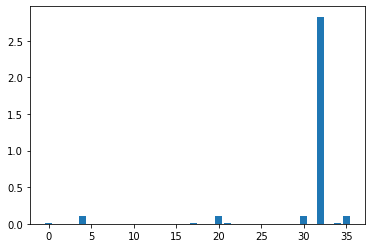

Histogram [0.004357991816451452, 0, 0, 0, 0.11102370135729223, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004357991816451452, 0, 0, 0.11102370135729223, 0.004357991816451452, 0, 0, 0, 0, 0, 0, 0, 0, 0.11102370135729223, 0, 2.8284271247461903, 0, 0.004357991816451452, 0.11102370135729223]
Index: 29
value: 0.004686092341819844
x, y, scale, mag: 59 733 0.36242683231830597 9.486832980505138
Index: 29
value: 0.21084633119423501
x, y, scale, mag: 59 734 0.36242683231830597 9.486832980505138
Index: 0
value: 0.004686092341819844
x, y, scale, mag: 59 735 0.36242683231830597 9.486832980505138
Index: 33
value: 0.21084633119423501
x, y, scale, mag: 60 733 0.36242683231830597 9.486832980505138
Index: 35
value: 9.486832980505138
x, y, scale, mag: 60 734 0.36242683231830597 9.486832980505138
Index: 0
value: 0.21084633119423501
x, y, scale, mag: 60 735 0.36242683231830597 9.486832980505138
Index: 35
value: 0.004686092341819844
x, y, scale, mag: 61 733 0.36242683231830597 9.486832980505138
Index: 0
value: 0

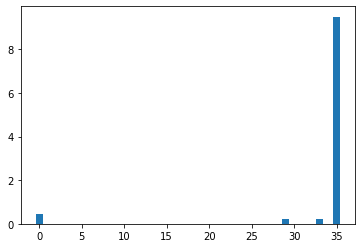

Histogram [0.4310648470721097, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21553242353605487, 0, 0, 0, 0.21084633119423501, 0, 9.491519072846957]
Index: 15
value: 0.011738259679856821
x, y, scale, mag: 60 744 0.37284670025110245 15.620499351813308
Index: 14
value: 0.42820261293063094
x, y, scale, mag: 60 745 0.37284670025110245 15.620499351813308
Index: 14
value: 0.011738259679856821
x, y, scale, mag: 60 746 0.37284670025110245 15.620499351813308
Index: 14
value: 0.42820261293063094
x, y, scale, mag: 61 744 0.37284670025110245 15.620499351813308
Index: 14
value: 15.620499351813308
x, y, scale, mag: 61 745 0.37284670025110245 15.620499351813308
Index: 14
value: 0.42820261293063094
x, y, scale, mag: 61 746 0.37284670025110245 15.620499351813308
Index: 7
value: 0.011738259679856821
x, y, scale, mag: 62 744 0.37284670025110245 15.620499351813308
Index: 9
value: 0.42820261293063094
x, y, scale, mag: 62 745 0.37284670025110245 15.620499351813308
Inde

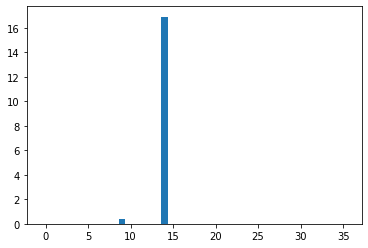

Histogram [0, 0, 0, 0, 0, 0, 0, 0.011738259679856821, 0, 0.42820261293063094, 0, 0.011738259679856821, 0, 0, 16.916845450285056, 0.011738259679856821, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 18
value: 0.0032186858497885123
x, y, scale, mag: 61 742 0.3746323138475418 4.0
Index: 14
value: 0.11346692645504261
x, y, scale, mag: 61 743 0.3746323138475418 4.0
Index: 14
value: 0.0032186858497885123
x, y, scale, mag: 61 744 0.3746323138475418 4.0
Index: 34
value: 0.11346692645504261
x, y, scale, mag: 62 742 0.3746323138475418 4.0
Index: 0
value: 4.0
x, y, scale, mag: 62 743 0.3746323138475418 4.0
Index: 7
value: 0.11346692645504261
x, y, scale, mag: 62 744 0.3746323138475418 4.0
Index: 34
value: 0.0032186858497885123
x, y, scale, mag: 63 742 0.3746323138475418 4.0
Index: 35
value: 0.11346692645504261
x, y, scale, mag: 63 743 0.3746323138475418 4.0
Index: 1
value: 0.0032186858497885123
x, y, scale, mag: 63 744 0.3746323138475418 4.0


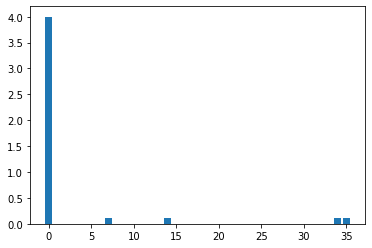

Histogram [4.0, 0.0032186858497885123, 0, 0, 0, 0, 0, 0.11346692645504261, 0, 0, 0, 0, 0, 0, 0.11668561230483113, 0, 0, 0, 0.0032186858497885123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11668561230483113, 0.11346692645504261]
Index: 14
value: 0.003761434868027768
x, y, scale, mag: 61 743 0.37797631323337555 4.123105625617661
Index: 14
value: 0.12453430557384464
x, y, scale, mag: 61 744 0.37797631323337555 4.123105625617661
Index: 14
value: 0.003761434868027768
x, y, scale, mag: 61 745 0.37797631323337555 4.123105625617661
Index: 0
value: 0.12453430557384464
x, y, scale, mag: 62 743 0.37797631323337555 4.123105625617661
Index: 7
value: 4.123105625617661
x, y, scale, mag: 62 744 0.37797631323337555 4.123105625617661
Index: 9
value: 0.12453430557384464
x, y, scale, mag: 62 745 0.37797631323337555 4.123105625617661
Index: 35
value: 0.003761434868027768
x, y, scale, mag: 63 743 0.37797631323337555 4.123105625617661
Index: 1
value: 0.12453430557384464
x, y, scale, mag: 63 744 0.377976

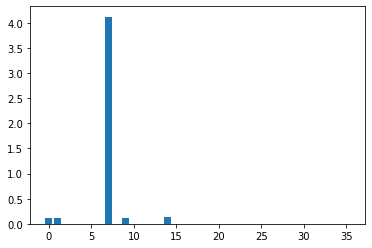

Histogram [0.12453430557384464, 0.12453430557384464, 0.003761434868027768, 0, 0, 0, 0, 4.123105625617661, 0, 0.12453430557384464, 0, 0, 0, 0, 0.13205717530990016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003761434868027768]
Index: 9
value: 0.013296506695241328
x, y, scale, mag: 62 745 0.3909837305545807 9.219544457292887
Index: 11
value: 0.35012531271456215
x, y, scale, mag: 62 746 0.3909837305545807 9.219544457292887
Index: 12
value: 0.013296506695241328
x, y, scale, mag: 62 747 0.3909837305545807 9.219544457292887
Index: 2
value: 0.35012531271456215
x, y, scale, mag: 63 745 0.3909837305545807 9.219544457292887
Index: 4
value: 9.219544457292887
x, y, scale, mag: 63 746 0.3909837305545807 9.219544457292887
Index: 6
value: 0.35012531271456215
x, y, scale, mag: 63 747 0.3909837305545807 9.219544457292887
Index: 0
value: 0.013296506695241328
x, y, scale, mag: 64 745 0.3909837305545807 9.219544457292887
Index: 1
value: 0.35012531271456215
x, y, scale, mag: 64 746 0.390

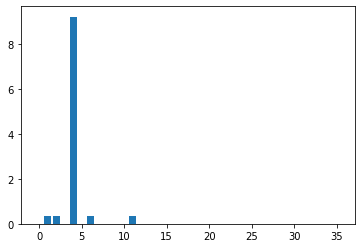

Histogram [0.013296506695241328, 0.3634218194098035, 0.35012531271456215, 0, 9.219544457292887, 0, 0.35012531271456215, 0, 0, 0.013296506695241328, 0, 0.35012531271456215, 0.013296506695241328, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 25
value: 0.010956538945071176
x, y, scale, mag: 65 762 0.3793875128030777 11.40175425099138
Index: 24
value: 0.3534455608620907
x, y, scale, mag: 65 763 0.3793875128030777 11.40175425099138
Index: 23
value: 0.010956538945071176
x, y, scale, mag: 65 764 0.3793875128030777 11.40175425099138
Index: 31
value: 0.3534455608620907
x, y, scale, mag: 66 762 0.3793875128030777 11.40175425099138
Index: 31
value: 11.40175425099138
x, y, scale, mag: 66 763 0.3793875128030777 11.40175425099138
Index: 31
value: 0.3534455608620907
x, y, scale, mag: 66 764 0.3793875128030777 11.40175425099138
Index: 33
value: 0.010956538945071176
x, y, scale, mag: 67 762 0.3793875128030777 11.40175425099138
Index: 34
value: 0.3534455608620907
x, y, scal

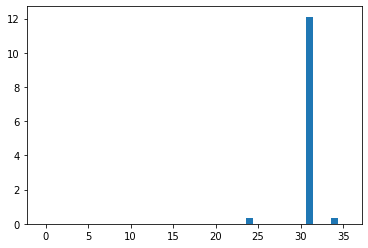

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010956538945071176, 0.3534455608620907, 0.010956538945071176, 0, 0, 0, 0, 0, 12.108645372715559, 0, 0.010956538945071176, 0.36440209980716187, 0]
Index: 21
value: 0.0038509326654774948
x, y, scale, mag: 66 689 0.37348607182502747 5.0
Index: 19
value: 0.13876117370283184
x, y, scale, mag: 66 690 0.37348607182502747 5.0
Index: 17
value: 0.0038509326654774948
x, y, scale, mag: 66 691 0.37348607182502747 5.0
Index: 27
value: 0.13876117370283184
x, y, scale, mag: 67 689 0.37348607182502747 5.0
Index: 24
value: 5.0
x, y, scale, mag: 67 690 0.37348607182502747 5.0
Index: 20
value: 0.13876117370283184
x, y, scale, mag: 67 691 0.37348607182502747 5.0
Index: 32
value: 0.0038509326654774948
x, y, scale, mag: 68 689 0.37348607182502747 5.0
Index: 32
value: 0.13876117370283184
x, y, scale, mag: 68 690 0.37348607182502747 5.0
Index: 32
value: 0.0038509326654774948
x, y, scale, mag: 68 691 0.37348607182502747 5.0


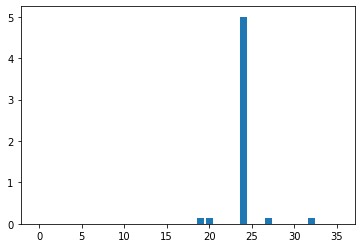

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0038509326654774948, 0, 0.13876117370283184, 0.13876117370283184, 0.0038509326654774948, 0, 0, 5.0, 0, 0, 0.13876117370283184, 0, 0, 0, 0, 0.14646303903378685, 0, 0, 0]
Index: 17
value: 0.00638106614353188
x, y, scale, mag: 66 691 0.3741983100771904 8.06225774829855
Index: 16
value: 0.22681666596195138
x, y, scale, mag: 66 692 0.3741983100771904 8.06225774829855
Index: 16
value: 0.00638106614353188
x, y, scale, mag: 66 693 0.3741983100771904 8.06225774829855
Index: 20
value: 0.22681666596195138
x, y, scale, mag: 67 691 0.3741983100771904 8.06225774829855
Index: 17
value: 8.06225774829855
x, y, scale, mag: 67 692 0.3741983100771904 8.06225774829855
Index: 16
value: 0.22681666596195138
x, y, scale, mag: 67 693 0.3741983100771904 8.06225774829855
Index: 32
value: 0.00638106614353188
x, y, scale, mag: 68 691 0.3741983100771904 8.06225774829855
Index: 30
value: 0.22681666596195138
x, y, scale, mag: 68 692 0.3741983100771904 8.0

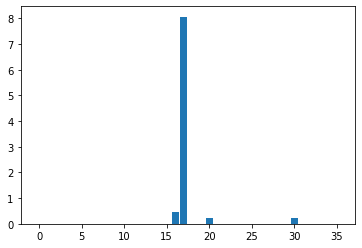

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00638106614353188, 0, 0, 0.4600143980674346, 8.068638814442082, 0, 0, 0.22681666596195138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22681666596195138, 0, 0.00638106614353188, 0, 0, 0]
Index: 27
value: 0.008038173226710178
x, y, scale, mag: 67 689 0.3748701810836792 9.899494936611665
Index: 24
value: 0.2820883818192888
x, y, scale, mag: 67 690 0.3748701810836792 9.899494936611665
Index: 20
value: 0.008038173226710178
x, y, scale, mag: 67 691 0.3748701810836792 9.899494936611665
Index: 32
value: 0.2820883818192888
x, y, scale, mag: 68 689 0.3748701810836792 9.899494936611665
Index: 32
value: 9.899494936611665
x, y, scale, mag: 68 690 0.3748701810836792 9.899494936611665
Index: 32
value: 0.2820883818192888
x, y, scale, mag: 68 691 0.3748701810836792 9.899494936611665
Index: 33
value: 0.008038173226710178
x, y, scale, mag: 69 689 0.3748701810836792 9.899494936611665
Index: 33
value: 0.2820883818192888
x, y, scale, mag: 69 690 0.3748701810836792 9.899

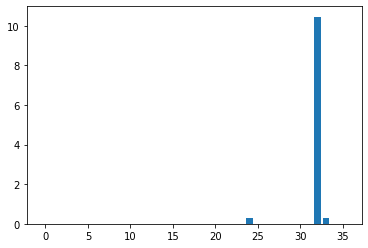

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008038173226710178, 0, 0, 0, 0.2820883818192888, 0, 0, 0.008038173226710178, 0, 0, 0, 0, 10.463671700250243, 0.2981647282727092, 0, 0]
Index: 17
value: 0.002167580956833943
x, y, scale, mag: 67 692 0.39281536638736725 1.4142135623730951
Index: 16
value: 0.05536625675170945
x, y, scale, mag: 67 693 0.39281536638736725 1.4142135623730951
Index: 16
value: 0.002167580956833943
x, y, scale, mag: 67 694 0.39281536638736725 1.4142135623730951
Index: 30
value: 0.05536625675170945
x, y, scale, mag: 68 692 0.39281536638736725 1.4142135623730951
Index: 13
value: 1.4142135623730951
x, y, scale, mag: 68 693 0.39281536638736725 1.4142135623730951
Index: 14
value: 0.05536625675170945
x, y, scale, mag: 68 694 0.39281536638736725 1.4142135623730951
Index: 34
value: 0.002167580956833943
x, y, scale, mag: 69 692 0.39281536638736725 1.4142135623730951
Index: 0
value: 0.05536625675170945
x, y, scale, mag: 69 693 0.39281536638736725 1.

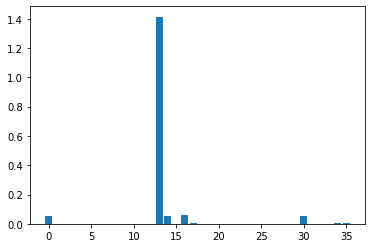

Histogram [0.05536625675170945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.4142135623730951, 0.05536625675170945, 0, 0.05753383770854339, 0.002167580956833943, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05536625675170945, 0, 0, 0, 0.002167580956833943, 0.002167580956833943]
Index: 32
value: 0.01298300327934195
x, y, scale, mag: 68 691 0.3857322782278061 10.770329614269007
Index: 30
value: 0.37394013518429425
x, y, scale, mag: 68 692 0.3857322782278061 10.770329614269007
Index: 13
value: 0.01298300327934195
x, y, scale, mag: 68 693 0.3857322782278061 10.770329614269007
Index: 33
value: 0.37394013518429425
x, y, scale, mag: 69 691 0.3857322782278061 10.770329614269007
Index: 34
value: 10.770329614269007
x, y, scale, mag: 69 692 0.3857322782278061 10.770329614269007
Index: 0
value: 0.37394013518429425
x, y, scale, mag: 69 693 0.3857322782278061 10.770329614269007
Index: 34
value: 0.01298300327934195
x, y, scale, mag: 70 691 0.3857322782278061 10.770329614269007
Index: 35
value: 0.37394013518429425


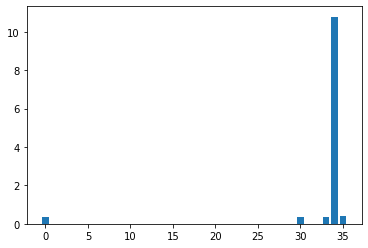

Histogram [0.37394013518429425, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01298300327934195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.37394013518429425, 0, 0.01298300327934195, 0.37394013518429425, 10.783312617548349, 0.3869231384636362]
Index: 22
value: 0.01108067933067065
x, y, scale, mag: 122 552 0.38564711809158325 9.219544457292887
Index: 21
value: 0.31962292737869175
x, y, scale, mag: 122 553 0.38564711809158325 9.219544457292887
Index: 21
value: 0.01108067933067065
x, y, scale, mag: 122 554 0.38564711809158325 9.219544457292887
Index: 23
value: 0.31962292737869175
x, y, scale, mag: 123 552 0.38564711809158325 9.219544457292887
Index: 23
value: 9.219544457292887
x, y, scale, mag: 123 553 0.38564711809158325 9.219544457292887
Index: 22
value: 0.31962292737869175
x, y, scale, mag: 123 554 0.38564711809158325 9.219544457292887
Index: 28
value: 0.01108067933067065
x, y, scale, mag: 124 552 0.38564711809158325 9.219544457292887
Index: 31
value: 0.31962292737869175
x, y, scale, ma

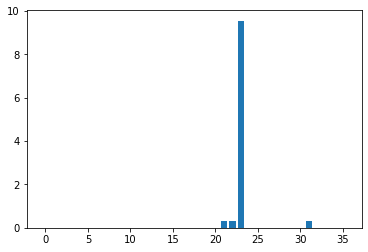

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3307036067093624, 0.3307036067093624, 9.539167384671579, 0, 0, 0, 0, 0.01108067933067065, 0, 0, 0.31962292737869175, 0, 0.01108067933067065, 0, 0]
Index: 22
value: 0.005690008631284549
x, y, scale, mag: 123 554 0.3790271580219269 6.0
Index: 21
value: 0.18477026759656784
x, y, scale, mag: 123 555 0.3790271580219269 6.0
Index: 14
value: 0.005690008631284549
x, y, scale, mag: 123 556 0.3790271580219269 6.0
Index: 33
value: 0.18477026759656784
x, y, scale, mag: 124 554 0.3790271580219269 6.0
Index: 0
value: 6.0
x, y, scale, mag: 124 555 0.3790271580219269 6.0
Index: 2
value: 0.18477026759656784
x, y, scale, mag: 124 556 0.3790271580219269 6.0
Index: 0
value: 0.005690008631284549
x, y, scale, mag: 125 554 0.3790271580219269 6.0
Index: 0
value: 0.18477026759656784
x, y, scale, mag: 125 555 0.3790271580219269 6.0
Index: 1
value: 0.005690008631284549
x, y, scale, mag: 125 556 0.3790271580219269 6.0


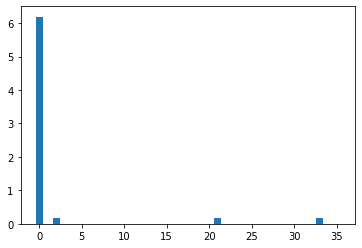

Histogram [6.190460276227852, 0.005690008631284549, 0.18477026759656784, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.005690008631284549, 0, 0, 0, 0, 0, 0, 0.18477026759656784, 0.005690008631284549, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.18477026759656784, 0, 0]
Index: 14
value: 0.00515259658899527
x, y, scale, mag: 123 556 0.3671044483780861 8.602325267042627
Index: 12
value: 0.2105333983680301
x, y, scale, mag: 123 557 0.3671044483780861 8.602325267042627
Index: 11
value: 0.00515259658899527
x, y, scale, mag: 123 558 0.3671044483780861 8.602325267042627
Index: 2
value: 0.2105333983680301
x, y, scale, mag: 124 556 0.3671044483780861 8.602325267042627
Index: 3
value: 8.602325267042627
x, y, scale, mag: 124 557 0.3671044483780861 8.602325267042627
Index: 4
value: 0.2105333983680301
x, y, scale, mag: 124 558 0.3671044483780861 8.602325267042627
Index: 1
value: 0.00515259658899527
x, y, scale, mag: 125 556 0.3671044483780861 8.602325267042627
Index: 1
value: 0.2105333983680301
x, y, scale, mag: 125 557 0.

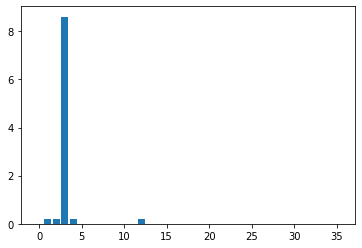

Histogram [0, 0.21568599495702537, 0.21568599495702537, 8.602325267042627, 0.2105333983680301, 0, 0, 0, 0, 0, 0, 0.00515259658899527, 0.2105333983680301, 0, 0.00515259658899527, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 24
value: 0.00994754500203808
x, y, scale, mag: 124 527 0.38179247081279755 9.486832980505138
Index: 23
value: 0.3071981412710596
x, y, scale, mag: 124 528 0.38179247081279755 9.486832980505138
Index: 6
value: 0.00994754500203808
x, y, scale, mag: 124 529 0.38179247081279755 9.486832980505138
Index: 34
value: 0.3071981412710596
x, y, scale, mag: 125 527 0.38179247081279755 9.486832980505138
Index: 1
value: 9.486832980505138
x, y, scale, mag: 125 528 0.38179247081279755 9.486832980505138
Index: 3
value: 0.3071981412710596
x, y, scale, mag: 125 529 0.38179247081279755 9.486832980505138
Index: 0
value: 0.00994754500203808
x, y, scale, mag: 126 527 0.38179247081279755 9.486832980505138
Index: 1
value: 0.3071981412710596
x, y, scale, mag: 126 528 

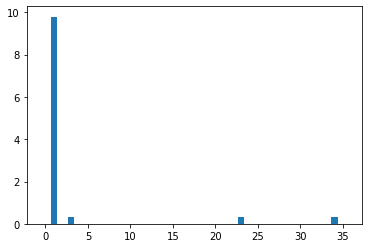

Histogram [0.00994754500203808, 9.794031121776198, 0.00994754500203808, 0.3071981412710596, 0, 0, 0.00994754500203808, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3071981412710596, 0.00994754500203808, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3071981412710596, 0]
Index: 22
value: 0.0025803230318898465
x, y, scale, mag: 124 740 0.37797631323337555 2.8284271247461903
Index: 16
value: 0.08542982883047684
x, y, scale, mag: 124 741 0.37797631323337555 2.8284271247461903
Index: 15
value: 0.0025803230318898465
x, y, scale, mag: 124 742 0.37797631323337555 2.8284271247461903
Index: 29
value: 0.08542982883047684
x, y, scale, mag: 125 740 0.37797631323337555 2.8284271247461903
Index: 23
value: 2.8284271247461903
x, y, scale, mag: 125 741 0.37797631323337555 2.8284271247461903
Index: 15
value: 0.08542982883047684
x, y, scale, mag: 125 742 0.37797631323337555 2.8284271247461903
Index: 31
value: 0.0025803230318898465
x, y, scale, mag: 126 740 0.37797631323337555 2.8284271247461903
Index: 31
value: 0.0854

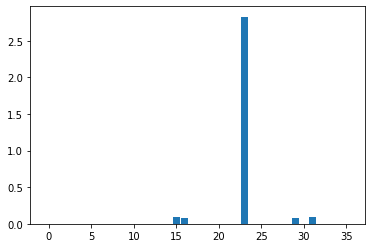

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08801015186236669, 0.08542982883047684, 0, 0, 0, 0, 0, 0.0025803230318898465, 2.8284271247461903, 0, 0, 0, 0, 0, 0.08542982883047684, 0, 0.08801015186236669, 0.0025803230318898465, 0, 0, 0]
Index: 25
value: 0.004424437892623697
x, y, scale, mag: 125 591 0.39165352284908295 3.0
Index: 20
value: 0.11520986797089514
x, y, scale, mag: 125 592 0.39165352284908295 3.0
Index: 11
value: 0.004424437892623697
x, y, scale, mag: 125 593 0.39165352284908295 3.0
Index: 25
value: 0.11520986797089514
x, y, scale, mag: 126 591 0.39165352284908295 3.0
Index: 18
value: 3.0
x, y, scale, mag: 126 592 0.39165352284908295 3.0
Index: 10
value: 0.11520986797089514
x, y, scale, mag: 126 593 0.39165352284908295 3.0
Index: 26
value: 0.004424437892623697
x, y, scale, mag: 127 591 0.39165352284908295 3.0
Index: 15
value: 0.11520986797089514
x, y, scale, mag: 127 592 0.39165352284908295 3.0
Index: 9
value: 0.004424437892623697
x, y, scale, mag: 127 593 0.3916

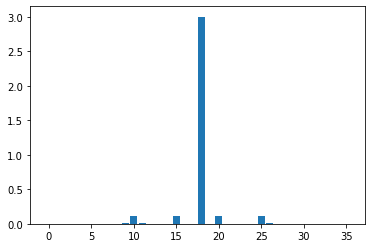

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004424437892623697, 0.11520986797089514, 0.004424437892623697, 0, 0, 0, 0.11520986797089514, 0, 0, 3.0, 0, 0.11520986797089514, 0, 0, 0, 0, 0.11963430586351884, 0.004424437892623697, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 23
value: 0.002189309770889444
x, y, scale, mag: 125 741 0.3931180089712143 1.4142135623730951
Index: 15
value: 0.05564307297613769
x, y, scale, mag: 125 742 0.3931180089712143 1.4142135623730951
Index: 14
value: 0.002189309770889444
x, y, scale, mag: 125 743 0.3931180089712143 1.4142135623730951
Index: 31
value: 0.05564307297613769
x, y, scale, mag: 126 741 0.3931180089712143 1.4142135623730951
Index: 32
value: 1.4142135623730951
x, y, scale, mag: 126 742 0.3931180089712143 1.4142135623730951
Index: 13
value: 0.05564307297613769
x, y, scale, mag: 126 743 0.3931180089712143 1.4142135623730951
Index: 33
value: 0.002189309770889444
x, y, scale, mag: 127 741 0.3931180089712143 1.4142135623730951
Index: 33
value: 0.05564307297613769
x, y

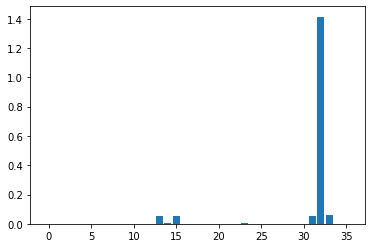

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05564307297613769, 0.002189309770889444, 0.05564307297613769, 0, 0, 0, 0, 0, 0, 0, 0.002189309770889444, 0, 0, 0, 0, 0, 0, 0, 0.05564307297613769, 1.4142135623730951, 0.06002169251791658, 0, 0]
Index: 25
value: 0.009625149947398793
x, y, scale, mag: 142 704 0.4173196703195572 3.0
Index: 12
value: 0.16992777831242417
x, y, scale, mag: 142 705 0.4173196703195572 3.0
Index: 10
value: 0.009625149947398793
x, y, scale, mag: 142 706 0.4173196703195572 3.0
Index: 28
value: 0.16992777831242417
x, y, scale, mag: 143 704 0.4173196703195572 3.0
Index: 9
value: 3.0
x, y, scale, mag: 143 705 0.4173196703195572 3.0
Index: 9
value: 0.16992777831242417
x, y, scale, mag: 143 706 0.4173196703195572 3.0
Index: 31
value: 0.009625149947398793
x, y, scale, mag: 144 704 0.4173196703195572 3.0
Index: 3
value: 0.16992777831242417
x, y, scale, mag: 144 705 0.4173196703195572 3.0
Index: 7
value: 0.009625149947398793
x, y, scale, mag: 144 706 0.4173196703195572 

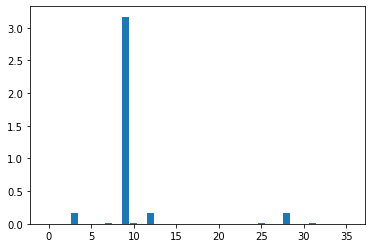

Histogram [0, 0, 0, 0.16992777831242417, 0, 0, 0, 0.009625149947398793, 0, 3.1699277783124242, 0.009625149947398793, 0, 0.16992777831242417, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009625149947398793, 0, 0, 0.16992777831242417, 0, 0, 0.009625149947398793, 0, 0, 0, 0]
Index: 15
value: 0.006387750320097624
x, y, scale, mag: 146 758 0.38041354715824127 6.4031242374328485
Index: 13
value: 0.2022413382503353
x, y, scale, mag: 146 759 0.38041354715824127 6.4031242374328485
Index: 13
value: 0.006387750320097624
x, y, scale, mag: 146 760 0.38041354715824127 6.4031242374328485
Index: 27
value: 0.2022413382503353
x, y, scale, mag: 147 758 0.38041354715824127 6.4031242374328485
Index: 14
value: 6.4031242374328485
x, y, scale, mag: 147 759 0.38041354715824127 6.4031242374328485
Index: 13
value: 0.2022413382503353
x, y, scale, mag: 147 760 0.38041354715824127 6.4031242374328485
Index: 30
value: 0.006387750320097624
x, y, scale, mag: 148 758 0.38041354715824127 6.4031242374328485
Index: 0
value: 0.202

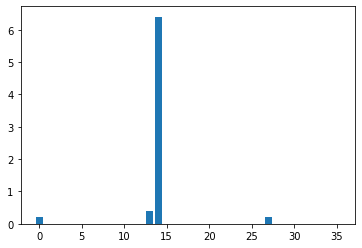

Histogram [0.2022413382503353, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006387750320097624, 0.41087042682076824, 6.4031242374328485, 0.006387750320097624, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2022413382503353, 0, 0, 0.006387750320097624, 0, 0, 0, 0, 0]
Index: 27
value: 0.001382925226842583
x, y, scale, mag: 147 758 0.3897353410720825 1.0
Index: 14
value: 0.03718770262926419
x, y, scale, mag: 147 759 0.3897353410720825 1.0
Index: 13
value: 0.001382925226842583
x, y, scale, mag: 147 760 0.3897353410720825 1.0
Index: 30
value: 0.03718770262926419
x, y, scale, mag: 148 758 0.3897353410720825 1.0
Index: 0
value: 1.0
x, y, scale, mag: 148 759 0.3897353410720825 1.0
Index: 12
value: 0.03718770262926419
x, y, scale, mag: 148 760 0.3897353410720825 1.0
Index: 32
value: 0.001382925226842583
x, y, scale, mag: 149 758 0.3897353410720825 1.0
Index: 33
value: 0.03718770262926419
x, y, scale, mag: 149 759 0.3897353410720825 1.0
Index: 2
value: 0.001382925226842583
x, y, scale, mag: 149 760 0.3897353410720825

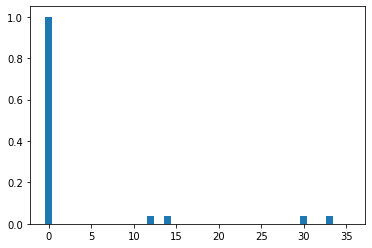

Histogram [1.0, 0, 0.001382925226842583, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03718770262926419, 0.001382925226842583, 0.03718770262926419, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001382925226842583, 0, 0, 0.03718770262926419, 0, 0.001382925226842583, 0.03718770262926419, 0, 0]
Index: 23
value: 0.001637013789408469
x, y, scale, mag: 148 672 0.36354806274175644 3.1622776601683795
Index: 22
value: 0.07194923304409843
x, y, scale, mag: 148 673 0.36354806274175644 3.1622776601683795
Index: 21
value: 0.001637013789408469
x, y, scale, mag: 148 674 0.36354806274175644 3.1622776601683795
Index: 27
value: 0.07194923304409843
x, y, scale, mag: 149 672 0.36354806274175644 3.1622776601683795
Index: 29
value: 3.1622776601683795
x, y, scale, mag: 149 673 0.36354806274175644 3.1622776601683795
Index: 0
value: 0.07194923304409843
x, y, scale, mag: 149 674 0.36354806274175644 3.1622776601683795
Index: 34
value: 0.001637013789408469
x, y, scale, mag: 150 672 0.36354806274175644 3.1622776601683795
Index: 0
value: 

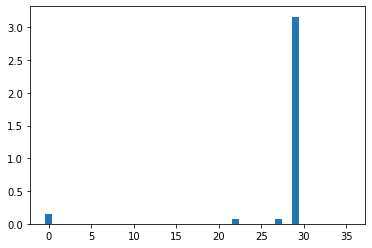

Histogram [0.14389846608819687, 0.001637013789408469, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001637013789408469, 0.07194923304409843, 0.001637013789408469, 0, 0, 0, 0.07194923304409843, 0, 3.1622776601683795, 0, 0, 0, 0, 0.001637013789408469, 0]
Index: 21
value: 0.005769777703214055
x, y, scale, mag: 149 542 0.37797631323337555 6.324555320336759
Index: 17
value: 0.19102690457111757
x, y, scale, mag: 149 543 0.37797631323337555 6.324555320336759
Index: 15
value: 0.005769777703214055
x, y, scale, mag: 149 544 0.37797631323337555 6.324555320336759
Index: 25
value: 0.19102690457111757
x, y, scale, mag: 150 542 0.37797631323337555 6.324555320336759
Index: 20
value: 6.324555320336759
x, y, scale, mag: 150 543 0.37797631323337555 6.324555320336759
Index: 15
value: 0.19102690457111757
x, y, scale, mag: 150 544 0.37797631323337555 6.324555320336759
Index: 30
value: 0.005769777703214055
x, y, scale, mag: 151 542 0.37797631323337555 6.324555320336759
Index: 28
value: 0.1910269

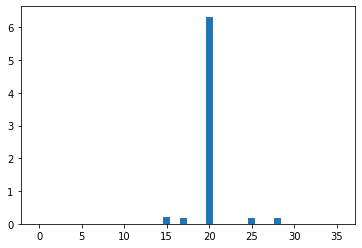

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1967966822743316, 0, 0.19102690457111757, 0.005769777703214055, 0, 6.324555320336759, 0.005769777703214055, 0, 0, 0, 0.19102690457111757, 0, 0, 0.19102690457111757, 0, 0.005769777703214055, 0, 0, 0, 0, 0]
Index: 20
value: 0.003649127827002285
x, y, scale, mag: 150 543 0.37797631323337555 4.0
Index: 15
value: 0.12081602256327238
x, y, scale, mag: 150 544 0.37797631323337555 4.0
Index: 14
value: 0.003649127827002285
x, y, scale, mag: 150 545 0.37797631323337555 4.0
Index: 28
value: 0.12081602256327238
x, y, scale, mag: 151 543 0.37797631323337555 4.0
Index: 18
value: 4.0
x, y, scale, mag: 151 544 0.37797631323337555 4.0
Index: 14
value: 0.12081602256327238
x, y, scale, mag: 151 545 0.37797631323337555 4.0
Index: 31
value: 0.003649127827002285
x, y, scale, mag: 152 543 0.37797631323337555 4.0
Index: 31
value: 0.12081602256327238
x, y, scale, mag: 152 544 0.37797631323337555 4.0
Index: 11
value: 0.003649127827002285
x, y, scale, mag

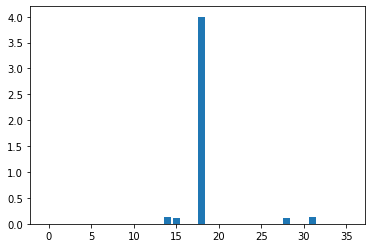

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003649127827002285, 0, 0, 0.12446515039027467, 0.12081602256327238, 0, 0, 4.0, 0, 0.003649127827002285, 0, 0, 0, 0, 0, 0, 0, 0.12081602256327238, 0, 0, 0.12446515039027467, 0, 0, 0, 0]
Index: 15
value: 0.010638944408695844
x, y, scale, mag: 164 705 0.37797631323337555 11.661903789690601
Index: 12
value: 0.35223620784649284
x, y, scale, mag: 164 706 0.37797631323337555 11.661903789690601
Index: 11
value: 0.010638944408695844
x, y, scale, mag: 164 707 0.37797631323337555 11.661903789690601
Index: 15
value: 0.35223620784649284
x, y, scale, mag: 165 705 0.37797631323337555 11.661903789690601
Index: 12
value: 11.661903789690601
x, y, scale, mag: 165 706 0.37797631323337555 11.661903789690601
Index: 11
value: 0.35223620784649284
x, y, scale, mag: 165 707 0.37797631323337555 11.661903789690601
Index: 18
value: 0.010638944408695844
x, y, scale, mag: 166 705 0.37797631323337555 11.661903789690601
Index: 10
value: 0.35223620784649284
x, y, scale, mag

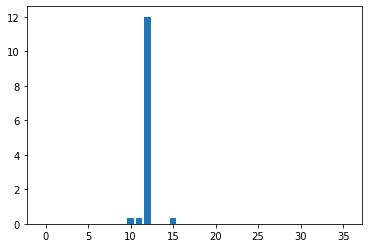

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3628751522551887, 0.3628751522551887, 12.014139997537095, 0, 0, 0.3628751522551887, 0, 0, 0.010638944408695844, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 15
value: 0.04655186684151699
x, y, scale, mag: 166 598 0.4242640882730484 12.041594578792296
Index: 14
value: 0.74870468636938
x, y, scale, mag: 166 599 0.4242640882730484 12.041594578792296
Index: 14
value: 0.04655186684151699
x, y, scale, mag: 166 600 0.4242640882730484 12.041594578792296
Index: 14
value: 0.74870468636938
x, y, scale, mag: 167 598 0.4242640882730484 12.041594578792296
Index: 13
value: 12.041594578792296
x, y, scale, mag: 167 599 0.4242640882730484 12.041594578792296
Index: 14
value: 0.74870468636938
x, y, scale, mag: 167 600 0.4242640882730484 12.041594578792296
Index: 3
value: 0.04655186684151699
x, y, scale, mag: 168 598 0.4242640882730484 12.041594578792296
Index: 7
value: 0.74870468636938
x, y, scale, mag: 168 599 0.4242640882730484 12.041594578792296
I

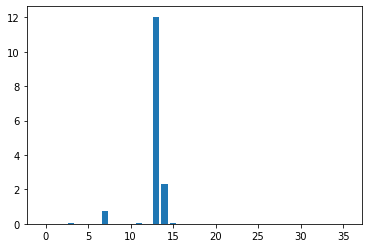

Histogram [0, 0, 0, 0.04655186684151699, 0, 0, 0, 0.74870468636938, 0, 0, 0, 0.04655186684151699, 0, 12.041594578792296, 2.292665925949657, 0.04655186684151699, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 28
value: 0.001005575506730189
x, y, scale, mag: 166 704 0.3602132946252823 2.23606797749979
Index: 18
value: 0.04741872193087346
x, y, scale, mag: 166 705 0.3602132946252823 2.23606797749979
Index: 10
value: 0.001005575506730189
x, y, scale, mag: 166 706 0.3602132946252823 2.23606797749979
Index: 30
value: 0.04741872193087346
x, y, scale, mag: 167 704 0.3602132946252823 2.23606797749979
Index: 34
value: 2.23606797749979
x, y, scale, mag: 167 705 0.3602132946252823 2.23606797749979
Index: 8
value: 0.04741872193087346
x, y, scale, mag: 167 706 0.3602132946252823 2.23606797749979
Index: 31
value: 0.001005575506730189
x, y, scale, mag: 168 704 0.3602132946252823 2.23606797749979
Index: 34
value: 0.04741872193087346
x, y, scale, mag: 168 705 0.3602132946252823 2.236

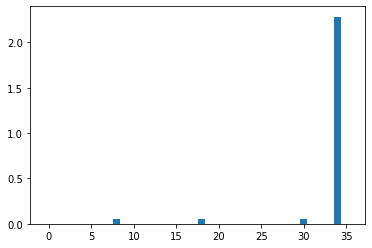

Histogram [0, 0, 0, 0, 0, 0, 0.001005575506730189, 0, 0.04741872193087346, 0, 0.001005575506730189, 0, 0, 0, 0, 0, 0, 0, 0.04741872193087346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001005575506730189, 0, 0.04741872193087346, 0.001005575506730189, 0, 0, 2.283486699430663, 0]
Index: 10
value: 0.008286451972737013
x, y, scale, mag: 167 596 0.389290988445282 6.082762530298219
Index: 13
value: 0.22450950886071722
x, y, scale, mag: 167 597 0.389290988445282 6.082762530298219
Index: 14
value: 0.008286451972737013
x, y, scale, mag: 167 598 0.389290988445282 6.082762530298219
Index: 0
value: 0.22450950886071722
x, y, scale, mag: 168 596 0.389290988445282 6.082762530298219
Index: 0
value: 6.082762530298219
x, y, scale, mag: 168 597 0.389290988445282 6.082762530298219
Index: 3
value: 0.22450950886071722
x, y, scale, mag: 168 598 0.389290988445282 6.082762530298219
Index: 0
value: 0.008286451972737013
x, y, scale, mag: 169 596 0.389290988445282 6.082762530298219
Index: 0
value: 0.22450950886071722
x, y, sca

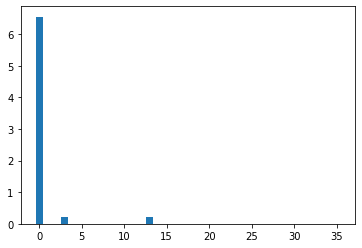

Histogram [6.548354451965127, 0, 0, 0.22450950886071722, 0, 0, 0, 0, 0, 0, 0.008286451972737013, 0, 0, 0.22450950886071722, 0.008286451972737013, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 3
value: 0.018456286796674822
x, y, scale, mag: 168 598 0.39281536638736725 12.041594578792296
Index: 7
value: 0.4714266889299707
x, y, scale, mag: 168 599 0.39281536638736725 12.041594578792296
Index: 11
value: 0.018456286796674822
x, y, scale, mag: 168 600 0.39281536638736725 12.041594578792296
Index: 0
value: 0.4714266889299707
x, y, scale, mag: 169 598 0.39281536638736725 12.041594578792296
Index: 0
value: 12.041594578792296
x, y, scale, mag: 169 599 0.39281536638736725 12.041594578792296
Index: 1
value: 0.4714266889299707
x, y, scale, mag: 169 600 0.39281536638736725 12.041594578792296
Index: 0
value: 0.018456286796674822
x, y, scale, mag: 170 598 0.39281536638736725 12.041594578792296
Index: 0
value: 0.4714266889299707
x, y, scale, mag: 170 599 0.39281536638736725 12.

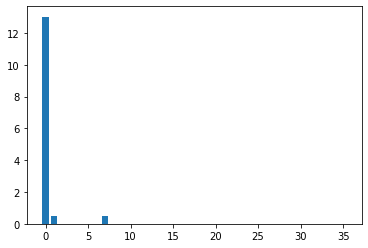

Histogram [13.021360530245584, 0.4714266889299707, 0, 0.018456286796674822, 0, 0, 0, 0.4714266889299707, 0, 0, 0, 0.018456286796674822, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 0.00907569965668594
x, y, scale, mag: 168 600 0.39420756697654724 5.656854249492381
Index: 13
value: 0.22658311978177104
x, y, scale, mag: 168 601 0.39420756697654724 5.656854249492381
Index: 13
value: 0.00907569965668594
x, y, scale, mag: 168 602 0.39420756697654724 5.656854249492381
Index: 1
value: 0.22658311978177104
x, y, scale, mag: 169 600 0.39420756697654724 5.656854249492381
Index: 4
value: 5.656854249492381
x, y, scale, mag: 169 601 0.39420756697654724 5.656854249492381
Index: 9
value: 0.22658311978177104
x, y, scale, mag: 169 602 0.39420756697654724 5.656854249492381
Index: 0
value: 0.00907569965668594
x, y, scale, mag: 170 600 0.39420756697654724 5.656854249492381
Index: 0
value: 0.22658311978177104
x, y, scale, mag: 170 601 0.39420756697654724 5.6568542

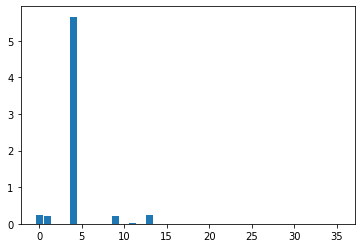

Histogram [0.24473451909514293, 0.22658311978177104, 0, 0, 5.656854249492381, 0, 0, 0, 0, 0.22658311978177104, 0, 0.00907569965668594, 0, 0.23565881943845698, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 34
value: 0.01563592735063774
x, y, scale, mag: 172 609 0.3938858360052109 9.848857801796104
Index: 16
value: 0.3924232728517074
x, y, scale, mag: 172 610 0.3938858360052109 9.848857801796104
Index: 15
value: 0.01563592735063774
x, y, scale, mag: 172 611 0.3938858360052109 9.848857801796104
Index: 34
value: 0.3924232728517074
x, y, scale, mag: 173 609 0.3938858360052109 9.848857801796104
Index: 34
value: 9.848857801796104
x, y, scale, mag: 173 610 0.3938858360052109 9.848857801796104
Index: 35
value: 0.3924232728517074
x, y, scale, mag: 173 611 0.3938858360052109 9.848857801796104
Index: 34
value: 0.01563592735063774
x, y, scale, mag: 174 609 0.3938858360052109 9.848857801796104
Index: 34
value: 0.3924232728517074
x, y, scale, mag: 174 610 0.3938858360052109

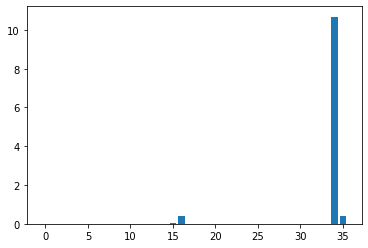

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01563592735063774, 0.3924232728517074, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.680612129551433, 0.3924232728517074]
Index: 14
value: 0.007580329309447934
x, y, scale, mag: 173 614 0.3796594887971878 7.810249675906654
Index: 14
value: 0.24331926461417194
x, y, scale, mag: 173 615 0.3796594887971878 7.810249675906654
Index: 14
value: 0.007580329309447934
x, y, scale, mag: 173 616 0.3796594887971878 7.810249675906654
Index: 9
value: 0.24331926461417194
x, y, scale, mag: 174 614 0.3796594887971878 7.810249675906654
Index: 12
value: 7.810249675906654
x, y, scale, mag: 174 615 0.3796594887971878 7.810249675906654
Index: 14
value: 0.24331926461417194
x, y, scale, mag: 174 616 0.3796594887971878 7.810249675906654
Index: 35
value: 0.007580329309447934
x, y, scale, mag: 175 614 0.3796594887971878 7.810249675906654
Index: 0
value: 0.24331926461417194
x, y, scale, mag: 175 615 0.3796594887971878 7.810249675906654
Index: 9
valu

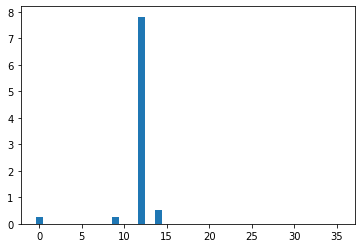

Histogram [0.24331926461417194, 0, 0, 0, 0, 0, 0, 0, 0, 0.2508995939236199, 0, 0, 7.810249675906654, 0, 0.5017991878472398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.007580329309447934]
Index: 14
value: 0.006450807579724617
x, y, scale, mag: 174 616 0.37797631323337555 7.0710678118654755
Index: 14
value: 0.2135745720761921
x, y, scale, mag: 174 617 0.37797631323337555 7.0710678118654755
Index: 14
value: 0.006450807579724617
x, y, scale, mag: 174 618 0.37797631323337555 7.0710678118654755
Index: 9
value: 0.2135745720761921
x, y, scale, mag: 175 616 0.37797631323337555 7.0710678118654755
Index: 13
value: 7.0710678118654755
x, y, scale, mag: 175 617 0.37797631323337555 7.0710678118654755
Index: 14
value: 0.2135745720761921
x, y, scale, mag: 175 618 0.37797631323337555 7.0710678118654755
Index: 35
value: 0.006450807579724617
x, y, scale, mag: 176 616 0.37797631323337555 7.0710678118654755
Index: 35
value: 0.2135745720761921
x, y, scale, mag: 176 617 0.37797631323337555 

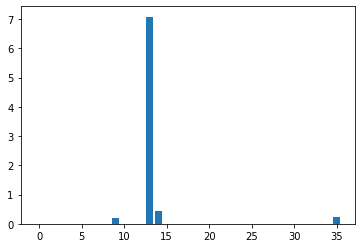

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2135745720761921, 0, 0, 0, 7.0775186194452, 0.4400507593118334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2200253796559167]
Index: 29
value: 0.009064860346582344
x, y, scale, mag: 179 621 0.37821565568447113 9.848857801796104
Index: 24
value: 0.29879511466325825
x, y, scale, mag: 179 622 0.37821565568447113 9.848857801796104
Index: 18
value: 0.009064860346582344
x, y, scale, mag: 179 623 0.37821565568447113 9.848857801796104
Index: 30
value: 0.29879511466325825
x, y, scale, mag: 180 621 0.37821565568447113 9.848857801796104
Index: 30
value: 9.848857801796104
x, y, scale, mag: 180 622 0.37821565568447113 9.848857801796104
Index: 26
value: 0.29879511466325825
x, y, scale, mag: 180 623 0.37821565568447113 9.848857801796104
Index: 31
value: 0.009064860346582344
x, y, scale, mag: 181 621 0.37821565568447113 9.848857801796104
Index: 31
value: 0.29879511466325825
x, y, scale, mag: 181 622 0.37821565568447113 9.848857801796104
Index: 

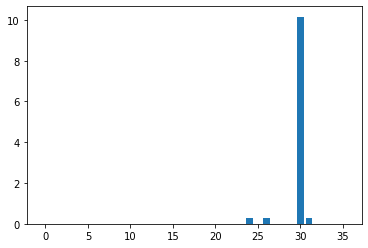

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009064860346582344, 0, 0, 0, 0, 0, 0.29879511466325825, 0, 0.29879511466325825, 0, 0, 0.009064860346582344, 10.156717776805944, 0.3078599750098406, 0, 0, 0, 0]
Index: 26
value: 0.0007286155020239058
x, y, scale, mag: 179 704 0.36343366652727127 1.4142135623730951
Index: 23
value: 0.032100123437729784
x, y, scale, mag: 179 705 0.36343366652727127 1.4142135623730951
Index: 10
value: 0.0007286155020239058
x, y, scale, mag: 179 706 0.36343366652727127 1.4142135623730951
Index: 26
value: 0.032100123437729784
x, y, scale, mag: 180 704 0.36343366652727127 1.4142135623730951
Index: 23
value: 1.4142135623730951
x, y, scale, mag: 180 705 0.36343366652727127 1.4142135623730951
Index: 9
value: 0.032100123437729784
x, y, scale, mag: 180 706 0.36343366652727127 1.4142135623730951
Index: 27
value: 0.0007286155020239058
x, y, scale, mag: 181 704 0.36343366652727127 1.4142135623730951
Index: 0
value: 0.032100123437729784
x, y, scale, ma

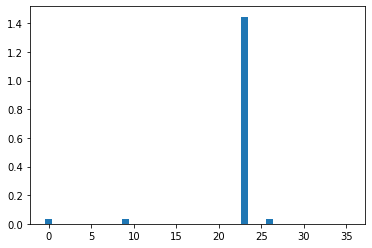

Histogram [0.032100123437729784, 0, 0, 0, 0, 0, 0, 0, 0.0007286155020239058, 0.032100123437729784, 0.0007286155020239058, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.446313685810825, 0, 0, 0.03282873893975369, 0.0007286155020239058, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 26
value: 0.004912788687676977
x, y, scale, mag: 180 623 0.37797631323337555 5.385164807134504
Index: 20
value: 0.16265354821142564
x, y, scale, mag: 180 624 0.37797631323337555 5.385164807134504
Index: 16
value: 0.004912788687676977
x, y, scale, mag: 180 625 0.37797631323337555 5.385164807134504
Index: 30
value: 0.16265354821142564
x, y, scale, mag: 181 623 0.37797631323337555 5.385164807134504
Index: 30
value: 5.385164807134504
x, y, scale, mag: 181 624 0.37797631323337555 5.385164807134504
Index: 23
value: 0.16265354821142564
x, y, scale, mag: 181 625 0.37797631323337555 5.385164807134504
Index: 32
value: 0.004912788687676977
x, y, scale, mag: 182 623 0.37797631323337555 5.385164807134504
Index: 32
value: 0.16265354821142564
x, y

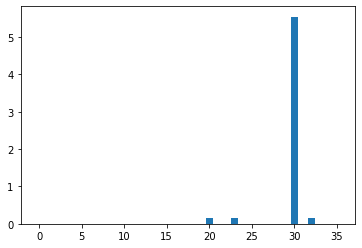

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004912788687676977, 0, 0, 0, 0.16265354821142564, 0, 0, 0.16265354821142564, 0, 0, 0.004912788687676977, 0, 0, 0, 5.547818355345929, 0, 0.1675663368991026, 0.004912788687676977, 0, 0]
Index: 21
value: 0.007725736978999232
x, y, scale, mag: 181 481 0.3777371495962143 8.54400374531753
Index: 12
value: 0.25692163335131507
x, y, scale, mag: 181 482 0.3777371495962143 8.54400374531753
Index: 10
value: 0.007725736978999232
x, y, scale, mag: 181 483 0.3777371495962143 8.54400374531753
Index: 21
value: 0.25692163335131507
x, y, scale, mag: 182 481 0.3777371495962143 8.54400374531753
Index: 11
value: 8.54400374531753
x, y, scale, mag: 182 482 0.3777371495962143 8.54400374531753
Index: 9
value: 0.25692163335131507
x, y, scale, mag: 182 483 0.3777371495962143 8.54400374531753
Index: 20
value: 0.007725736978999232
x, y, scale, mag: 183 481 0.3777371495962143 8.54400374531753
Index: 9
value: 0.25692163335131507
x, y, scale, mag: 183 482 0

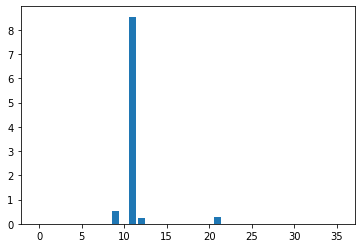

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5215690036816294, 0.007725736978999232, 8.54400374531753, 0.25692163335131507, 0, 0, 0, 0, 0, 0, 0, 0.007725736978999232, 0.2646473703303143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 26
value: 0.00164724361357043
x, y, scale, mag: 182 480 0.3636978194117546 3.1622776601683795
Index: 21
value: 0.07217369105185632
x, y, scale, mag: 182 481 0.3636978194117546 3.1622776601683795
Index: 11
value: 0.00164724361357043
x, y, scale, mag: 182 482 0.3636978194117546 3.1622776601683795
Index: 26
value: 0.07217369105185632
x, y, scale, mag: 183 480 0.3636978194117546 3.1622776601683795
Index: 20
value: 3.1622776601683795
x, y, scale, mag: 183 481 0.3636978194117546 3.1622776601683795
Index: 9
value: 0.07217369105185632
x, y, scale, mag: 183 482 0.3636978194117546 3.1622776601683795
Index: 26
value: 0.00164724361357043
x, y, scale, mag: 184 480 0.3636978194117546 3.1622776601683795
Index: 18
value: 0.07217369105185632
x, y, scale, mag: 184 481 0.363697

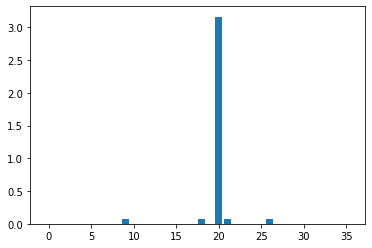

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07382093466542675, 0, 0.00164724361357043, 0, 0, 0, 0, 0, 0, 0.07217369105185632, 0, 3.1622776601683795, 0.07217369105185632, 0, 0, 0, 0, 0.07546817827899717, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 0.0038917309557945394
x, y, scale, mag: 184 589 0.37889912724494934 4.123105625617661
Index: 25
value: 0.12667287711750633
x, y, scale, mag: 184 590 0.37889912724494934 4.123105625617661
Index: 9
value: 0.0038917309557945394
x, y, scale, mag: 184 591 0.37889912724494934 4.123105625617661
Index: 27
value: 0.12667287711750633
x, y, scale, mag: 185 589 0.37889912724494934 4.123105625617661
Index: 26
value: 4.123105625617661
x, y, scale, mag: 185 590 0.37889912724494934 4.123105625617661
Index: 9
value: 0.12667287711750633
x, y, scale, mag: 185 591 0.37889912724494934 4.123105625617661
Index: 26
value: 0.0038917309557945394
x, y, scale, mag: 186 589 0.37889912724494934 4.123105625617661
Index: 26
value: 0.12667287711750633
x, y, scale, mag: 186 590 0.

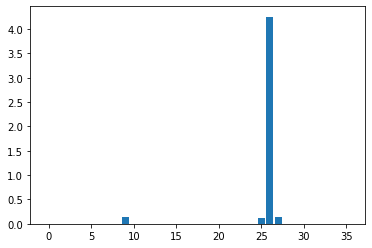

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1344563390290954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12667287711750633, 4.253670233690962, 0.13056460807330086, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 26
value: 0.0014748126308745655
x, y, scale, mag: 187 589 0.39165352284908295 1.0
Index: 21
value: 0.03840328932363171
x, y, scale, mag: 187 590 0.39165352284908295 1.0
Index: 9
value: 0.0014748126308745655
x, y, scale, mag: 187 591 0.39165352284908295 1.0
Index: 26
value: 0.03840328932363171
x, y, scale, mag: 188 589 0.39165352284908295 1.0
Index: 18
value: 1.0
x, y, scale, mag: 188 590 0.39165352284908295 1.0
Index: 9
value: 0.03840328932363171
x, y, scale, mag: 188 591 0.39165352284908295 1.0
Index: 26
value: 0.0014748126308745655
x, y, scale, mag: 189 589 0.39165352284908295 1.0
Index: 18
value: 0.03840328932363171
x, y, scale, mag: 189 590 0.39165352284908295 1.0
Index: 9
value: 0.0014748126308745655
x, y, scale, mag: 189 591 0.39165352284908295 1.0


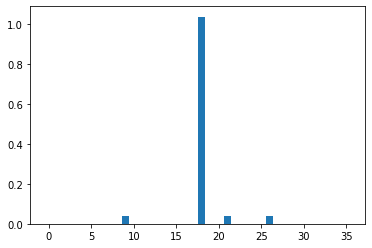

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.041352914585380846, 0, 0, 0, 0, 0, 0, 0, 0, 1.0384032893236317, 0, 0, 0.03840328932363171, 0, 0, 0, 0, 0.041352914585380846, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.005610309586859123
x, y, scale, mag: 189 705 0.3636978194117546 10.770329614269007
Index: 11
value: 0.24581473407541324
x, y, scale, mag: 189 706 0.3636978194117546 10.770329614269007
Index: 10
value: 0.005610309586859123
x, y, scale, mag: 189 707 0.3636978194117546 10.770329614269007
Index: 22
value: 0.24581473407541324
x, y, scale, mag: 190 705 0.3636978194117546 10.770329614269007
Index: 11
value: 10.770329614269007
x, y, scale, mag: 190 706 0.3636978194117546 10.770329614269007
Index: 10
value: 0.24581473407541324
x, y, scale, mag: 190 707 0.3636978194117546 10.770329614269007
Index: 25
value: 0.005610309586859123
x, y, scale, mag: 191 705 0.3636978194117546 10.770329614269007
Index: 9
value: 0.24581473407541324
x, y, scale, mag: 191 706 0.3636978194117546 10.770329614269007

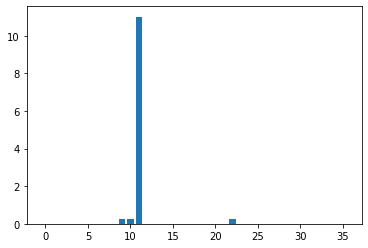

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25142504366227236, 0.25142504366227236, 11.01614434834442, 0, 0, 0, 0, 0, 0, 0, 0, 0.005610309586859123, 0, 0.24581473407541324, 0, 0, 0.005610309586859123, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 26
value: 0.0030815655657683017
x, y, scale, mag: 190 589 0.3929746448993683 2.0
Index: 15
value: 0.07850561210217143
x, y, scale, mag: 190 590 0.3929746448993683 2.0
Index: 9
value: 0.0030815655657683017
x, y, scale, mag: 190 591 0.3929746448993683 2.0
Index: 27
value: 0.07850561210217143
x, y, scale, mag: 191 589 0.3929746448993683 2.0
Index: 9
value: 2.0
x, y, scale, mag: 191 590 0.3929746448993683 2.0
Index: 8
value: 0.07850561210217143
x, y, scale, mag: 191 591 0.3929746448993683 2.0
Index: 27
value: 0.0030815655657683017
x, y, scale, mag: 192 589 0.3929746448993683 2.0
Index: 7
value: 0.07850561210217143
x, y, scale, mag: 192 590 0.3929746448993683 2.0
Index: 8
value: 0.0030815655657683017
x, y, scale, mag: 192 591 0.3929746448993683 2.0


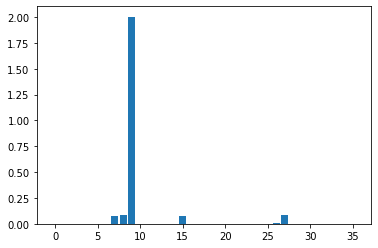

Histogram [0, 0, 0, 0, 0, 0, 0, 0.07850561210217143, 0.08158717766793973, 2.0030815655657683, 0, 0, 0, 0, 0, 0.07850561210217143, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0030815655657683017, 0.08158717766793973, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 0.009074678396990703
x, y, scale, mag: 192 704 0.4173196703195572 2.8284271247461903
Index: 27
value: 0.160209445808906
x, y, scale, mag: 192 705 0.4173196703195572 2.8284271247461903
Index: 9
value: 0.009074678396990703
x, y, scale, mag: 192 706 0.4173196703195572 2.8284271247461903
Index: 28
value: 0.160209445808906
x, y, scale, mag: 193 704 0.4173196703195572 2.8284271247461903
Index: 32
value: 2.8284271247461903
x, y, scale, mag: 193 705 0.4173196703195572 2.8284271247461903
Index: 7
value: 0.160209445808906
x, y, scale, mag: 193 706 0.4173196703195572 2.8284271247461903
Index: 29
value: 0.009074678396990703
x, y, scale, mag: 194 704 0.4173196703195572 2.8284271247461903
Index: 35
value: 0.160209445808906
x, y, scale, mag: 194 705 0.41731967

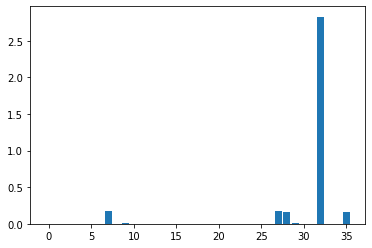

Histogram [0, 0, 0, 0, 0, 0, 0, 0.1692841242058967, 0, 0.009074678396990703, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1692841242058967, 0.160209445808906, 0.009074678396990703, 0, 0, 2.8284271247461903, 0, 0, 0.160209445808906]
Index: 27
value: 0.009922823459074076
x, y, scale, mag: 192 705 0.38252055644989014 9.219544457292887
Index: 9
value: 0.3024630754700518
x, y, scale, mag: 192 706 0.38252055644989014 9.219544457292887
Index: 9
value: 0.009922823459074076
x, y, scale, mag: 192 707 0.38252055644989014 9.219544457292887
Index: 32
value: 0.3024630754700518
x, y, scale, mag: 193 705 0.38252055644989014 9.219544457292887
Index: 7
value: 9.219544457292887
x, y, scale, mag: 193 706 0.38252055644989014 9.219544457292887
Index: 8
value: 0.3024630754700518
x, y, scale, mag: 193 707 0.38252055644989014 9.219544457292887
Index: 35
value: 0.009922823459074076
x, y, scale, mag: 194 705 0.38252055644989014 9.219544457292887
Index: 7
value: 0.3024630754700518
x, y, scale, mag: 194 70

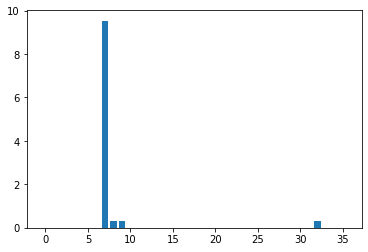

Histogram [0, 0, 0, 0, 0, 0, 0, 9.531930356222013, 0.3024630754700518, 0.3123858989291259, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009922823459074076, 0, 0, 0, 0, 0.3024630754700518, 0, 0, 0.009922823459074076]
Index: 26
value: 0.010334234899236348
x, y, scale, mag: 193 589 0.38917534053325653 7.615773105863909
Index: 7
value: 0.28054088510462144
x, y, scale, mag: 193 590 0.38917534053325653 7.615773105863909
Index: 7
value: 0.010334234899236348
x, y, scale, mag: 193 591 0.38917534053325653 7.615773105863909
Index: 29
value: 0.28054088510462144
x, y, scale, mag: 194 589 0.38917534053325653 7.615773105863909
Index: 6
value: 7.615773105863909
x, y, scale, mag: 194 590 0.38917534053325653 7.615773105863909
Index: 7
value: 0.28054088510462144
x, y, scale, mag: 194 591 0.38917534053325653 7.615773105863909
Index: 34
value: 0.010334234899236348
x, y, scale, mag: 195 589 0.38917534053325653 7.615773105863909
Index: 6
value: 0.28054088510462144
x, y, scale, mag: 195 590 0.38917534

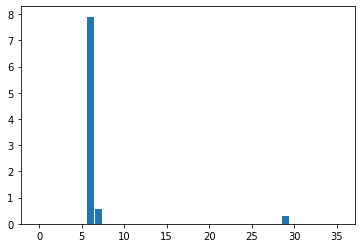

Histogram [0, 0, 0, 0, 0, 0, 7.906648225867767, 0.5714160051084792, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010334234899236348, 0, 0, 0.28054088510462144, 0, 0, 0, 0, 0.010334234899236348, 0]
Index: 26
value: 0.002494190678552723
x, y, scale, mag: 202 520 0.37706297636032104 2.8284271247461903
Index: 20
value: 0.0839918839502224
x, y, scale, mag: 202 521 0.37706297636032104 2.8284271247461903
Index: 12
value: 0.002494190678552723
x, y, scale, mag: 202 522 0.37706297636032104 2.8284271247461903
Index: 27
value: 0.0839918839502224
x, y, scale, mag: 203 520 0.37706297636032104 2.8284271247461903
Index: 23
value: 2.8284271247461903
x, y, scale, mag: 203 521 0.37706297636032104 2.8284271247461903
Index: 11
value: 0.0839918839502224
x, y, scale, mag: 203 522 0.37706297636032104 2.8284271247461903
Index: 28
value: 0.002494190678552723
x, y, scale, mag: 204 520 0.37706297636032104 2.8284271247461903
Index: 29
value: 0.0839918839502224
x, y, scale, mag: 204 521 0.377062976360321

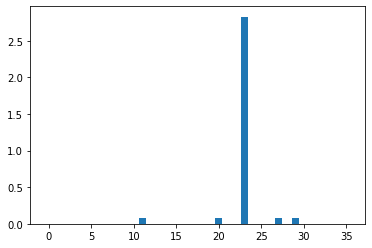

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002494190678552723, 0, 0.0839918839502224, 0.002494190678552723, 0, 0, 0, 0, 0, 0, 0, 0.0839918839502224, 0, 0, 2.8284271247461903, 0, 0, 0.002494190678552723, 0.0839918839502224, 0.002494190678552723, 0.0839918839502224, 0, 0, 0, 0, 0, 0]
Index: 28
value: 0.018719532184931248
x, y, scale, mag: 204 519 0.3895930051803589 13.601470508735444
Index: 28
value: 0.5045920777723986
x, y, scale, mag: 204 520 0.3895930051803589 13.601470508735444
Index: 29
value: 0.018719532184931248
x, y, scale, mag: 204 521 0.3895930051803589 13.601470508735444
Index: 29
value: 0.5045920777723986
x, y, scale, mag: 205 519 0.3895930051803589 13.601470508735444
Index: 29
value: 13.601470508735444
x, y, scale, mag: 205 520 0.3895930051803589 13.601470508735444
Index: 32
value: 0.5045920777723986
x, y, scale, mag: 205 521 0.3895930051803589 13.601470508735444
Index: 29
value: 0.018719532184931248
x, y, scale, mag: 206 519 0.3895930051803589 13.601470508735444
Index: 29
valu

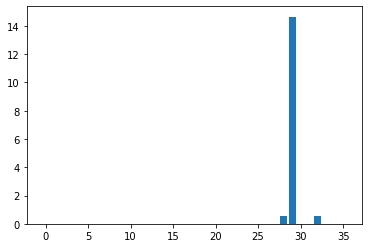

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5233116099573298, 14.648093728650105, 0, 0, 0.5233116099573298, 0, 0, 0]
Index: 29
value: 0.004232595001451764
x, y, scale, mag: 205 520 0.3727347403764725 5.656854249492381
Index: 32
value: 0.15473581686326737
x, y, scale, mag: 205 521 0.3727347403764725 5.656854249492381
Index: 6
value: 0.004232595001451764
x, y, scale, mag: 205 522 0.3727347403764725 5.656854249492381
Index: 29
value: 0.15473581686326737
x, y, scale, mag: 206 520 0.3727347403764725 5.656854249492381
Index: 32
value: 5.656854249492381
x, y, scale, mag: 206 521 0.3727347403764725 5.656854249492381
Index: 6
value: 0.15473581686326737
x, y, scale, mag: 206 522 0.3727347403764725 5.656854249492381
Index: 29
value: 0.004232595001451764
x, y, scale, mag: 207 520 0.3727347403764725 5.656854249492381
Index: 33
value: 0.15473581686326737
x, y, scale, mag: 207 521 0.3727347403764725 5.656854249492381
Index: 6
value: 0.0042325950014

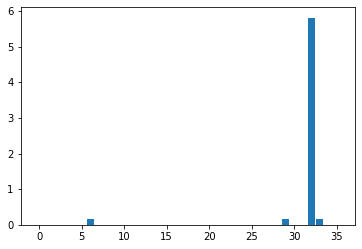

Histogram [0, 0, 0, 0, 0, 0, 0.1632010068661709, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1632010068661709, 0, 0, 5.811590066355648, 0.15473581686326737, 0, 0]
Index: 12
value: 0.01592556199523702
x, y, scale, mag: 205 657 0.39160269498825073 10.816653826391969
Index: 13
value: 0.4150437219055638
x, y, scale, mag: 205 658 0.39160269498825073 10.816653826391969
Index: 13
value: 0.01592556199523702
x, y, scale, mag: 205 659 0.39160269498825073 10.816653826391969
Index: 10
value: 0.4150437219055638
x, y, scale, mag: 206 657 0.39160269498825073 10.816653826391969
Index: 12
value: 10.816653826391969
x, y, scale, mag: 206 658 0.39160269498825073 10.816653826391969
Index: 13
value: 0.4150437219055638
x, y, scale, mag: 206 659 0.39160269498825073 10.816653826391969
Index: 0
value: 0.01592556199523702
x, y, scale, mag: 207 657 0.39160269498825073 10.816653826391969
Index: 7
value: 0.4150437219055638
x, y, scale, mag: 207 658 0.39160269498825073 10.816653826391969
Inde

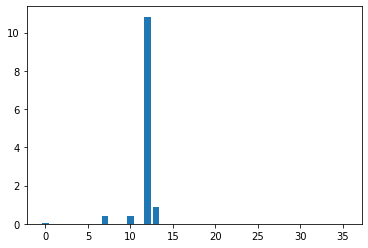

Histogram [0.01592556199523702, 0, 0, 0, 0, 0, 0, 0.4150437219055638, 0, 0, 0.4150437219055638, 0, 10.832579388387206, 0.8619385678016016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 1
value: 0.011344624570857425
x, y, scale, mag: 206 656 0.39420756697654724 7.0710678118654755
Index: 10
value: 0.2832288997272138
x, y, scale, mag: 206 657 0.39420756697654724 7.0710678118654755
Index: 12
value: 0.011344624570857425
x, y, scale, mag: 206 658 0.39420756697654724 7.0710678118654755
Index: 35
value: 0.2832288997272138
x, y, scale, mag: 207 656 0.39420756697654724 7.0710678118654755
Index: 0
value: 7.0710678118654755
x, y, scale, mag: 207 657 0.39420756697654724 7.0710678118654755
Index: 7
value: 0.2832288997272138
x, y, scale, mag: 207 658 0.39420756697654724 7.0710678118654755
Index: 34
value: 0.011344624570857425
x, y, scale, mag: 208 656 0.39420756697654724 7.0710678118654755
Index: 34
value: 0.2832288997272138
x, y, scale, mag: 208 657 0.39420756697654724 7.0

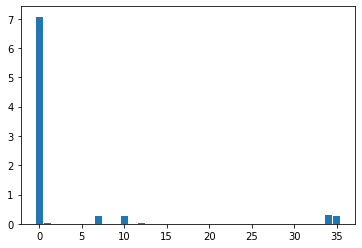

Histogram [7.0710678118654755, 0.011344624570857425, 0, 0, 0, 0, 0, 0.2832288997272138, 0, 0, 0.2832288997272138, 0, 0.011344624570857425, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3059181488689287, 0.2832288997272138]
Index: 12
value: 0.014230529907377358
x, y, scale, mag: 206 658 0.39302846789360046 9.219544457292887
Index: 13
value: 0.36221402945206527
x, y, scale, mag: 206 659 0.39302846789360046 9.219544457292887
Index: 13
value: 0.014230529907377358
x, y, scale, mag: 206 660 0.39302846789360046 9.219544457292887
Index: 7
value: 0.36221402945206527
x, y, scale, mag: 207 658 0.39302846789360046 9.219544457292887
Index: 13
value: 9.219544457292887
x, y, scale, mag: 207 659 0.39302846789360046 9.219544457292887
Index: 13
value: 0.36221402945206527
x, y, scale, mag: 207 660 0.39302846789360046 9.219544457292887
Index: 34
value: 0.014230529907377358
x, y, scale, mag: 208 658 0.39302846789360046 9.219544457292887
Index: 0
value: 0.36221402945206527
x, y, scale, ma

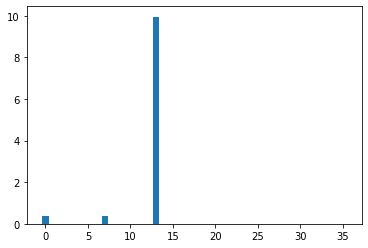

Histogram [0.36221402945206527, 0, 0, 0, 0, 0, 0, 0.36221402945206527, 0, 0, 0, 0, 0.014230529907377358, 9.958203046104396, 0.014230529907377358, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.014230529907377358, 0]
Index: 27
value: 0.0058414547086422484
x, y, scale, mag: 208 586 0.37797631323337555 6.4031242374328485
Index: 9
value: 0.19340000058628082
x, y, scale, mag: 208 587 0.37797631323337555 6.4031242374328485
Index: 8
value: 0.0058414547086422484
x, y, scale, mag: 208 588 0.37797631323337555 6.4031242374328485
Index: 31
value: 0.19340000058628082
x, y, scale, mag: 209 586 0.37797631323337555 6.4031242374328485
Index: 5
value: 6.4031242374328485
x, y, scale, mag: 209 587 0.37797631323337555 6.4031242374328485
Index: 7
value: 0.19340000058628082
x, y, scale, mag: 209 588 0.37797631323337555 6.4031242374328485
Index: 34
value: 0.0058414547086422484
x, y, scale, mag: 210 586 0.37797631323337555 6.4031242374328485
Index: 4
value: 0.19340000058628082
x, y, scale, mag: 210

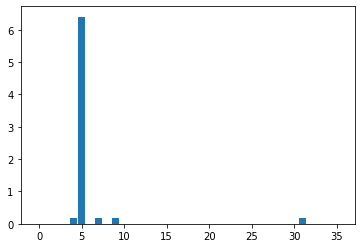

Histogram [0, 0, 0, 0, 0.19340000058628082, 6.4031242374328485, 0.0058414547086422484, 0.19340000058628082, 0.0058414547086422484, 0.19340000058628082, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0058414547086422484, 0, 0, 0, 0.19340000058628082, 0, 0, 0.0058414547086422484, 0]
Index: 34
value: 0.008410824057848038
x, y, scale, mag: 208 658 0.37797631323337555 9.219544457292887
Index: 0
value: 0.2784671727938476
x, y, scale, mag: 208 659 0.37797631323337555 9.219544457292887
Index: 14
value: 0.008410824057848038
x, y, scale, mag: 208 660 0.37797631323337555 9.219544457292887
Index: 32
value: 0.2784671727938476
x, y, scale, mag: 209 658 0.37797631323337555 9.219544457292887
Index: 32
value: 9.219544457292887
x, y, scale, mag: 209 659 0.37797631323337555 9.219544457292887
Index: 23
value: 0.2784671727938476
x, y, scale, mag: 209 660 0.37797631323337555 9.219544457292887
Index: 32
value: 0.008410824057848038
x, y, scale, mag: 210 658 0.37797631323337555 9.219544457292887
Index: 3

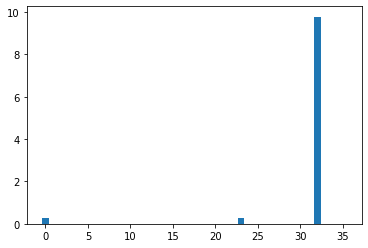

Histogram [0.2784671727938476, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008410824057848038, 0, 0, 0, 0, 0, 0, 0, 0, 0.2784671727938476, 0, 0, 0, 0, 0, 0, 0.008410824057848038, 0, 9.78488962693843, 0, 0.008410824057848038, 0]
Index: 15
value: 0.029356188865831558
x, y, scale, mag: 209 661 0.41983164846897125 8.54400374531753
Index: 14
value: 0.5008187173198638
x, y, scale, mag: 209 662 0.41983164846897125 8.54400374531753
Index: 14
value: 0.029356188865831558
x, y, scale, mag: 209 663 0.41983164846897125 8.54400374531753
Index: 24
value: 0.5008187173198638
x, y, scale, mag: 210 661 0.41983164846897125 8.54400374531753
Index: 15
value: 8.54400374531753
x, y, scale, mag: 210 662 0.41983164846897125 8.54400374531753
Index: 15
value: 0.5008187173198638
x, y, scale, mag: 210 663 0.41983164846897125 8.54400374531753
Index: 30
value: 0.029356188865831558
x, y, scale, mag: 211 661 0.41983164846897125 8.54400374531753
Index: 25
value: 0.5008187173198638
x, y, scale, mag: 211 662 0.41983164846897

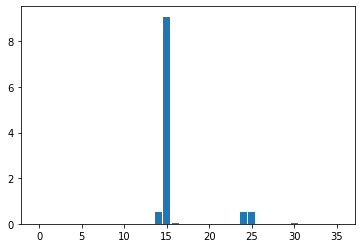

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5301749061856954, 9.074178651503226, 0.029356188865831558, 0, 0, 0, 0, 0, 0, 0, 0.5008187173198638, 0.5008187173198638, 0, 0, 0, 0, 0.029356188865831558, 0, 0, 0, 0, 0]
Index: 25
value: 0.0076635559667405295
x, y, scale, mag: 210 67 0.39281536638736725 5.0
Index: 21
value: 0.1957492779902461
x, y, scale, mag: 210 68 0.39281536638736725 5.0
Index: 13
value: 0.0076635559667405295
x, y, scale, mag: 210 69 0.39281536638736725 5.0
Index: 26
value: 0.1957492779902461
x, y, scale, mag: 211 67 0.39281536638736725 5.0
Index: 22
value: 5.0
x, y, scale, mag: 211 68 0.39281536638736725 5.0
Index: 12
value: 0.1957492779902461
x, y, scale, mag: 211 69 0.39281536638736725 5.0
Index: 27
value: 0.0076635559667405295
x, y, scale, mag: 212 67 0.39281536638736725 5.0
Index: 26
value: 0.1957492779902461
x, y, scale, mag: 212 68 0.39281536638736725 5.0
Index: 11
value: 0.0076635559667405295
x, y, scale, mag: 212 69 0.39281536638736725 5.0


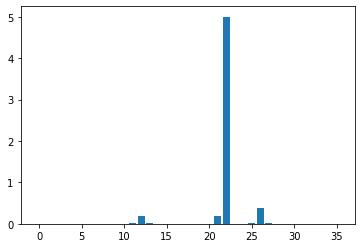

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0076635559667405295, 0.1957492779902461, 0.0076635559667405295, 0, 0, 0, 0, 0, 0, 0, 0.1957492779902461, 5.0, 0, 0, 0.0076635559667405295, 0.3914985559804922, 0.0076635559667405295, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 30
value: 0.00828459976236274
x, y, scale, mag: 210 660 0.3746323138475418 10.295630140987
Index: 24
value: 0.292053377003923
x, y, scale, mag: 210 661 0.3746323138475418 10.295630140987
Index: 15
value: 0.00828459976236274
x, y, scale, mag: 210 662 0.3746323138475418 10.295630140987
Index: 31
value: 0.292053377003923
x, y, scale, mag: 211 660 0.3746323138475418 10.295630140987
Index: 30
value: 10.295630140987
x, y, scale, mag: 211 661 0.3746323138475418 10.295630140987
Index: 25
value: 0.292053377003923
x, y, scale, mag: 211 662 0.3746323138475418 10.295630140987
Index: 31
value: 0.00828459976236274
x, y, scale, mag: 212 660 0.3746323138475418 10.295630140987
Index: 31
value: 0.292053377003923
x, y, scale, mag: 212 661 0.374632313

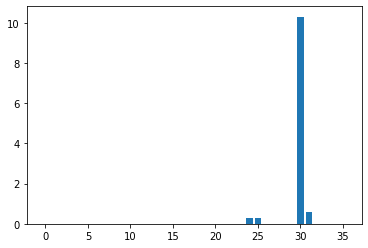

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00828459976236274, 0, 0, 0, 0, 0, 0, 0, 0, 0.292053377003923, 0.292053377003923, 0, 0, 0, 0, 10.312199340511725, 0.5923913537702087, 0, 0, 0, 0]
Index: 22
value: 0.021945084608038946
x, y, scale, mag: 210 693 0.39281536638736725 14.317821063276353
Index: 22
value: 0.5605406271059767
x, y, scale, mag: 210 694 0.39281536638736725 14.317821063276353
Index: 22
value: 0.021945084608038946
x, y, scale, mag: 210 695 0.39281536638736725 14.317821063276353
Index: 26
value: 0.5605406271059767
x, y, scale, mag: 211 693 0.39281536638736725 14.317821063276353
Index: 25
value: 14.317821063276353
x, y, scale, mag: 211 694 0.39281536638736725 14.317821063276353
Index: 24
value: 0.5605406271059767
x, y, scale, mag: 211 695 0.39281536638736725 14.317821063276353
Index: 30
value: 0.021945084608038946
x, y, scale, mag: 212 693 0.39281536638736725 14.317821063276353
Index: 29
value: 0.5605406271059767
x, y, scale, mag: 212 694 0.39281536638736725 14

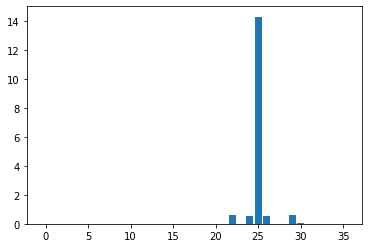

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6044307963220545, 0, 0.5605406271059767, 14.317821063276353, 0.5605406271059767, 0, 0, 0.5824857117140156, 0.021945084608038946, 0, 0, 0, 0, 0]
Index: 15
value: 0.02760396587336742
x, y, scale, mag: 212 665 0.40298688411712646 13.038404810405298
Index: 14
value: 0.5999263966767735
x, y, scale, mag: 212 666 0.40298688411712646 13.038404810405298
Index: 14
value: 0.02760396587336742
x, y, scale, mag: 212 667 0.40298688411712646 13.038404810405298
Index: 17
value: 0.5999263966767735
x, y, scale, mag: 213 665 0.40298688411712646 13.038404810405298
Index: 14
value: 13.038404810405298
x, y, scale, mag: 213 666 0.40298688411712646 13.038404810405298
Index: 14
value: 0.5999263966767735
x, y, scale, mag: 213 667 0.40298688411712646 13.038404810405298
Index: 31
value: 0.02760396587336742
x, y, scale, mag: 214 665 0.40298688411712646 13.038404810405298
Index: 14
value: 0.5999263966767735
x, y, scale, mag: 214 666 0.402

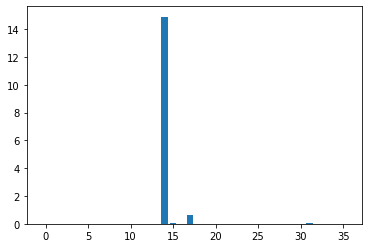

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14.893391932182354, 0.02760396587336742, 0, 0.5999263966767735, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02760396587336742, 0, 0, 0, 0]
Index: 14
value: 0.014130898987263297
x, y, scale, mag: 215 669 0.39281536638736725 9.219544457292887
Index: 14
value: 0.36094383418281156
x, y, scale, mag: 215 670 0.39281536638736725 9.219544457292887
Index: 14
value: 0.014130898987263297
x, y, scale, mag: 215 671 0.39281536638736725 9.219544457292887
Index: 11
value: 0.36094383418281156
x, y, scale, mag: 216 669 0.39281536638736725 9.219544457292887
Index: 13
value: 9.219544457292887
x, y, scale, mag: 216 670 0.39281536638736725 9.219544457292887
Index: 14
value: 0.36094383418281156
x, y, scale, mag: 216 671 0.39281536638736725 9.219544457292887
Index: 35
value: 0.014130898987263297
x, y, scale, mag: 217 669 0.39281536638736725 9.219544457292887
Index: 0
value: 0.36094383418281156
x, y, scale, mag: 217 670 0.39281536638736725 9.219544457292887
Ind

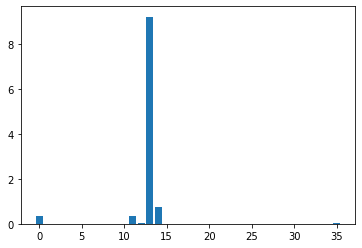

Histogram [0.36094383418281156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.36094383418281156, 0.014130898987263297, 9.219544457292887, 0.7501494663401497, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.014130898987263297]
Index: 35
value: 0.016366000162056474
x, y, scale, mag: 216 668 0.3964493125677109 9.486832980505138
Index: 11
value: 0.394032371888846
x, y, scale, mag: 216 669 0.3964493125677109 9.486832980505138
Index: 13
value: 0.016366000162056474
x, y, scale, mag: 216 670 0.3964493125677109 9.486832980505138
Index: 34
value: 0.394032371888846
x, y, scale, mag: 217 668 0.3964493125677109 9.486832980505138
Index: 35
value: 9.486832980505138
x, y, scale, mag: 217 669 0.3964493125677109 9.486832980505138
Index: 0
value: 0.394032371888846
x, y, scale, mag: 217 670 0.3964493125677109 9.486832980505138
Index: 34
value: 0.016366000162056474
x, y, scale, mag: 218 668 0.3964493125677109 9.486832980505138
Index: 34
value: 0.394032371888846
x, y, scale, mag: 218 669 0.3964493125677109 

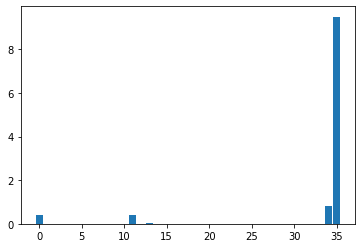

Histogram [0.394032371888846, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.394032371888846, 0, 0.016366000162056474, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8207967441018049, 9.503198980667195]
Index: 15
value: 0.01546368847976474
x, y, scale, mag: 218 673 0.4242640882730484 4.0
Index: 14
value: 0.24870615979315622
x, y, scale, mag: 218 674 0.4242640882730484 4.0
Index: 15
value: 0.01546368847976474
x, y, scale, mag: 218 675 0.4242640882730484 4.0
Index: 32
value: 0.24870615979315622
x, y, scale, mag: 219 673 0.4242640882730484 4.0
Index: 18
value: 4.0
x, y, scale, mag: 219 674 0.4242640882730484 4.0
Index: 16
value: 0.24870615979315622
x, y, scale, mag: 219 675 0.4242640882730484 4.0
Index: 32
value: 0.01546368847976474
x, y, scale, mag: 220 673 0.4242640882730484 4.0
Index: 31
value: 0.24870615979315622
x, y, scale, mag: 220 674 0.4242640882730484 4.0
Index: 26
value: 0.01546368847976474
x, y, scale, mag: 220 675 0.4242640882730484 4.0


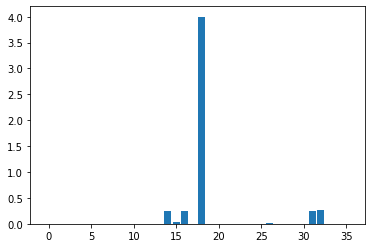

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24870615979315622, 0.03092737695952948, 0.24870615979315622, 0, 4.0, 0, 0, 0, 0, 0, 0, 0, 0.01546368847976474, 0, 0, 0, 0, 0.24870615979315622, 0.26416984827292095, 0, 0, 0]
Index: 33
value: 0.03163120432434447
x, y, scale, mag: 219 672 0.40315067768096924 14.866068747318506
Index: 32
value: 0.6857343932210075
x, y, scale, mag: 219 673 0.40315067768096924 14.866068747318506
Index: 18
value: 0.03163120432434447
x, y, scale, mag: 219 674 0.40315067768096924 14.866068747318506
Index: 33
value: 0.6857343932210075
x, y, scale, mag: 220 672 0.40315067768096924 14.866068747318506
Index: 32
value: 14.866068747318506
x, y, scale, mag: 220 673 0.40315067768096924 14.866068747318506
Index: 31
value: 0.6857343932210075
x, y, scale, mag: 220 674 0.40315067768096924 14.866068747318506
Index: 33
value: 0.03163120432434447
x, y, scale, mag: 221 672 0.40315067768096924 14.866068747318506
Index: 33
value: 0.6857343932210075
x, y, scale, mag: 221 673

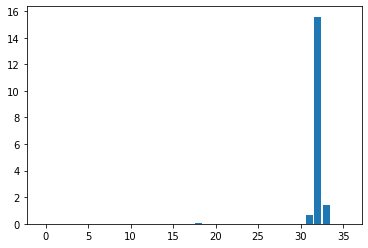

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03163120432434447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6857343932210075, 15.583434344863859, 1.434731195090704, 0, 0]
Index: 16
value: 0.027336197465494854
x, y, scale, mag: 219 675 0.4242640882730484 7.0710678118654755
Index: 15
value: 0.43965453028151463
x, y, scale, mag: 219 676 0.4242640882730484 7.0710678118654755
Index: 15
value: 0.027336197465494854
x, y, scale, mag: 219 677 0.4242640882730484 7.0710678118654755
Index: 26
value: 0.43965453028151463
x, y, scale, mag: 220 675 0.4242640882730484 7.0710678118654755
Index: 17
value: 7.0710678118654755
x, y, scale, mag: 220 676 0.4242640882730484 7.0710678118654755
Index: 15
value: 0.43965453028151463
x, y, scale, mag: 220 677 0.4242640882730484 7.0710678118654755
Index: 31
value: 0.027336197465494854
x, y, scale, mag: 221 675 0.4242640882730484 7.0710678118654755
Index: 28
value: 0.43965453028151463
x, y, scale, mag: 221 676 0.4242640882730484 7.0710678118654755
Ind

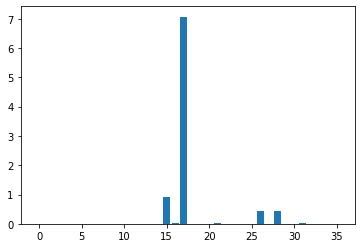

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9066452580285241, 0.027336197465494854, 7.0710678118654755, 0, 0, 0, 0.027336197465494854, 0, 0, 0, 0, 0.43965453028151463, 0, 0.43965453028151463, 0, 0, 0.027336197465494854, 0, 0, 0, 0]
Index: 15
value: 0.03917508245210413
x, y, scale, mag: 220 677 0.41983164846897125 11.40175425099138
Index: 15
value: 0.6683297560944119
x, y, scale, mag: 220 678 0.41983164846897125 11.40175425099138
Index: 15
value: 0.03917508245210413
x, y, scale, mag: 220 679 0.41983164846897125 11.40175425099138
Index: 21
value: 0.6683297560944119
x, y, scale, mag: 221 677 0.41983164846897125 11.40175425099138
Index: 16
value: 11.40175425099138
x, y, scale, mag: 221 678 0.41983164846897125 11.40175425099138
Index: 15
value: 0.6683297560944119
x, y, scale, mag: 221 679 0.41983164846897125 11.40175425099138
Index: 30
value: 0.03917508245210413
x, y, scale, mag: 222 677 0.41983164846897125 11.40175425099138
Index: 23
value: 0.6683297560944119
x, y, scale, mag

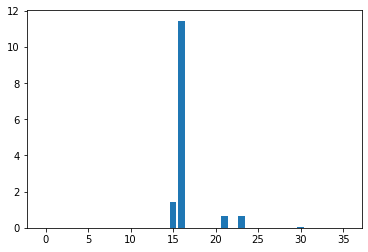

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.415009677093032, 11.440929333443483, 0, 0, 0, 0, 0.6683297560944119, 0, 0.6683297560944119, 0, 0, 0, 0, 0, 0, 0.03917508245210413, 0, 0, 0, 0, 0]
Index: 27
value: 0.00963280475394741
x, y, scale, mag: 270 524 0.389290988445282 7.0710678118654755
Index: 26
value: 0.2609870028059295
x, y, scale, mag: 270 525 0.389290988445282 7.0710678118654755
Index: 13
value: 0.00963280475394741
x, y, scale, mag: 270 526 0.389290988445282 7.0710678118654755
Index: 27
value: 0.2609870028059295
x, y, scale, mag: 271 524 0.389290988445282 7.0710678118654755
Index: 27
value: 7.0710678118654755
x, y, scale, mag: 271 525 0.389290988445282 7.0710678118654755
Index: 10
value: 0.2609870028059295
x, y, scale, mag: 271 526 0.389290988445282 7.0710678118654755
Index: 28
value: 0.00963280475394741
x, y, scale, mag: 272 524 0.389290988445282 7.0710678118654755
Index: 28
value: 0.2609870028059295
x, y, scale, mag: 272 525 0.389290988445282 7.0710678118654755
I

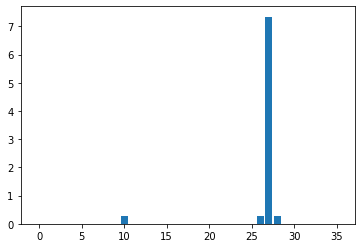

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00963280475394741, 0.2609870028059295, 0, 0, 0.00963280475394741, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2609870028059295, 7.341687619425352, 0.2706198075598769, 0, 0, 0, 0, 0, 0, 0]
Index: 28
value: 0.008654666554821082
x, y, scale, mag: 272 524 0.37797631323337555 9.486832980505138
Index: 28
value: 0.28654035685667634
x, y, scale, mag: 272 525 0.37797631323337555 9.486832980505138
Index: 9
value: 0.008654666554821082
x, y, scale, mag: 272 526 0.37797631323337555 9.486832980505138
Index: 29
value: 0.28654035685667634
x, y, scale, mag: 273 524 0.37797631323337555 9.486832980505138
Index: 29
value: 9.486832980505138
x, y, scale, mag: 273 525 0.37797631323337555 9.486832980505138
Index: 4
value: 0.28654035685667634
x, y, scale, mag: 273 526 0.37797631323337555 9.486832980505138
Index: 29
value: 0.008654666554821082
x, y, scale, mag: 274 524 0.37797631323337555 9.486832980505138
Index: 30
value: 0.28654035685667634
x, y, scale, mag: 274 525 0.3779763

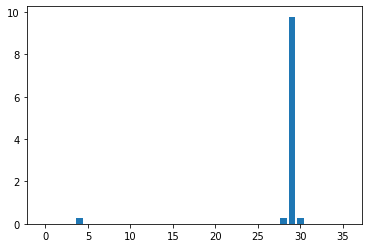

Histogram [0.008654666554821082, 0, 0, 0, 0.28654035685667634, 0, 0, 0, 0, 0.008654666554821082, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2951950234114974, 9.782028003916636, 0.28654035685667634, 0, 0, 0, 0, 0]
Index: 27
value: 0.002035487919366855
x, y, scale, mag: 281 63 0.3624133765697479 4.123105625617661
Index: 26
value: 0.09161076187445591
x, y, scale, mag: 281 64 0.3624133765697479 4.123105625617661
Index: 9
value: 0.002035487919366855
x, y, scale, mag: 281 65 0.3624133765697479 4.123105625617661
Index: 27
value: 0.09161076187445591
x, y, scale, mag: 282 63 0.3624133765697479 4.123105625617661
Index: 26
value: 4.123105625617661
x, y, scale, mag: 282 64 0.3624133765697479 4.123105625617661
Index: 9
value: 0.09161076187445591
x, y, scale, mag: 282 65 0.3624133765697479 4.123105625617661
Index: 27
value: 0.002035487919366855
x, y, scale, mag: 283 63 0.3624133765697479 4.123105625617661
Index: 27
value: 0.09161076187445591
x, y, scale, mag: 283 64 0.3624133765697479 4

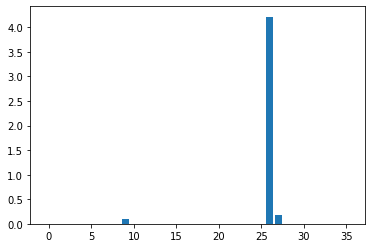

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09568173771318961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.214716387492117, 0.18729249958764552, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 21
value: 0.0029206232479276335
x, y, scale, mag: 284 725 0.4139462113380432 1.0
Index: 19
value: 0.054042790896914585
x, y, scale, mag: 284 726 0.4139462113380432 1.0
Index: 17
value: 0.0029206232479276335
x, y, scale, mag: 284 727 0.4139462113380432 1.0
Index: 25
value: 0.054042790896914585
x, y, scale, mag: 285 725 0.4139462113380432 1.0
Index: 18
value: 1.0
x, y, scale, mag: 285 726 0.4139462113380432 1.0
Index: 7
value: 0.054042790896914585
x, y, scale, mag: 285 727 0.4139462113380432 1.0
Index: 35
value: 0.0029206232479276335
x, y, scale, mag: 286 725 0.4139462113380432 1.0
Index: 1
value: 0.054042790896914585
x, y, scale, mag: 286 726 0.4139462113380432 1.0
Index: 2
value: 0.0029206232479276335
x, y, scale, mag: 286 727 0.4139462113380432 1.0


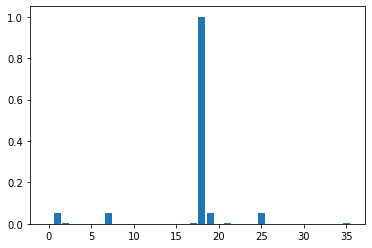

Histogram [0, 0.054042790896914585, 0.0029206232479276335, 0, 0, 0, 0, 0.054042790896914585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0029206232479276335, 1.0, 0.054042790896914585, 0, 0.0029206232479276335, 0, 0, 0, 0.054042790896914585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0029206232479276335]
Index: 27
value: 0.0028848888516070275
x, y, scale, mag: 285 63 0.37797631323337555 3.1622776601683795
Index: 27
value: 0.09551345228555878
x, y, scale, mag: 285 64 0.37797631323337555 3.1622776601683795
Index: 9
value: 0.0028848888516070275
x, y, scale, mag: 285 65 0.37797631323337555 3.1622776601683795
Index: 28
value: 0.09551345228555878
x, y, scale, mag: 286 63 0.37797631323337555 3.1622776601683795
Index: 29
value: 3.1622776601683795
x, y, scale, mag: 286 64 0.37797631323337555 3.1622776601683795
Index: 7
value: 0.09551345228555878
x, y, scale, mag: 286 65 0.37797631323337555 3.1622776601683795
Index: 28
value: 0.0028848888516070275
x, y, scale, mag: 287 63 0.37797631323337555 3.1622776601683795
Index: 33
val

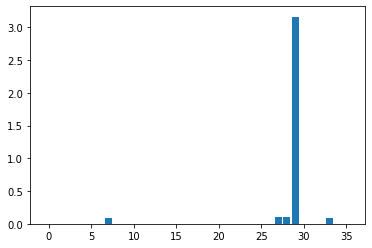

Histogram [0, 0, 0, 0, 0, 0, 0.0028848888516070275, 0.09551345228555878, 0, 0.0028848888516070275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0983983411371658, 0.0983983411371658, 3.1622776601683795, 0, 0, 0, 0.09551345228555878, 0, 0]
Index: 21
value: 0.0032396323583724004
x, y, scale, mag: 290 708 0.36423276364803314 6.082762530298219
Index: 20
value: 0.14037775579289366
x, y, scale, mag: 290 709 0.36423276364803314 6.082762530298219
Index: 18
value: 0.0032396323583724004
x, y, scale, mag: 290 710 0.36423276364803314 6.082762530298219
Index: 0
value: 0.14037775579289366
x, y, scale, mag: 291 708 0.36423276364803314 6.082762530298219
Index: 0
value: 6.082762530298219
x, y, scale, mag: 291 709 0.36423276364803314 6.082762530298219
Index: 1
value: 0.14037775579289366
x, y, scale, mag: 291 710 0.36423276364803314 6.082762530298219
Index: 1
value: 0.0032396323583724004
x, y, scale, mag: 292 708 0.36423276364803314 6.082762530298219
Index: 1
value: 0.14037775579289366
x, y, scale

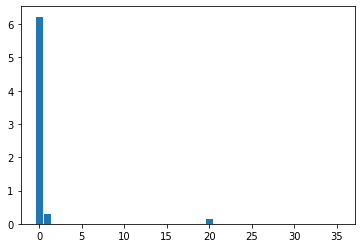

Histogram [6.223140286091113, 0.2872347763025321, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0032396323583724004, 0, 0.14037775579289366, 0.0032396323583724004, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.016495633646735553
x, y, scale, mag: 291 694 0.3886646032333374 12.36931687685298
Index: 20
value: 0.4517075598890835
x, y, scale, mag: 291 695 0.3886646032333374 12.36931687685298
Index: 20
value: 0.016495633646735553
x, y, scale, mag: 291 696 0.3886646032333374 12.36931687685298
Index: 20
value: 0.4517075598890835
x, y, scale, mag: 292 694 0.3886646032333374 12.36931687685298
Index: 20
value: 12.36931687685298
x, y, scale, mag: 292 695 0.3886646032333374 12.36931687685298
Index: 20
value: 0.4517075598890835
x, y, scale, mag: 292 696 0.3886646032333374 12.36931687685298
Index: 24
value: 0.016495633646735553
x, y, scale, mag: 293 694 0.3886646032333374 12.36931687685298
Index: 27
value: 0.4517075598890835
x, y, scale, mag: 293 695 0.3886646032333374 12.36931687

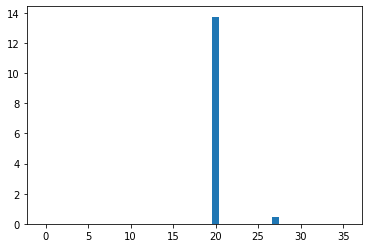

Histogram [0.016495633646735553, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.757430823813703, 0, 0, 0, 0.016495633646735553, 0, 0, 0.4517075598890835, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 19
value: 0.003761434868027768
x, y, scale, mag: 291 700 0.37797631323337555 4.123105625617661
Index: 18
value: 0.12453430557384464
x, y, scale, mag: 291 701 0.37797631323337555 4.123105625617661
Index: 19
value: 0.003761434868027768
x, y, scale, mag: 291 702 0.37797631323337555 4.123105625617661
Index: 18
value: 0.12453430557384464
x, y, scale, mag: 292 700 0.37797631323337555 4.123105625617661
Index: 16
value: 4.123105625617661
x, y, scale, mag: 292 701 0.37797631323337555 4.123105625617661
Index: 13
value: 0.12453430557384464
x, y, scale, mag: 292 702 0.37797631323337555 4.123105625617661
Index: 0
value: 0.003761434868027768
x, y, scale, mag: 293 700 0.37797631323337555 4.123105625617661
Index: 1
value: 0.12453430557384464
x, y, scale, mag: 293 701 0.37797631323337555 4.123105625617661
In

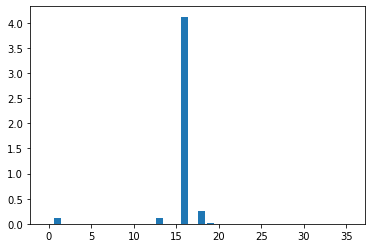

Histogram [0.003761434868027768, 0.12453430557384464, 0.003761434868027768, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12453430557384464, 0, 0, 4.123105625617661, 0, 0.24906861114768927, 0.007522869736055536, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 19
value: 0.005593870092638418
x, y, scale, mag: 292 697 0.38917015492916107 4.123105625617661
Index: 18
value: 0.15186875007035466
x, y, scale, mag: 292 698 0.38917015492916107 4.123105625617661
Index: 18
value: 0.005593870092638418
x, y, scale, mag: 292 699 0.38917015492916107 4.123105625617661
Index: 0
value: 0.15186875007035466
x, y, scale, mag: 293 697 0.38917015492916107 4.123105625617661
Index: 1
value: 4.123105625617661
x, y, scale, mag: 293 698 0.38917015492916107 4.123105625617661
Index: 2
value: 0.15186875007035466
x, y, scale, mag: 293 699 0.38917015492916107 4.123105625617661
Index: 0
value: 0.005593870092638418
x, y, scale, mag: 294 697 0.38917015492916107 4.123105625617661
Index: 0
value: 0.15186875007035466
x, y, scale, m

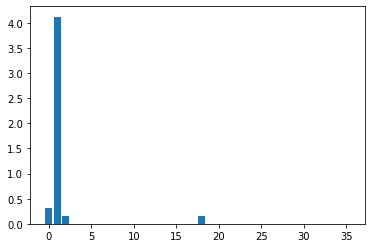

Histogram [0.3149252403259862, 4.123105625617661, 0.15186875007035466, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1574626201629931, 0.005593870092638418, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 0.026427202951769816
x, y, scale, mag: 296 675 0.38545551896095276 22.135943621178654
Index: 20
value: 0.7648470923039603
x, y, scale, mag: 296 676 0.38545551896095276 22.135943621178654
Index: 20
value: 0.026427202951769816
x, y, scale, mag: 296 677 0.38545551896095276 22.135943621178654
Index: 21
value: 0.7648470923039603
x, y, scale, mag: 297 675 0.38545551896095276 22.135943621178654
Index: 20
value: 22.135943621178654
x, y, scale, mag: 297 676 0.38545551896095276 22.135943621178654
Index: 19
value: 0.7648470923039603
x, y, scale, mag: 297 677 0.38545551896095276 22.135943621178654
Index: 22
value: 0.026427202951769816
x, y, scale, mag: 298 675 0.38545551896095276 22.135943621178654
Index: 21
value: 0.7648470923039603
x, y, scale, mag: 298 676 0.38545551896095276

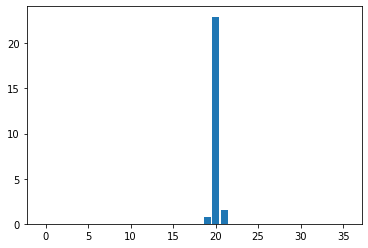

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7912742952557301, 22.953645119386156, 1.5296941846079206, 0.026427202951769816, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 22
value: 0.02243211954610471
x, y, scale, mag: 297 674 0.38700686395168304 17.804493814764857
Index: 21
value: 0.6319751052934657
x, y, scale, mag: 297 675 0.38700686395168304 17.804493814764857
Index: 20
value: 0.02243211954610471
x, y, scale, mag: 297 676 0.38700686395168304 17.804493814764857
Index: 24
value: 0.6319751052934657
x, y, scale, mag: 298 674 0.38700686395168304 17.804493814764857
Index: 22
value: 17.804493814764857
x, y, scale, mag: 298 675 0.38700686395168304 17.804493814764857
Index: 21
value: 0.6319751052934657
x, y, scale, mag: 298 676 0.38700686395168304 17.804493814764857
Index: 25
value: 0.02243211954610471
x, y, scale, mag: 299 674 0.38700686395168304 17.804493814764857
Index: 24
value: 0.6319751052934657
x, y, scale, mag: 299 675 0.38700686395168304 17.804493814764857


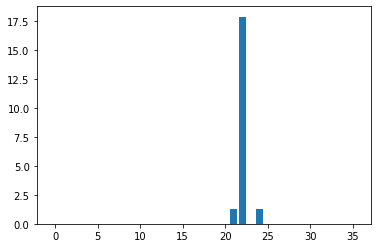

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02243211954610471, 1.2639502105869314, 17.849358053857063, 0, 1.2639502105869314, 0.02243211954610471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 19
value: 0.035870815960020376
x, y, scale, mag: 297 677 0.4173196703195572 11.180339887498949
Index: 17
value: 0.633283439286825
x, y, scale, mag: 297 678 0.4173196703195572 11.180339887498949
Index: 15
value: 0.035870815960020376
x, y, scale, mag: 297 679 0.4173196703195572 11.180339887498949
Index: 19
value: 0.633283439286825
x, y, scale, mag: 298 677 0.4173196703195572 11.180339887498949
Index: 15
value: 11.180339887498949
x, y, scale, mag: 298 678 0.4173196703195572 11.180339887498949
Index: 12
value: 0.633283439286825
x, y, scale, mag: 298 679 0.4173196703195572 11.180339887498949
Index: 17
value: 0.035870815960020376
x, y, scale, mag: 299 677 0.4173196703195572 11.180339887498949
Index: 11
value: 0.633283439286825
x, y, scale, mag: 299 678 0.4173196703195572 11.18033988

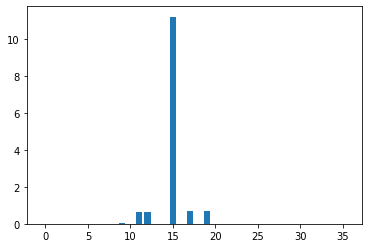

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.035870815960020376, 0, 0.633283439286825, 0.633283439286825, 0, 0, 11.21621070345897, 0, 0.6691542552468454, 0, 0.6691542552468454, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 24
value: 0.016041916578997988
x, y, scale, mag: 299 675 0.4173196703195572 5.0
Index: 22
value: 0.2832129638540403
x, y, scale, mag: 299 676 0.4173196703195572 5.0
Index: 17
value: 0.016041916578997988
x, y, scale, mag: 299 677 0.4173196703195572 5.0
Index: 26
value: 0.2832129638540403
x, y, scale, mag: 300 675 0.4173196703195572 5.0
Index: 24
value: 5.0
x, y, scale, mag: 300 676 0.4173196703195572 5.0
Index: 10
value: 0.2832129638540403
x, y, scale, mag: 300 677 0.4173196703195572 5.0
Index: 27
value: 0.016041916578997988
x, y, scale, mag: 301 675 0.4173196703195572 5.0
Index: 30
value: 0.2832129638540403
x, y, scale, mag: 301 676 0.4173196703195572 5.0
Index: 6
value: 0.016041916578997988
x, y, scale, mag: 301 677 0.4173196703195572 5.0


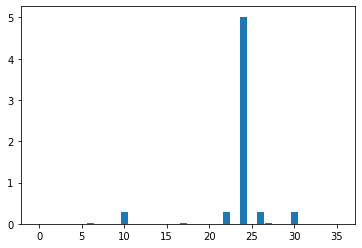

Histogram [0, 0, 0, 0, 0, 0, 0.016041916578997988, 0, 0, 0, 0.2832129638540403, 0, 0, 0, 0, 0, 0, 0.016041916578997988, 0, 0, 0, 0, 0.2832129638540403, 0, 5.016041916578998, 0, 0.2832129638540403, 0.016041916578997988, 0, 0, 0.2832129638540403, 0, 0, 0, 0, 0]
Index: 26
value: 0.0020399244699408005
x, y, scale, mag: 301 62 0.37797631323337555 2.23606797749979
Index: 13
value: 0.06753820980565636
x, y, scale, mag: 301 63 0.37797631323337555 2.23606797749979
Index: 9
value: 0.0020399244699408005
x, y, scale, mag: 301 64 0.37797631323337555 2.23606797749979
Index: 26
value: 0.06753820980565636
x, y, scale, mag: 302 62 0.37797631323337555 2.23606797749979
Index: 11
value: 2.23606797749979
x, y, scale, mag: 302 63 0.37797631323337555 2.23606797749979
Index: 9
value: 0.06753820980565636
x, y, scale, mag: 302 64 0.37797631323337555 2.23606797749979
Index: 26
value: 0.0020399244699408005
x, y, scale, mag: 303 62 0.37797631323337555 2.23606797749979
Index: 9
value: 0.06753820980565636
x, y, scal

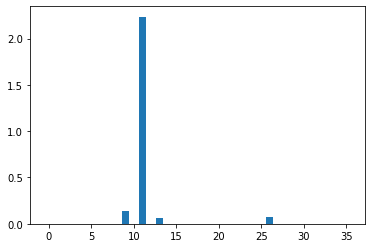

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13915626855119434, 0, 2.23606797749979, 0, 0.06753820980565636, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07161805874553798, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 25
value: 0.0030818243501439073
x, y, scale, mag: 310 60 0.39297719299793243 2.0
Index: 18
value: 0.07850890841355403
x, y, scale, mag: 310 61 0.39297719299793243 2.0
Index: 7
value: 0.0030818243501439073
x, y, scale, mag: 310 62 0.39297719299793243 2.0
Index: 26
value: 0.07850890841355403
x, y, scale, mag: 311 60 0.39297719299793243 2.0
Index: 9
value: 2.0
x, y, scale, mag: 311 61 0.39297719299793243 2.0
Index: 7
value: 0.07850890841355403
x, y, scale, mag: 311 62 0.39297719299793243 2.0
Index: 26
value: 0.0030818243501439073
x, y, scale, mag: 312 60 0.39297719299793243 2.0
Index: 6
value: 0.07850890841355403
x, y, scale, mag: 312 61 0.39297719299793243 2.0
Index: 7
value: 0.0030818243501439073
x, y, scale, mag: 312 62 0.39297719299793243 2.0


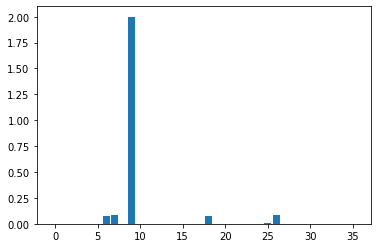

Histogram [0, 0, 0, 0, 0, 0, 0.07850890841355403, 0.08467255711384185, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07850890841355403, 0, 0, 0, 0, 0, 0, 0.0030818243501439073, 0.08159073276369794, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 0.004912788687676977
x, y, scale, mag: 311 36 0.37797631323337555 5.385164807134504
Index: 12
value: 0.16265354821142564
x, y, scale, mag: 311 37 0.37797631323337555 5.385164807134504
Index: 12
value: 0.004912788687676977
x, y, scale, mag: 311 38 0.37797631323337555 5.385164807134504
Index: 1
value: 0.16265354821142564
x, y, scale, mag: 312 36 0.37797631323337555 5.385164807134504
Index: 6
value: 5.385164807134504
x, y, scale, mag: 312 37 0.37797631323337555 5.385164807134504
Index: 9
value: 0.16265354821142564
x, y, scale, mag: 312 38 0.37797631323337555 5.385164807134504
Index: 0
value: 0.004912788687676977
x, y, scale, mag: 313 36 0.37797631323337555 5.385164807134504
Index: 1
value: 0.16265354821142564
x, y, scale, mag: 313 37 0.37797631323337555 5.3851648

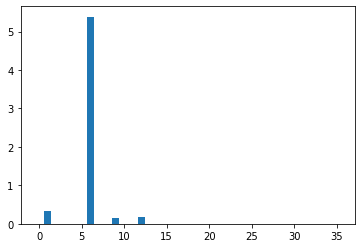

Histogram [0.004912788687676977, 0.32530709642285127, 0, 0.004912788687676977, 0, 0, 5.385164807134504, 0, 0, 0.16265354821142564, 0, 0.004912788687676977, 0.1675663368991026, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 0.008021860964068811
x, y, scale, mag: 321 15 0.39420756697654724 5.0
Index: 21
value: 0.20027307562511756
x, y, scale, mag: 321 16 0.39420756697654724 5.0
Index: 12
value: 0.008021860964068811
x, y, scale, mag: 321 17 0.39420756697654724 5.0
Index: 31
value: 0.20027307562511756
x, y, scale, mag: 322 15 0.39420756697654724 5.0
Index: 31
value: 5.0
x, y, scale, mag: 322 16 0.39420756697654724 5.0
Index: 9
value: 0.20027307562511756
x, y, scale, mag: 322 17 0.39420756697654724 5.0
Index: 32
value: 0.008021860964068811
x, y, scale, mag: 323 15 0.39420756697654724 5.0
Index: 32
value: 0.20027307562511756
x, y, scale, mag: 323 16 0.39420756697654724 5.0
Index: 0
value: 0.008021860964068811
x, y, scale, mag: 323 17 0.39420756697654724

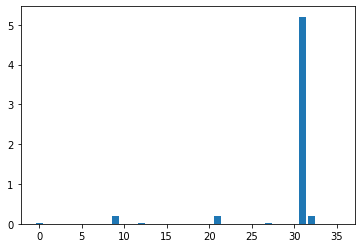

Histogram [0.008021860964068811, 0, 0, 0, 0, 0, 0, 0, 0, 0.20027307562511756, 0, 0, 0.008021860964068811, 0, 0, 0, 0, 0, 0, 0, 0, 0.20027307562511756, 0, 0, 0, 0, 0, 0.008021860964068811, 0, 0, 0, 5.200273075625118, 0.20829493658918638, 0, 0, 0]
Index: 31
value: 0.0065656918873080936
x, y, scale, mag: 331 24 0.3784538358449936 7.0710678118654755
Index: 18
value: 0.21546798501626765
x, y, scale, mag: 331 25 0.3784538358449936 7.0710678118654755
Index: 14
value: 0.0065656918873080936
x, y, scale, mag: 331 26 0.3784538358449936 7.0710678118654755
Index: 32
value: 0.21546798501626765
x, y, scale, mag: 332 24 0.3784538358449936 7.0710678118654755
Index: 32
value: 7.0710678118654755
x, y, scale, mag: 332 25 0.3784538358449936 7.0710678118654755
Index: 0
value: 0.21546798501626765
x, y, scale, mag: 332 26 0.3784538358449936 7.0710678118654755
Index: 32
value: 0.0065656918873080936
x, y, scale, mag: 333 24 0.3784538358449936 7.0710678118654755
Index: 33
value: 0.21546798501626765
x, y, scale, 

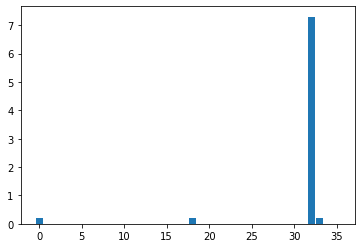

Histogram [0.21546798501626765, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0065656918873080936, 0, 0, 0, 0.21546798501626765, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0065656918873080936, 7.29966718065636, 0.21546798501626765, 0, 0]
Index: 0
value: 0.0007300965653326089
x, y, scale, mag: 332 26 0.36348241567611694 1.4142135623730951
Index: 14
value: 0.032132731980573793
x, y, scale, mag: 332 27 0.36348241567611694 1.4142135623730951
Index: 13
value: 0.0007300965653326089
x, y, scale, mag: 332 28 0.36348241567611694 1.4142135623730951
Index: 32
value: 0.032132731980573793
x, y, scale, mag: 333 26 0.36348241567611694 1.4142135623730951
Index: 32
value: 1.4142135623730951
x, y, scale, mag: 333 27 0.36348241567611694 1.4142135623730951
Index: 13
value: 0.032132731980573793
x, y, scale, mag: 333 28 0.36348241567611694 1.4142135623730951
Index: 33
value: 0.0007300965653326089
x, y, scale, mag: 334 26 0.36348241567611694 1.4142135623730951
Index: 32
value: 0.032132731980573793
x, y, scale, mag: 33

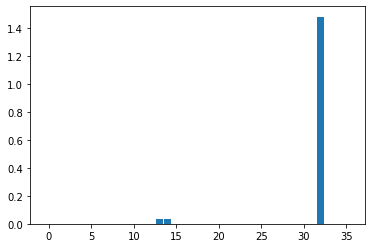

Histogram [0.0007300965653326089, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0328628285459064, 0.032132731980573793, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.4784790263342427, 0.0007300965653326089, 0.0007300965653326089, 0]
Index: 16
value: 0.001878146687344505
x, y, scale, mag: 338 8 0.3636978194117546 3.605551275463989
Index: 14
value: 0.08229066887602413
x, y, scale, mag: 338 9 0.3636978194117546 3.605551275463989
Index: 13
value: 0.001878146687344505
x, y, scale, mag: 338 10 0.3636978194117546 3.605551275463989
Index: 30
value: 0.08229066887602413
x, y, scale, mag: 339 8 0.3636978194117546 3.605551275463989
Index: 12
value: 3.605551275463989
x, y, scale, mag: 339 9 0.3636978194117546 3.605551275463989
Index: 13
value: 0.08229066887602413
x, y, scale, mag: 339 10 0.3636978194117546 3.605551275463989
Index: 33
value: 0.001878146687344505
x, y, scale, mag: 340 8 0.3636978194117546 3.605551275463989
Index: 35
value: 0.08229066887602413
x, y, scale, mag: 340 9 0.3636978194117546

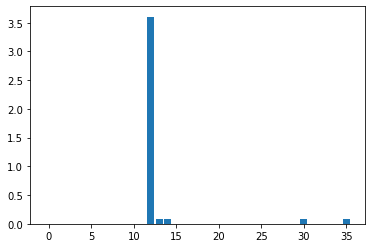

Histogram [0, 0, 0, 0, 0, 0, 0, 0.001878146687344505, 0, 0, 0, 0, 3.605551275463989, 0.08416881556336864, 0.08229066887602413, 0, 0.001878146687344505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08229066887602413, 0, 0, 0.001878146687344505, 0, 0.08229066887602413]
Index: 30
value: 0.03325591953278905
x, y, scale, mag: 339 60 0.4242640882730484 8.602325267042627
Index: 32
value: 0.5348628206144522
x, y, scale, mag: 339 61 0.4242640882730484 8.602325267042627
Index: 9
value: 0.03325591953278905
x, y, scale, mag: 339 62 0.4242640882730484 8.602325267042627
Index: 30
value: 0.5348628206144522
x, y, scale, mag: 340 60 0.4242640882730484 8.602325267042627
Index: 31
value: 8.602325267042627
x, y, scale, mag: 340 61 0.4242640882730484 8.602325267042627
Index: 7
value: 0.5348628206144522
x, y, scale, mag: 340 62 0.4242640882730484 8.602325267042627
Index: 30
value: 0.03325591953278905
x, y, scale, mag: 341 60 0.4242640882730484 8.602325267042627
Index: 31
value: 0.5348628206144522
x, y, scale, m

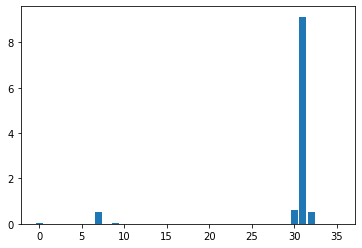

Histogram [0.03325591953278905, 0, 0, 0, 0, 0, 0, 0.5348628206144522, 0, 0.03325591953278905, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6013746596800303, 9.137188087657078, 0.5348628206144522, 0, 0, 0]
Index: 30
value: 0.010199622349704004
x, y, scale, mag: 343 61 0.37797631323337555 11.180339887498949
Index: 31
value: 0.3376910490282818
x, y, scale, mag: 343 62 0.37797631323337555 11.180339887498949
Index: 9
value: 0.010199622349704004
x, y, scale, mag: 343 63 0.37797631323337555 11.180339887498949
Index: 30
value: 0.3376910490282818
x, y, scale, mag: 344 61 0.37797631323337555 11.180339887498949
Index: 30
value: 11.180339887498949
x, y, scale, mag: 344 62 0.37797631323337555 11.180339887498949
Index: 0
value: 0.3376910490282818
x, y, scale, mag: 344 63 0.37797631323337555 11.180339887498949
Index: 30
value: 0.010199622349704004
x, y, scale, mag: 345 61 0.37797631323337555 11.180339887498949
Index: 30
value: 0.3376910490282818
x, y, scale, mag: 345 62 0.37797631323

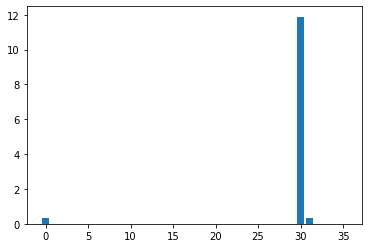

Histogram [0.3376910490282818, 0, 0, 0, 0, 0, 0, 0, 0, 0.010199622349704004, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.886320852604625, 0.3376910490282818, 0, 0, 0, 0]
Index: 30
value: 0.004079848939881601
x, y, scale, mag: 344 62 0.37797631323337555 4.47213595499958
Index: 0
value: 0.13507641961131273
x, y, scale, mag: 344 63 0.37797631323337555 4.47213595499958
Index: 10
value: 0.004079848939881601
x, y, scale, mag: 344 64 0.37797631323337555 4.47213595499958
Index: 30
value: 0.13507641961131273
x, y, scale, mag: 345 62 0.37797631323337555 4.47213595499958
Index: 30
value: 4.47213595499958
x, y, scale, mag: 345 63 0.37797631323337555 4.47213595499958
Index: 10
value: 0.13507641961131273
x, y, scale, mag: 345 64 0.37797631323337555 4.47213595499958
Index: 30
value: 0.004079848939881601
x, y, scale, mag: 346 62 0.37797631323337555 4.47213595499958
Index: 30
value: 0.13507641961131273
x, y, scale, mag: 346 63 0.37797631323337555 4.47213595499958
Index: 18
value: 0.0

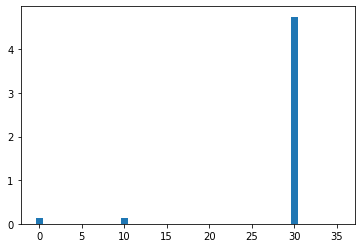

Histogram [0.13507641961131273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13915626855119434, 0, 0, 0, 0, 0, 0, 0, 0.004079848939881601, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.7504484921019685, 0, 0, 0, 0, 0]
Index: 13
value: 0.003999687335521507
x, y, scale, mag: 352 40 0.3871193826198578 3.1622776601683795
Index: 12
value: 0.11246386934824024
x, y, scale, mag: 352 41 0.3871193826198578 3.1622776601683795
Index: 12
value: 0.003999687335521507
x, y, scale, mag: 352 42 0.3871193826198578 3.1622776601683795
Index: 34
value: 0.11246386934824024
x, y, scale, mag: 353 40 0.3871193826198578 3.1622776601683795
Index: 7
value: 3.1622776601683795
x, y, scale, mag: 353 41 0.3871193826198578 3.1622776601683795
Index: 11
value: 0.11246386934824024
x, y, scale, mag: 353 42 0.3871193826198578 3.1622776601683795
Index: 33
value: 0.003999687335521507
x, y, scale, mag: 354 40 0.3871193826198578 3.1622776601683795
Index: 35
value: 0.11246386934824024
x, y, scale, mag: 354 41 0.3871193826198578 3.1622776601683795
Index: 5

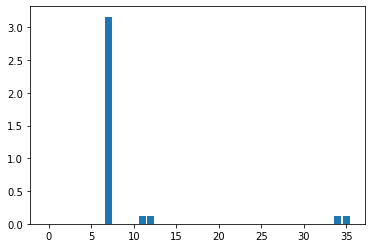

Histogram [0, 0, 0, 0, 0, 0.003999687335521507, 0, 3.1622776601683795, 0, 0, 0, 0.11246386934824024, 0.11646355668376174, 0.003999687335521507, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003999687335521507, 0.11246386934824024, 0.11246386934824024]
Index: 5
value: 0.008893219877324244
x, y, scale, mag: 354 42 0.3935869038105011 5.656854249492381
Index: 10
value: 0.22429366610475596
x, y, scale, mag: 354 43 0.3935869038105011 5.656854249492381
Index: 11
value: 0.008893219877324244
x, y, scale, mag: 354 44 0.3935869038105011 5.656854249492381
Index: 35
value: 0.22429366610475596
x, y, scale, mag: 355 42 0.3935869038105011 5.656854249492381
Index: 4
value: 5.656854249492381
x, y, scale, mag: 355 43 0.3935869038105011 5.656854249492381
Index: 10
value: 0.22429366610475596
x, y, scale, mag: 355 44 0.3935869038105011 5.656854249492381
Index: 34
value: 0.008893219877324244
x, y, scale, mag: 356 42 0.3935869038105011 5.656854249492381
Index: 35
value: 0.22429366610475596
x, y, 

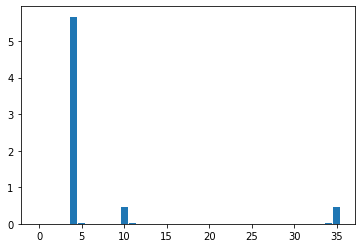

Histogram [0, 0, 0, 0, 5.6657474693697045, 0.008893219877324244, 0, 0, 0, 0, 0.4485873322095119, 0.008893219877324244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008893219877324244, 0.4485873322095119]
Index: 4
value: 0.00898598390661737
x, y, scale, mag: 355 43 0.39390362799167633 5.656854249492381
Index: 10
value: 0.22546042057979623
x, y, scale, mag: 355 44 0.39390362799167633 5.656854249492381
Index: 11
value: 0.00898598390661737
x, y, scale, mag: 355 45 0.39390362799167633 5.656854249492381
Index: 35
value: 0.22546042057979623
x, y, scale, mag: 356 43 0.39390362799167633 5.656854249492381
Index: 4
value: 5.656854249492381
x, y, scale, mag: 356 44 0.39390362799167633 5.656854249492381
Index: 10
value: 0.22546042057979623
x, y, scale, mag: 356 45 0.39390362799167633 5.656854249492381
Index: 34
value: 0.00898598390661737
x, y, scale, mag: 357 43 0.39390362799167633 5.656854249492381
Index: 35
value: 0.22546042057979623
x, y, scale, mag: 357 44 0.3939036279916

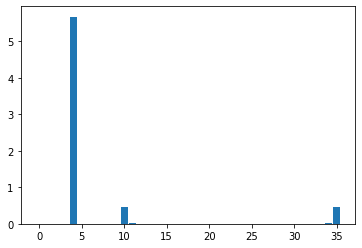

Histogram [0, 0, 0, 0, 5.674826217305616, 0, 0, 0, 0, 0, 0.45092084115959247, 0.00898598390661737, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00898598390661737, 0.45092084115959247]
Index: 0
value: 0.012639060287481466
x, y, scale, mag: 358 45 0.39281536638736725 8.246211251235321
Index: 5
value: 0.3228379797168716
x, y, scale, mag: 358 46 0.39281536638736725 8.246211251235321
Index: 10
value: 0.012639060287481466
x, y, scale, mag: 358 47 0.39281536638736725 8.246211251235321
Index: 34
value: 0.3228379797168716
x, y, scale, mag: 359 45 0.39281536638736725 8.246211251235321
Index: 35
value: 8.246211251235321
x, y, scale, mag: 359 46 0.39281536638736725 8.246211251235321
Index: 7
value: 0.3228379797168716
x, y, scale, mag: 359 47 0.39281536638736725 8.246211251235321
Index: 33
value: 0.012639060287481466
x, y, scale, mag: 360 45 0.39281536638736725 8.246211251235321
Index: 33
value: 0.3228379797168716
x, y, scale, mag: 360 46 0.39281536638736725 8.246211251235321

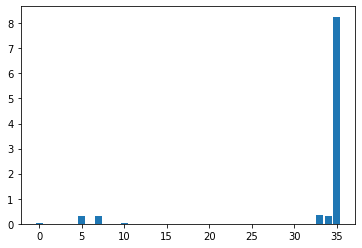

Histogram [0.012639060287481466, 0, 0, 0, 0, 0.3228379797168716, 0, 0.3228379797168716, 0, 0, 0.012639060287481466, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3354770400043531, 0.3228379797168716, 8.258850311522803]
Index: 29
value: 0.00729825565400457
x, y, scale, mag: 364 50 0.37797631323337555 8.0
Index: 20
value: 0.24163204512654476
x, y, scale, mag: 364 51 0.37797631323337555 8.0
Index: 15
value: 0.00729825565400457
x, y, scale, mag: 364 52 0.37797631323337555 8.0
Index: 29
value: 0.24163204512654476
x, y, scale, mag: 365 50 0.37797631323337555 8.0
Index: 27
value: 8.0
x, y, scale, mag: 365 51 0.37797631323337555 8.0
Index: 18
value: 0.24163204512654476
x, y, scale, mag: 365 52 0.37797631323337555 8.0
Index: 30
value: 0.00729825565400457
x, y, scale, mag: 366 50 0.37797631323337555 8.0
Index: 29
value: 0.24163204512654476
x, y, scale, mag: 366 51 0.37797631323337555 8.0
Index: 26
value: 0.00729825565400457
x, y, scale, mag: 366 52 0.37797631323337555 8.0


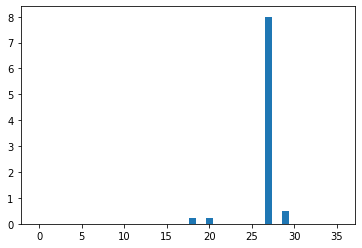

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00729825565400457, 0, 0, 0.24163204512654476, 0, 0.24163204512654476, 0, 0, 0, 0, 0, 0.00729825565400457, 8.0, 0, 0.49056234590709413, 0.00729825565400457, 0, 0, 0, 0, 0]
Index: 20
value: 0.008318817491264506
x, y, scale, mag: 364 51 0.3853244036436081 7.0
Index: 15
value: 0.24131249954954992
x, y, scale, mag: 364 52 0.3853244036436081 7.0
Index: 14
value: 0.008318817491264506
x, y, scale, mag: 364 53 0.3853244036436081 7.0
Index: 27
value: 0.24131249954954992
x, y, scale, mag: 365 51 0.3853244036436081 7.0
Index: 18
value: 7.0
x, y, scale, mag: 365 52 0.3853244036436081 7.0
Index: 14
value: 0.24131249954954992
x, y, scale, mag: 365 53 0.3853244036436081 7.0
Index: 29
value: 0.008318817491264506
x, y, scale, mag: 366 51 0.3853244036436081 7.0
Index: 26
value: 0.24131249954954992
x, y, scale, mag: 366 52 0.3853244036436081 7.0
Index: 17
value: 0.008318817491264506
x, y, scale, mag: 366 53 0.3853244036436081 7.0


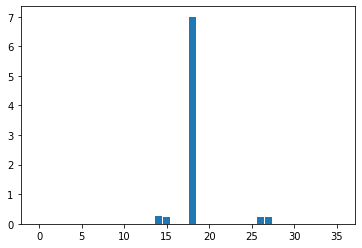

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24963131704081443, 0.24131249954954992, 0, 0.008318817491264506, 7.0, 0, 0.008318817491264506, 0, 0, 0, 0, 0, 0.24131249954954992, 0.24131249954954992, 0, 0.008318817491264506, 0, 0, 0, 0, 0, 0]
Index: 18
value: 0.007355052274445255
x, y, scale, mag: 365 52 0.37797631323337555 8.06225774829855
Index: 14
value: 0.2435124785073388
x, y, scale, mag: 365 53 0.37797631323337555 8.06225774829855
Index: 14
value: 0.007355052274445255
x, y, scale, mag: 365 54 0.37797631323337555 8.06225774829855
Index: 26
value: 0.2435124785073388
x, y, scale, mag: 366 52 0.37797631323337555 8.06225774829855
Index: 17
value: 8.06225774829855
x, y, scale, mag: 366 53 0.37797631323337555 8.06225774829855
Index: 15
value: 0.2435124785073388
x, y, scale, mag: 366 54 0.37797631323337555 8.06225774829855
Index: 29
value: 0.007355052274445255
x, y, scale, mag: 367 52 0.37797631323337555 8.06225774829855
Index: 24
value: 0.2435124785073388
x, y, scale, mag: 367 53

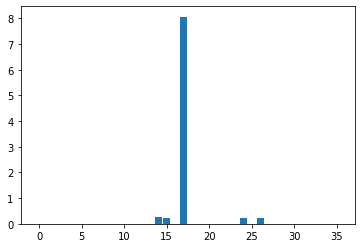

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25086753078178403, 0.2435124785073388, 0.007355052274445255, 8.06225774829855, 0.007355052274445255, 0, 0, 0, 0, 0, 0.2435124785073388, 0, 0.2435124785073388, 0, 0, 0.007355052274445255, 0, 0, 0, 0, 0, 0]
Index: 29
value: 0.047818815722787754
x, y, scale, mag: 366 51 0.4242640882730484 12.36931687685298
Index: 26
value: 0.7690813249266953
x, y, scale, mag: 366 52 0.4242640882730484 12.36931687685298
Index: 17
value: 0.047818815722787754
x, y, scale, mag: 366 53 0.4242640882730484 12.36931687685298
Index: 30
value: 0.7690813249266953
x, y, scale, mag: 367 51 0.4242640882730484 12.36931687685298
Index: 29
value: 12.36931687685298
x, y, scale, mag: 367 52 0.4242640882730484 12.36931687685298
Index: 24
value: 0.7690813249266953
x, y, scale, mag: 367 53 0.4242640882730484 12.36931687685298
Index: 30
value: 0.047818815722787754
x, y, scale, mag: 368 51 0.4242640882730484 12.36931687685298
Index: 30
value: 0.7690813249266953
x, y, scale, 

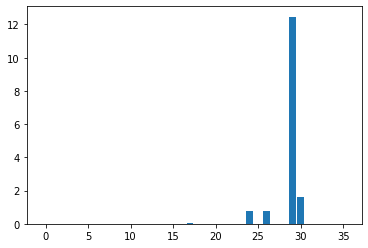

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.047818815722787754, 0, 0, 0, 0, 0, 0, 0.7690813249266953, 0, 0.7690813249266953, 0, 0, 12.464954508298558, 1.5859814655761784, 0, 0, 0, 0, 0]
Index: 17
value: 0.03564204085322972
x, y, scale, mag: 366 53 0.4242640882730484 9.219544457292887
Index: 15
value: 0.5732393742538981
x, y, scale, mag: 366 54 0.4242640882730484 9.219544457292887
Index: 14
value: 0.03564204085322972
x, y, scale, mag: 366 55 0.4242640882730484 9.219544457292887
Index: 24
value: 0.5732393742538981
x, y, scale, mag: 367 53 0.4242640882730484 9.219544457292887
Index: 16
value: 9.219544457292887
x, y, scale, mag: 367 54 0.4242640882730484 9.219544457292887
Index: 14
value: 0.5732393742538981
x, y, scale, mag: 367 55 0.4242640882730484 9.219544457292887
Index: 29
value: 0.03564204085322972
x, y, scale, mag: 368 53 0.4242640882730484 9.219544457292887
Index: 24
value: 0.5732393742538981
x, y, scale, mag: 368 54 0.4242640882730484 9.219544457292887
Index: 1

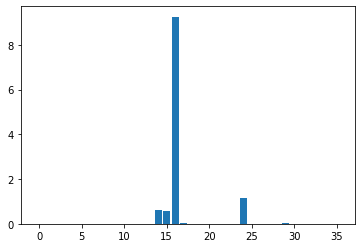

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6088814151071279, 0.5732393742538981, 9.255186498146116, 0.03564204085322972, 0, 0, 0, 0, 0, 0, 1.1464787485077963, 0, 0, 0, 0, 0.03564204085322972, 0, 0, 0, 0, 0, 0]
Index: 16
value: 0.010774391978244828
x, y, scale, mag: 367 54 0.38135017454624176 10.44030650891055
Index: 14
value: 0.33539224007126806
x, y, scale, mag: 367 55 0.38135017454624176 10.44030650891055
Index: 14
value: 0.010774391978244828
x, y, scale, mag: 367 56 0.38135017454624176 10.44030650891055
Index: 24
value: 0.33539224007126806
x, y, scale, mag: 368 54 0.38135017454624176 10.44030650891055
Index: 16
value: 10.44030650891055
x, y, scale, mag: 368 55 0.38135017454624176 10.44030650891055
Index: 15
value: 0.33539224007126806
x, y, scale, mag: 368 56 0.38135017454624176 10.44030650891055
Index: 29
value: 0.010774391978244828
x, y, scale, mag: 369 54 0.38135017454624176 10.44030650891055
Index: 22
value: 0.33539224007126806
x, y, scale, mag: 369 55 0.3813501745462

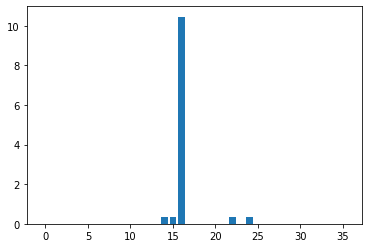

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.34616663204951287, 0.33539224007126806, 10.46185529286704, 0, 0, 0, 0, 0, 0.33539224007126806, 0, 0.33539224007126806, 0, 0, 0, 0, 0.010774391978244828, 0, 0, 0, 0, 0, 0]
Index: 29
value: 0.002833688365012435
x, y, scale, mag: 368 53 0.3475170359015465 11.180339887498949
Index: 24
value: 0.17799325564776383
x, y, scale, mag: 368 54 0.3475170359015465 11.180339887498949
Index: 16
value: 0.002833688365012435
x, y, scale, mag: 368 55 0.3475170359015465 11.180339887498949
Index: 30
value: 0.17799325564776383
x, y, scale, mag: 369 53 0.3475170359015465 11.180339887498949
Index: 29
value: 11.180339887498949
x, y, scale, mag: 369 54 0.3475170359015465 11.180339887498949
Index: 22
value: 0.17799325564776383
x, y, scale, mag: 369 55 0.3475170359015465 11.180339887498949
Index: 30
value: 0.002833688365012435
x, y, scale, mag: 370 53 0.3475170359015465 11.180339887498949
Index: 30
value: 0.17799325564776383
x, y, scale, mag: 370 54 0.34751703

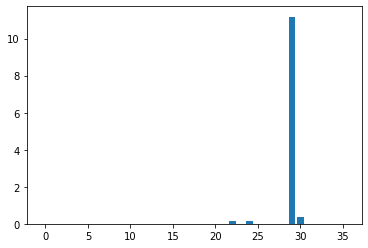

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002833688365012435, 0, 0, 0, 0, 0, 0.17799325564776383, 0, 0.17799325564776383, 0, 0, 0, 0.002833688365012435, 11.183173575863961, 0.35882019966054013, 0, 0, 0, 0, 0]
Index: 16
value: 0.023935277829938914
x, y, scale, mag: 368 55 0.40185628831386566 11.704699910719626
Index: 15
value: 0.5292969339408037
x, y, scale, mag: 368 56 0.40185628831386566 11.704699910719626
Index: 14
value: 0.023935277829938914
x, y, scale, mag: 368 57 0.40185628831386566 11.704699910719626
Index: 22
value: 0.5292969339408037
x, y, scale, mag: 369 55 0.40185628831386566 11.704699910719626
Index: 16
value: 11.704699910719626
x, y, scale, mag: 369 56 0.40185628831386566 11.704699910719626
Index: 15
value: 0.5292969339408037
x, y, scale, mag: 369 57 0.40185628831386566 11.704699910719626
Index: 28
value: 0.023935277829938914
x, y, scale, mag: 370 55 0.40185628831386566 11.704699910719626
Index: 21
value: 0.5292969339408037
x, y, scale, mag: 370 56 0.401

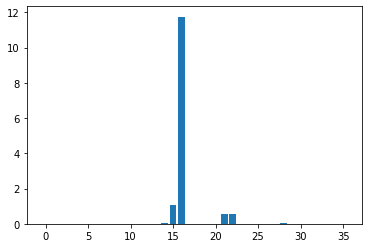

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.023935277829938914, 1.0585938678816074, 11.752570466379503, 0, 0, 0, 0, 0.5292969339408037, 0.5292969339408037, 0, 0, 0, 0, 0, 0.023935277829938914, 0, 0, 0, 0, 0, 0, 0]
Index: 21
value: 0.011471367413718181
x, y, scale, mag: 370 56 0.3936566412448883 7.280109889280518
Index: 16
value: 0.2889858393627273
x, y, scale, mag: 370 57 0.3936566412448883 7.280109889280518
Index: 15
value: 0.011471367413718181
x, y, scale, mag: 370 58 0.3936566412448883 7.280109889280518
Index: 27
value: 0.2889858393627273
x, y, scale, mag: 371 56 0.3936566412448883 7.280109889280518
Index: 20
value: 7.280109889280518
x, y, scale, mag: 371 57 0.3936566412448883 7.280109889280518
Index: 16
value: 0.2889858393627273
x, y, scale, mag: 371 58 0.3936566412448883 7.280109889280518
Index: 29
value: 0.011471367413718181
x, y, scale, mag: 372 56 0.3936566412448883 7.280109889280518
Index: 27
value: 0.2889858393627273
x, y, scale, mag: 372 57 0.3936566412448883 7.28

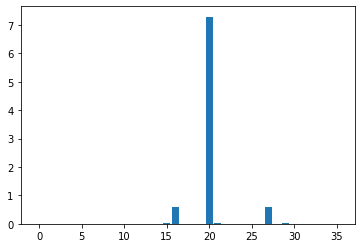

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.011471367413718181, 0.5779716787254546, 0, 0, 0, 7.291581256694236, 0.011471367413718181, 0, 0, 0, 0, 0, 0.5779716787254546, 0, 0.011471367413718181, 0, 0, 0, 0, 0, 0]
Index: 30
value: 0.013209793004189329
x, y, scale, mag: 371 55 0.3756233900785446 15.811388300841896
Index: 27
value: 0.4570176873633911
x, y, scale, mag: 371 56 0.3756233900785446 15.811388300841896
Index: 20
value: 0.013209793004189329
x, y, scale, mag: 371 57 0.3756233900785446 15.811388300841896
Index: 30
value: 0.4570176873633911
x, y, scale, mag: 372 55 0.3756233900785446 15.811388300841896
Index: 29
value: 15.811388300841896
x, y, scale, mag: 372 56 0.3756233900785446 15.811388300841896
Index: 27
value: 0.4570176873633911
x, y, scale, mag: 372 57 0.3756233900785446 15.811388300841896
Index: 30
value: 0.013209793004189329
x, y, scale, mag: 373 55 0.3756233900785446 15.811388300841896
Index: 30
value: 0.4570176873633911
x, y, scale, mag: 373 56 0.375623390078

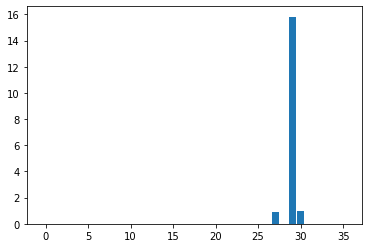

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.013209793004189329, 0, 0, 0, 0, 0, 0, 0.9140353747267822, 0, 15.824598093846086, 0.9404549607351609, 0, 0, 0, 0, 0]
Index: 27
value: 4.0
x, y, scale, mag: 47 702 0.23811015486717224 4.0


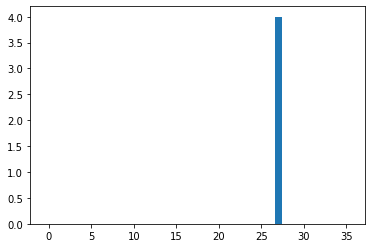

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 32
value: 9.219544457292887
x, y, scale, mag: 48 701 0.2367720901966095 9.219544457292887


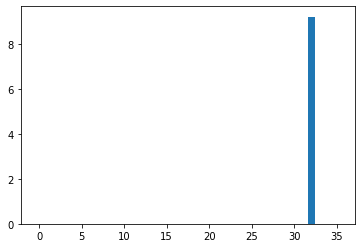

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.219544457292887, 0, 0, 0]
Index: 0
value: 3.0
x, y, scale, mag: 49 690 0.21603698283433914 3.0


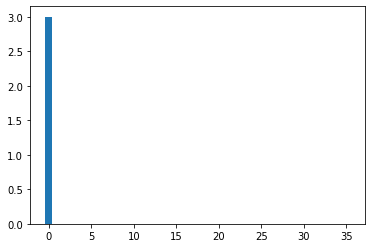

Histogram [3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 29
value: 7.280109889280518
x, y, scale, mag: 51 724 0.21783169358968735 7.280109889280518


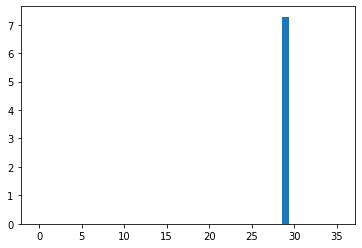

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.280109889280518, 0, 0, 0, 0, 0, 0]
Index: 14
value: 6.4031242374328485
x, y, scale, mag: 61 743 0.21371899545192719 6.4031242374328485


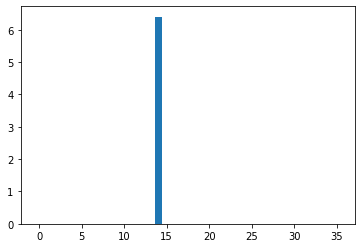

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.4031242374328485, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 20
value: 10.198039027185569
x, y, scale, mag: 122 555 0.2451123297214508 10.198039027185569


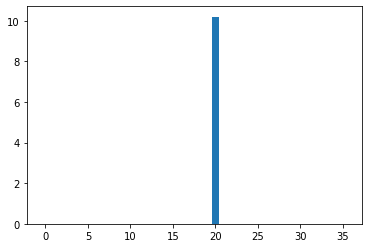

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.198039027185569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 26
value: 5.0990195135927845
x, y, scale, mag: 151 543 0.23811015486717224 5.0990195135927845


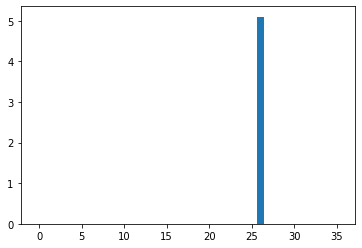

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.0990195135927845, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 10
value: 8.246211251235321
x, y, scale, mag: 166 706 0.23811015486717224 8.246211251235321


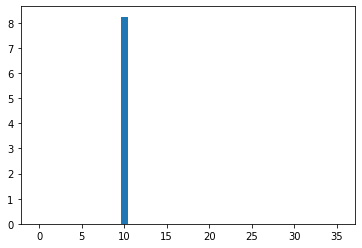

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.246211251235321, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 9
value: 3.0
x, y, scale, mag: 167 595 0.24756011366844177 3.0


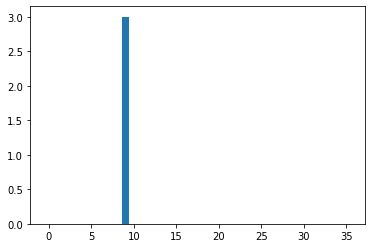

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 12
value: 5.830951894845301
x, y, scale, mag: 167 597 0.26095716655254364 5.830951894845301


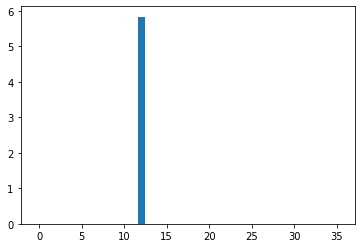

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.830951894845301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 14
value: 5.0
x, y, scale, mag: 170 605 0.23780639469623566 5.0


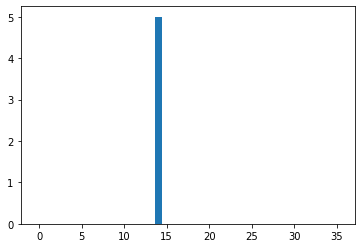

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 4.0
x, y, scale, mag: 174 613 0.23391560465097427 4.0


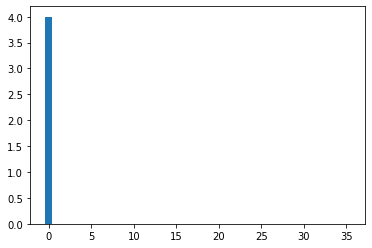

Histogram [4.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 13
value: 1.4142135623730951
x, y, scale, mag: 190 590 0.23811015486717224 1.4142135623730951


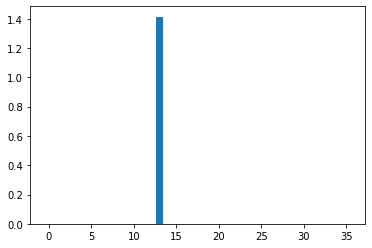

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.4142135623730951, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 21
value: 2.23606797749979
x, y, scale, mag: 191 705 0.23811015486717224 2.23606797749979


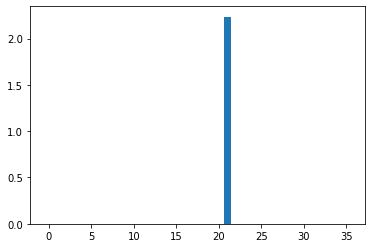

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.23606797749979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 5
value: 3.605551275463989
x, y, scale, mag: 192 642 0.2602384686470032 3.605551275463989


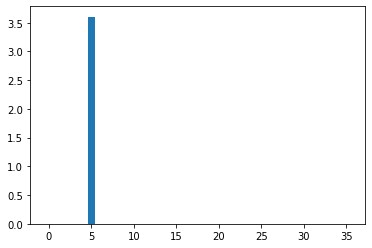

Histogram [0, 0, 0, 0, 0, 3.605551275463989, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 13.92838827718412
x, y, scale, mag: 192 644 0.2451251819729805 13.92838827718412


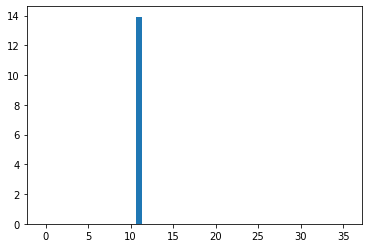

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.92838827718412, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 12
value: 8.602325267042627
x, y, scale, mag: 202 652 0.2628949284553528 8.602325267042627


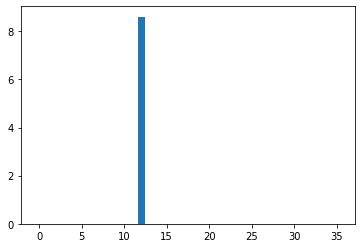

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.602325267042627, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 10
value: 7.280109889280518
x, y, scale, mag: 203 653 0.2672696113586426 7.280109889280518


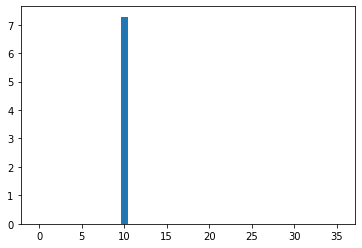

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.280109889280518, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 9.0
x, y, scale, mag: 204 652 0.23811015486717224 9.0


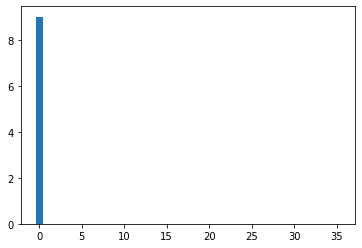

Histogram [9.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 9
value: 8.06225774829855
x, y, scale, mag: 205 656 0.2360035702586174 8.06225774829855


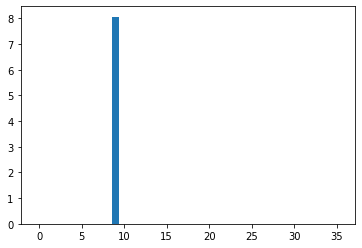

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 8.06225774829855, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 1
value: 6.324555320336759
x, y, scale, mag: 206 656 0.23811015486717224 6.324555320336759


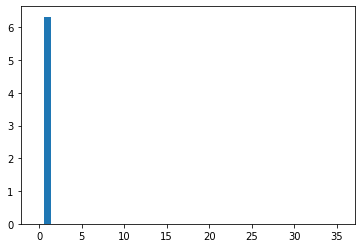

Histogram [0, 6.324555320336759, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 9
value: 11.0
x, y, scale, mag: 207 588 0.23811015486717224 11.0


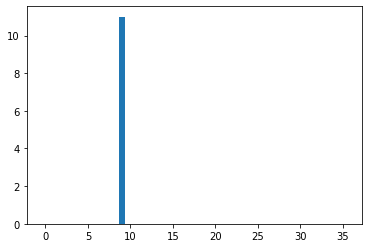

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 11.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 9
value: 3.0
x, y, scale, mag: 207 658 0.23811015486717224 3.0


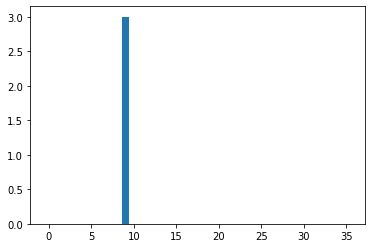

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 12
value: 5.0
x, y, scale, mag: 212 69 0.23811015486717224 5.0


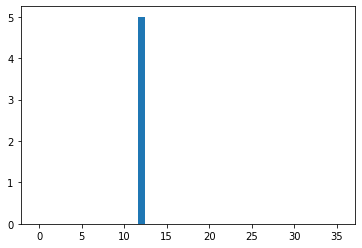

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 17
value: 6.082762530298219
x, y, scale, mag: 212 664 0.2589801102876663 6.082762530298219


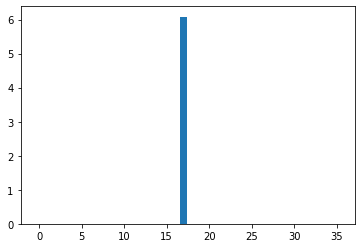

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.082762530298219, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 1.0
x, y, scale, mag: 215 667 0.23928985744714737 1.0


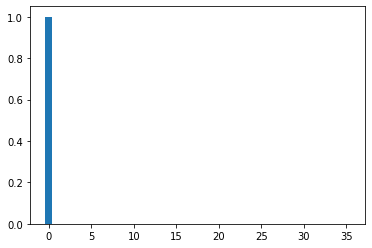

Histogram [1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 2.0
x, y, scale, mag: 217 670 0.2121320441365242 2.0


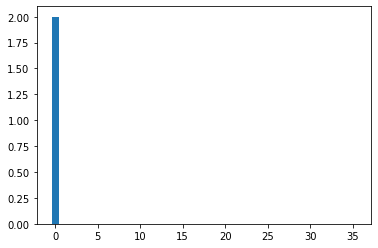

Histogram [2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 34
value: 5.385164807134504
x, y, scale, mag: 218 671 0.23811015486717224 5.385164807134504


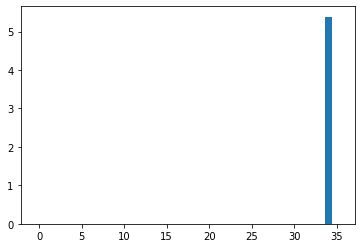

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.385164807134504, 0]
Index: 16
value: 8.246211251235321
x, y, scale, mag: 219 675 0.2589801102876663 8.246211251235321


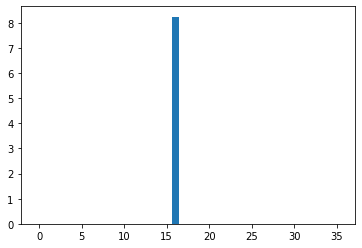

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.246211251235321, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 15
value: 16.15549442140351
x, y, scale, mag: 220 678 0.2456446811556816 16.15549442140351


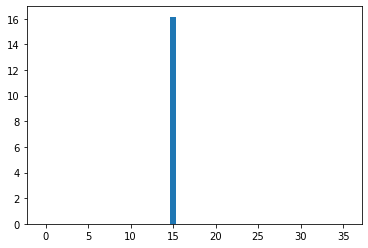

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16.15549442140351, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 28
value: 6.082762530298219
x, y, scale, mag: 222 677 0.2589801102876663 6.082762530298219


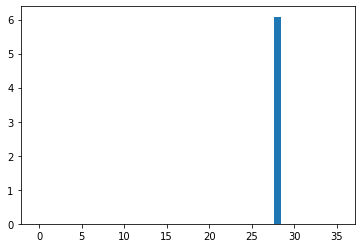

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.082762530298219, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 3.0
x, y, scale, mag: 223 706 0.26593054085969925 3.0


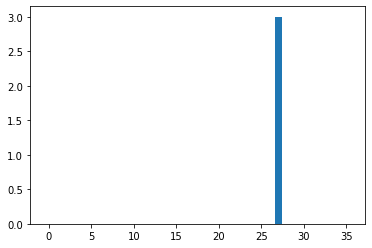

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 12
value: 9.433981132056603
x, y, scale, mag: 223 708 0.2672696113586426 9.433981132056603


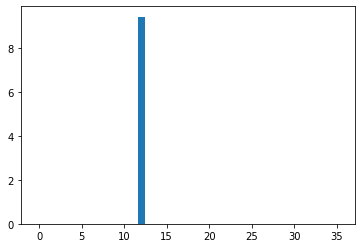

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.433981132056603, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 30
value: 7.615773105863909
x, y, scale, mag: 224 679 0.23750636726617813 7.615773105863909


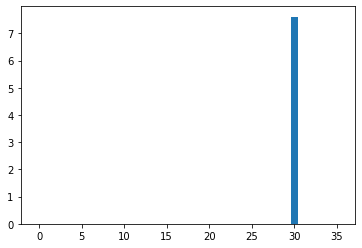

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.615773105863909, 0, 0, 0, 0, 0]
Index: 18
value: 5.0
x, y, scale, mag: 224 681 0.23811015486717224 5.0


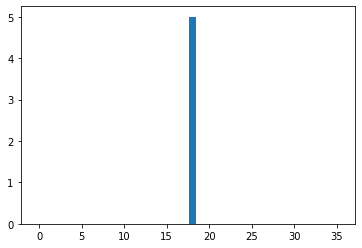

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 0.0
x, y, scale, mag: 224 707 0.2649446055293083 0.0


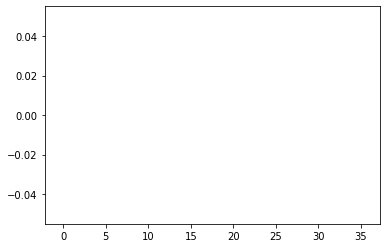

Histogram [0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 6
value: 2.23606797749979
x, y, scale, mag: 231 691 0.24745816737413406 2.23606797749979


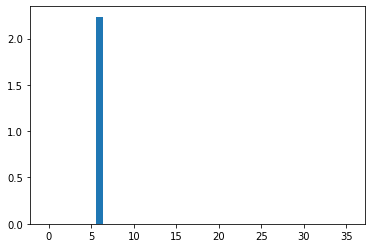

Histogram [0, 0, 0, 0, 0, 0, 2.23606797749979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 29
value: 3.1622776601683795
x, y, scale, mag: 285 64 0.23707439750432968 3.1622776601683795


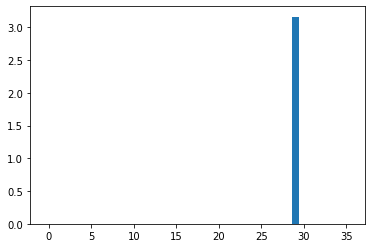

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.1622776601683795, 0, 0, 0, 0, 0, 0]
Index: 16
value: 3.1622776601683795
x, y, scale, mag: 300 677 0.24745816737413406 3.1622776601683795


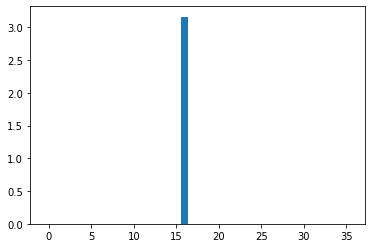

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.1622776601683795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 27
value: 3.0
x, y, scale, mag: 301 676 0.2619988024234772 3.0


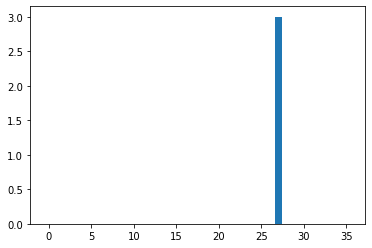

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 30
value: 10.295630140987
x, y, scale, mag: 341 61 0.2672696113586426 10.295630140987


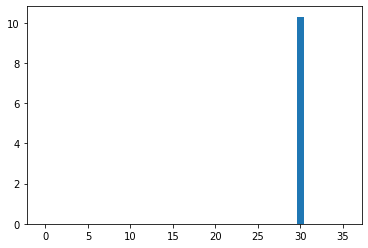

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.295630140987, 0, 0, 0, 0, 0]
Index: 32
value: 4.242640687119285
x, y, scale, mag: 342 62 0.21726342290639877 4.242640687119285


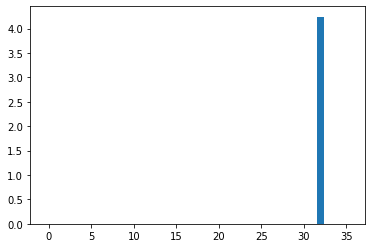

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.242640687119285, 0, 0, 0]
Index: 11
value: 8.06225774829855
x, y, scale, mag: 352 41 0.2672696113586426 8.06225774829855


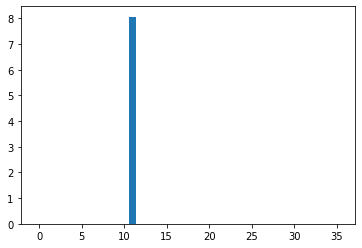

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.06225774829855, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 11
value: 8.54400374531753
x, y, scale, mag: 353 42 0.2672696113586426 8.54400374531753


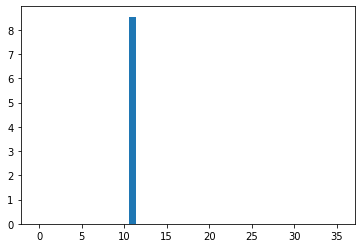

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.54400374531753, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 4
value: 4.242640687119285
x, y, scale, mag: 354 42 0.2672696113586426 4.242640687119285


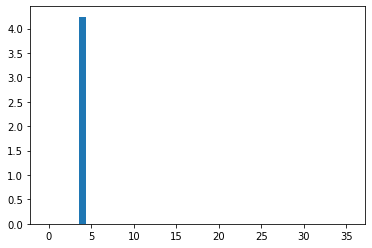

Histogram [0, 0, 0, 0, 4.242640687119285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 10
value: 9.219544457292887
x, y, scale, mag: 354 43 0.23811015486717224 9.219544457292887


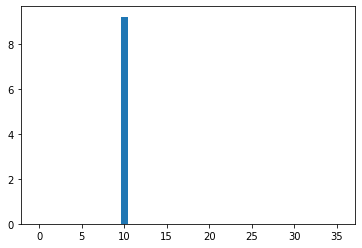

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.219544457292887, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 0
value: 8.06225774829855
x, y, scale, mag: 358 45 0.23811015486717224 8.06225774829855


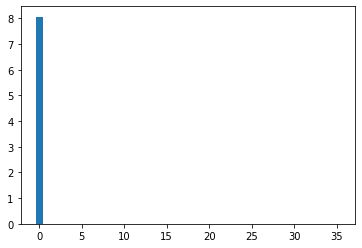

Histogram [8.06225774829855, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Index: 29
value: 10.198039027185569
x, y, scale, mag: 368 53 0.21892201155424118 10.198039027185569


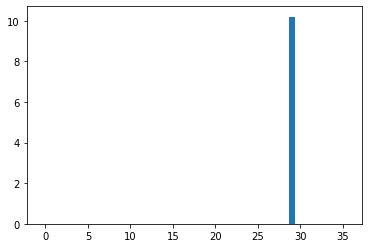

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10.198039027185569, 0, 0, 0, 0, 0, 0]
Index: 30
value: 13.92838827718412
x, y, scale, mag: 371 55 0.22902240604162216 13.92838827718412


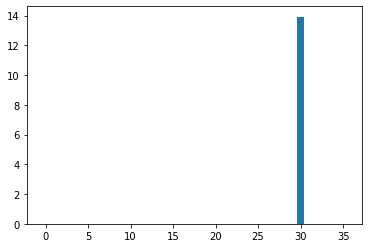

Histogram [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.92838827718412, 0, 0, 0, 0, 0]
Discarded points : 1185


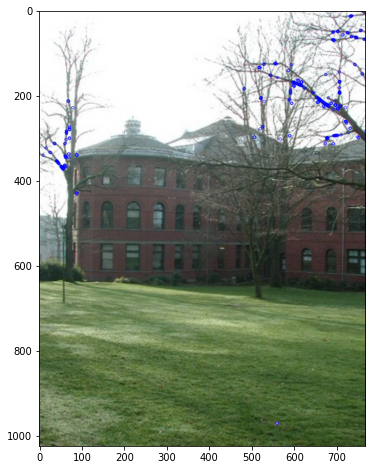

In [13]:
keypoints = findExtremaInDoG(DoGOctaves)
magOctaves, sitaOctaves = get_gradients(GaussianOctaves)
cv_keypoints = []
keypoint_dict = {}
discard_pnts_count = 0
for keypoint in keypoints:
    var = findScaleSpaceExtrema(DoGOctaves[0], keypoint[0], keypoint[1], keypoint[2])
    if var is not None:
        row, col, sigma_idx, extremum = var
        if (row, col) not in keypoint_dict:
            octave_index = 0
            sigma = 1.6
            keypoint_size = sigma * (2 ** ((sigma_idx + extremum[2]) / 3.0)) * (2 ** (octave_index + 1))
            cv_keypoint = cv2.KeyPoint(col, row, keypoint_size)
            cv_keypoint.octave = octave_index
            cv_keypoints.append(cv_keypoint)
            get_orientation(cv_keypoint, sigma_idx, magOctaves, sitaOctaves)
            keypoint_dict[(row, col)] = 1
    else:
        discard_pnts_count += 1

print("Discarded points :", discard_pnts_count)



im_key = cv2.drawKeypoints(cv2.resize(imgs[0], (imgs[0].shape[1] * 2, imgs[0].shape[0] * 2)), cv_keypoints, np.array([]), (255, 0, 0))
# im_key = cv2.drawKeypoints(imgs, cv_keypoints, np.array([]), (255, 0, 0))

utils.imshow_plt(im_key)

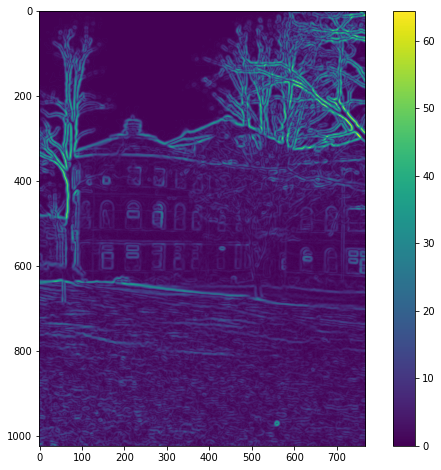

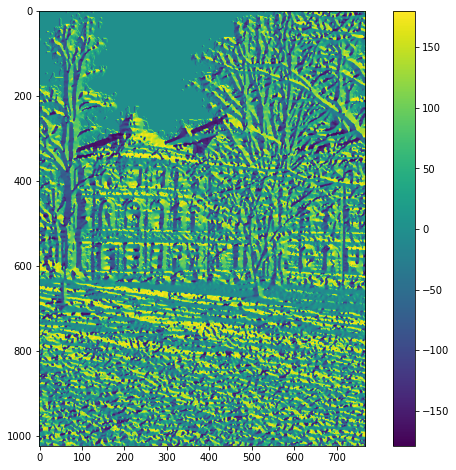

In [14]:
magOctaves, sitaOctaves = get_gradients(GaussianOctaves)

utils.imshow_plt(magOctaves[0][0], color_bar=True)
utils.imshow_plt(sitaOctaves[0][0], color_bar=True)
